In [1]:
import numpy as np
import matplotlib.pyplot as pl
import json
import pandas as pd
import geopandas as gpd
import tensorflow as tf
from sklearn.utils import class_weight
from tensorflow import keras 
from tensorflow.keras import Sequential, activations, Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    BatchNormalization, Activation, SpatialDropout2D, GlobalAveragePooling2D,
    Dense, Dropout, Flatten,
    Conv2D, MaxPooling2D, SeparableConv2D
)
from tensorflow.keras.layers.experimental.preprocessing import Rescaling

# Import project utils scripts
import os
import sys

src_path = os.path.abspath(os.path.join('../src/'))

if src_path not in sys.path:
    sys.path.append(src_path)

from statisticsUtils import (
    recall_precision_fscore_from_confusion_matrix
)

from labelsUtils import (
    Label,
)

from regionUtils import (
    vietnam_labels_coordinates,
)

from rasterUtils import (
    make_dataset_from_raster_files,
)

from convNetUtils import (
    cross_validation,
    spatial_separation_dataset,
    cross_validation_from_csv_files,
    plot_confusion_matrix,
    display_cross_val_map_class
)

/home/simon/miniconda3/envs/earthEngine/lib/python3.7/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [2]:
from enum import Enum

class Band(Enum):
    COASTAL_AEROSOL = 0
    BLUE = 1
    GREEN = 2
    RED = 3
    NIR = 4
    SWIR1 = 5
    SWIR2 = 6
    TIRS1 = 7
    TIRS2 = 8

In [3]:
DATA_ROOT_PATH ='../data/'
LABELS_COORDINATES = vietnam_labels_coordinates()
BANDS = [
    Band.BLUE.value,
    Band.RED.value,
    Band.NIR.value
]

In [4]:
labels = [
    Label.COFFEE,
    Label.NATIVEVEGE,
    Label.URBAN,
    Label.WATER,
    Label.PEPPER,
    Label.TEA,
]

# Spatial validation

In [5]:
DATA_ROOT_PATH = '../data/'
DISTRICTS_PATH = DATA_ROOT_PATH + "districts/diaphantinh.geojson"

In [9]:
dataset_args = dict(
    labels = labels,
    raster_paths = [DATA_ROOT_PATH + 'Vietnam_2017_january_march/merged.tif'],
    labels_coordinates_list = [LABELS_COORDINATES],
    nb_pixel_around = NB_PIXEL_AROUND,
    save_on_disk=True,
    dataset_folder_name="Vietnam_2017_january_march"
)

dataset = make_dataset_from_raster_files(**dataset_args)

In [10]:
vietnam_shape = gpd.read_file(DISTRICTS_PATH)

In [11]:
df = pd.DataFrame(dataset, columns=['label', 'images', 'geometry'])
geo_df = gpd.GeoDataFrame(df, geometry='geometry')  # spacv requests a dataframe

In [12]:
geo_df

label                                             images  \
0     COFFEE  ../data/datasets/images/Vietnam_2017_january_m...   
1     COFFEE  ../data/datasets/images/Vietnam_2017_january_m...   
2     COFFEE  ../data/datasets/images/Vietnam_2017_january_m...   
3     COFFEE  ../data/datasets/images/Vietnam_2017_january_m...   
4     COFFEE  ../data/datasets/images/Vietnam_2017_january_m...   
...      ...                                                ...   
9206     TEA  ../data/datasets/images/Vietnam_2017_january_m...   
9207     TEA  ../data/datasets/images/Vietnam_2017_january_m...   
9208     TEA  ../data/datasets/images/Vietnam_2017_january_m...   
9209     TEA  ../data/datasets/images/Vietnam_2017_january_m...   
9210     TEA  ../data/datasets/images/Vietnam_2017_january_m...   

                        geometry  
0     POINT (108.26488 14.02468)  
1     POINT (108.27041 14.02831)  
2     POINT (108.25905 14.03029)  
3     POINT (108.26109 14.03121)  
4     POINT (108.24059 14.02134)  
...                          ...  
9206  POINT (107.76376 11.64308)  
9207  POINT (107.76379 11.64391)  
9208  POINT (107.76542 11.64458)  
9209  POINT (107.76581 11.64659)  
9210  POINT (107.76812 11.64519)  

[9211 rows x 3 columns]

In [13]:
geo_df['label']

0       COFFEE
1       COFFEE
2       COFFEE
3       COFFEE
4       COFFEE
         ...  
9206       TEA
9207       TEA
9208       TEA
9209       TEA
9210       TEA
Name: label, Length: 9211, dtype: object

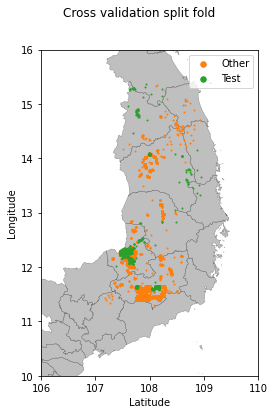

In [14]:
test, other = next(spatial_separation_dataset(geo_df, labels))
display_cross_val_map_class([other, test], vietnam_shape, f"Cross validation split fold")

In [6]:
test_csv_filename = 'Vietnam_2017_january_march_test.csv'
other_csv_filename = 'Vietnam_2017_january_march_other.csv'

In [16]:
# Save test set on the disk
test.to_csv(os.path.join(DATA_ROOT_PATH, 'datasets', test_csv_filename), index=False)

# Save other set on the disk
other.to_csv(os.path.join(DATA_ROOT_PATH, 'datasets', other_csv_filename), index=False)

In [7]:
NB_PIXEL_AROUND=4
NB_TESTS = 4
EPOCHS = 2000

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 9, 9, 3)           0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 9, 9, 3)           12        
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 9, 9, 32)          896       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 9, 9, 32)          9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 32)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 3, 3, 64)          18496     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 3, 3, 64)         

Epoch 43/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.8244 - accuracy: 0.6254 - val_loss: 1.0341 - val_accuracy: 0.5724
Epoch 44/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.8300 - accuracy: 0.6156 - val_loss: 1.0525 - val_accuracy: 0.5628
Epoch 45/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.8127 - accuracy: 0.6181 - val_loss: 0.9785 - val_accuracy: 0.5970
Epoch 46/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.7984 - accuracy: 0.6226 - val_loss: 0.9702 - val_accuracy: 0.6090
Epoch 47/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.8197 - accuracy: 0.6265 - val_loss: 1.1089 - val_accuracy: 0.5508
Epoch 48/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.8122 - accuracy: 0.6170 - val_loss: 1.0196 - val_accuracy: 0.5985
Epoch 49/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.7985 - accuracy: 0.6250 - val_loss: 1.0218 - val_ac

159/159 [==============================] - 1s 3ms/step - loss: 0.7125 - accuracy: 0.6657 - val_loss: 0.9749 - val_accuracy: 0.6176
Epoch 100/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.7057 - accuracy: 0.6686 - val_loss: 0.9852 - val_accuracy: 0.6156
Epoch 101/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.7094 - accuracy: 0.6520 - val_loss: 0.9828 - val_accuracy: 0.6241
Epoch 102/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.7013 - accuracy: 0.6628 - val_loss: 1.0056 - val_accuracy: 0.5925
Epoch 103/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.7052 - accuracy: 0.6618 - val_loss: 0.9979 - val_accuracy: 0.6090
Epoch 104/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.6988 - accuracy: 0.6571 - val_loss: 1.0407 - val_accuracy: 0.5995
Epoch 105/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.7170 - accuracy: 0.6571 - val_loss: 1.0462 - val_accuracy: 

159/159 [==============================] - 1s 3ms/step - loss: 0.6380 - accuracy: 0.6890 - val_loss: 0.9216 - val_accuracy: 0.6608
Epoch 156/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.6552 - accuracy: 0.6866 - val_loss: 0.9867 - val_accuracy: 0.6070
Epoch 157/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.6449 - accuracy: 0.6716 - val_loss: 0.9175 - val_accuracy: 0.6452
Epoch 158/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.6314 - accuracy: 0.6880 - val_loss: 0.9768 - val_accuracy: 0.6417
Epoch 159/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.6164 - accuracy: 0.6843 - val_loss: 1.0035 - val_accuracy: 0.6266
Epoch 160/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.6469 - accuracy: 0.6925 - val_loss: 1.1663 - val_accuracy: 0.5633
Epoch 161/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.6221 - accuracy: 0.6876 - val_loss: 0.9557 - val_accuracy: 

159/159 [==============================] - 1s 3ms/step - loss: 0.5896 - accuracy: 0.6962 - val_loss: 0.9905 - val_accuracy: 0.6367
Epoch 212/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.5954 - accuracy: 0.7011 - val_loss: 0.9390 - val_accuracy: 0.6543
Epoch 213/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.5827 - accuracy: 0.7039 - val_loss: 0.9599 - val_accuracy: 0.6377
Epoch 214/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.5742 - accuracy: 0.7084 - val_loss: 0.9963 - val_accuracy: 0.6241
Epoch 215/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.6040 - accuracy: 0.6909 - val_loss: 1.0194 - val_accuracy: 0.6055
Epoch 216/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.5974 - accuracy: 0.6995 - val_loss: 0.9170 - val_accuracy: 0.6568
Epoch 217/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.5815 - accuracy: 0.7035 - val_loss: 0.9968 - val_accuracy: 

159/159 [==============================] - 1s 3ms/step - loss: 0.5613 - accuracy: 0.7152 - val_loss: 0.9332 - val_accuracy: 0.6910
Epoch 268/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.5520 - accuracy: 0.7172 - val_loss: 0.9233 - val_accuracy: 0.6814
Epoch 269/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.5443 - accuracy: 0.7189 - val_loss: 0.9748 - val_accuracy: 0.6563
Epoch 270/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.5767 - accuracy: 0.7099 - val_loss: 1.0484 - val_accuracy: 0.6075
Epoch 271/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.5502 - accuracy: 0.7170 - val_loss: 1.0020 - val_accuracy: 0.6231
Epoch 272/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.5609 - accuracy: 0.7107 - val_loss: 0.9583 - val_accuracy: 0.6578
Epoch 273/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.5381 - accuracy: 0.7178 - val_loss: 0.9691 - val_accuracy: 

159/159 [==============================] - 1s 3ms/step - loss: 0.5306 - accuracy: 0.7428 - val_loss: 0.9539 - val_accuracy: 0.6844
Epoch 324/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.5035 - accuracy: 0.7301 - val_loss: 1.0400 - val_accuracy: 0.6487
Epoch 325/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.5171 - accuracy: 0.7246 - val_loss: 0.9851 - val_accuracy: 0.6608
Epoch 326/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.5464 - accuracy: 0.7246 - val_loss: 1.0305 - val_accuracy: 0.6503
Epoch 327/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.5261 - accuracy: 0.7262 - val_loss: 0.9845 - val_accuracy: 0.6704
Epoch 328/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.5251 - accuracy: 0.7379 - val_loss: 1.0221 - val_accuracy: 0.6593
Epoch 329/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.5086 - accuracy: 0.7299 - val_loss: 0.9282 - val_accuracy: 

159/159 [==============================] - 1s 3ms/step - loss: 0.4989 - accuracy: 0.7356 - val_loss: 1.0020 - val_accuracy: 0.6623
Epoch 380/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.4921 - accuracy: 0.7334 - val_loss: 0.9142 - val_accuracy: 0.6980
Epoch 381/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.5040 - accuracy: 0.7399 - val_loss: 0.9679 - val_accuracy: 0.6960
Epoch 382/2000
159/159 [==============================] - 1s 4ms/step - loss: 0.5031 - accuracy: 0.7348 - val_loss: 1.0083 - val_accuracy: 0.6523
Epoch 383/2000
159/159 [==============================] - 1s 4ms/step - loss: 0.5097 - accuracy: 0.7291 - val_loss: 1.0303 - val_accuracy: 0.6558
Epoch 384/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.5069 - accuracy: 0.7430 - val_loss: 1.1336 - val_accuracy: 0.6492
Epoch 385/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.4948 - accuracy: 0.7407 - val_loss: 1.0646 - val_accuracy: 

159/159 [==============================] - 1s 3ms/step - loss: 0.4905 - accuracy: 0.7354 - val_loss: 0.9993 - val_accuracy: 0.6472
Epoch 436/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.4852 - accuracy: 0.7500 - val_loss: 0.9158 - val_accuracy: 0.6704
Epoch 437/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.4813 - accuracy: 0.7526 - val_loss: 1.0704 - val_accuracy: 0.6377
Epoch 438/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.4839 - accuracy: 0.7491 - val_loss: 0.9862 - val_accuracy: 0.6759
Epoch 439/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.5112 - accuracy: 0.7397 - val_loss: 0.9188 - val_accuracy: 0.6915
Epoch 440/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.4811 - accuracy: 0.7485 - val_loss: 1.0470 - val_accuracy: 0.6769
Epoch 441/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.4889 - accuracy: 0.7461 - val_loss: 0.9614 - val_accuracy: 

159/159 [==============================] - 1s 3ms/step - loss: 0.4587 - accuracy: 0.7565 - val_loss: 0.9136 - val_accuracy: 0.7080
Epoch 492/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.4781 - accuracy: 0.7497 - val_loss: 1.0827 - val_accuracy: 0.6442
Epoch 493/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.4556 - accuracy: 0.7542 - val_loss: 0.9484 - val_accuracy: 0.6874
Epoch 494/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.4693 - accuracy: 0.7506 - val_loss: 1.0092 - val_accuracy: 0.6608
Epoch 495/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.4572 - accuracy: 0.7546 - val_loss: 1.0822 - val_accuracy: 0.6417
Epoch 496/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.4794 - accuracy: 0.7452 - val_loss: 0.8674 - val_accuracy: 0.7342
Epoch 497/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.4758 - accuracy: 0.7538 - val_loss: 1.0379 - val_accuracy: 

159/159 [==============================] - 1s 3ms/step - loss: 0.4503 - accuracy: 0.7585 - val_loss: 1.0671 - val_accuracy: 0.6930
Epoch 548/2000
159/159 [==============================] - 1s 4ms/step - loss: 0.4354 - accuracy: 0.7667 - val_loss: 1.0492 - val_accuracy: 0.6673
Epoch 549/2000
159/159 [==============================] - 1s 4ms/step - loss: 0.4474 - accuracy: 0.7522 - val_loss: 1.0015 - val_accuracy: 0.6804
Epoch 550/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.4417 - accuracy: 0.7577 - val_loss: 1.1034 - val_accuracy: 0.6819
Epoch 551/2000
159/159 [==============================] - 1s 4ms/step - loss: 0.4418 - accuracy: 0.7612 - val_loss: 0.9699 - val_accuracy: 0.6884
Epoch 552/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.4567 - accuracy: 0.7559 - val_loss: 1.0499 - val_accuracy: 0.6492
Epoch 553/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.4346 - accuracy: 0.7598 - val_loss: 1.0276 - val_accuracy: 

159/159 [==============================] - 1s 3ms/step - loss: 0.4248 - accuracy: 0.7755 - val_loss: 1.0227 - val_accuracy: 0.6789
Epoch 604/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.4333 - accuracy: 0.7712 - val_loss: 1.0961 - val_accuracy: 0.6608
Epoch 605/2000
159/159 [==============================] - 1s 4ms/step - loss: 0.4227 - accuracy: 0.7714 - val_loss: 1.0836 - val_accuracy: 0.6457
Epoch 606/2000
159/159 [==============================] - 1s 4ms/step - loss: 0.4486 - accuracy: 0.7653 - val_loss: 1.0424 - val_accuracy: 0.6709
Epoch 607/2000
159/159 [==============================] - 1s 4ms/step - loss: 0.4233 - accuracy: 0.7761 - val_loss: 1.1737 - val_accuracy: 0.6402
Epoch 608/2000
159/159 [==============================] - 1s 4ms/step - loss: 0.4464 - accuracy: 0.7661 - val_loss: 0.9623 - val_accuracy: 0.6889
Epoch 609/2000
159/159 [==============================] - 1s 4ms/step - loss: 0.4490 - accuracy: 0.7655 - val_loss: 1.0763 - val_accuracy: 

159/159 [==============================] - 1s 4ms/step - loss: 0.4413 - accuracy: 0.7692 - val_loss: 1.0546 - val_accuracy: 0.6884
Epoch 660/2000
159/159 [==============================] - 1s 4ms/step - loss: 0.4065 - accuracy: 0.7702 - val_loss: 1.0191 - val_accuracy: 0.7040
Epoch 661/2000
159/159 [==============================] - 1s 4ms/step - loss: 0.4218 - accuracy: 0.7778 - val_loss: 1.0762 - val_accuracy: 0.6804
Epoch 662/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.4149 - accuracy: 0.7775 - val_loss: 0.9795 - val_accuracy: 0.7101
Epoch 663/2000
159/159 [==============================] - 1s 4ms/step - loss: 0.4609 - accuracy: 0.7587 - val_loss: 1.1111 - val_accuracy: 0.6583
Epoch 664/2000
159/159 [==============================] - 1s 4ms/step - loss: 0.4207 - accuracy: 0.7681 - val_loss: 1.0188 - val_accuracy: 0.6930
Epoch 665/2000
159/159 [==============================] - 1s 4ms/step - loss: 0.4378 - accuracy: 0.7628 - val_loss: 0.9398 - val_accuracy: 

159/159 [==============================] - 1s 4ms/step - loss: 0.4138 - accuracy: 0.7798 - val_loss: 1.2736 - val_accuracy: 0.6040
Epoch 716/2000
159/159 [==============================] - 1s 5ms/step - loss: 0.4233 - accuracy: 0.7780 - val_loss: 1.0351 - val_accuracy: 0.6995
Epoch 717/2000
159/159 [==============================] - 1s 5ms/step - loss: 0.4145 - accuracy: 0.7749 - val_loss: 1.2057 - val_accuracy: 0.6573
Epoch 718/2000
159/159 [==============================] - 1s 5ms/step - loss: 0.4080 - accuracy: 0.7825 - val_loss: 1.0644 - val_accuracy: 0.6920
Epoch 719/2000
159/159 [==============================] - 1s 4ms/step - loss: 0.3992 - accuracy: 0.7782 - val_loss: 1.2418 - val_accuracy: 0.5965
Epoch 720/2000
159/159 [==============================] - 1s 4ms/step - loss: 0.4201 - accuracy: 0.7741 - val_loss: 1.0823 - val_accuracy: 0.6608
Epoch 721/2000
159/159 [==============================] - 1s 4ms/step - loss: 0.3975 - accuracy: 0.7820 - val_loss: 1.0883 - val_accuracy: 

159/159 [==============================] - 1s 4ms/step - loss: 0.4003 - accuracy: 0.7818 - val_loss: 0.9632 - val_accuracy: 0.7201
Epoch 772/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.3919 - accuracy: 0.7859 - val_loss: 1.0175 - val_accuracy: 0.6784
Epoch 773/2000
159/159 [==============================] - 1s 4ms/step - loss: 0.4044 - accuracy: 0.7868 - val_loss: 1.0822 - val_accuracy: 0.6709
Epoch 774/2000
159/159 [==============================] - 1s 4ms/step - loss: 0.4096 - accuracy: 0.7751 - val_loss: 1.0181 - val_accuracy: 0.6889
Epoch 775/2000
159/159 [==============================] - 1s 4ms/step - loss: 0.3742 - accuracy: 0.7910 - val_loss: 1.0107 - val_accuracy: 0.7030
Epoch 776/2000
159/159 [==============================] - 1s 4ms/step - loss: 0.4158 - accuracy: 0.7755 - val_loss: 1.0227 - val_accuracy: 0.6905
Epoch 777/2000
159/159 [==============================] - 1s 4ms/step - loss: 0.3772 - accuracy: 0.7876 - val_loss: 1.0561 - val_accuracy: 

159/159 [==============================] - 1s 4ms/step - loss: 0.3901 - accuracy: 0.7888 - val_loss: 1.0088 - val_accuracy: 0.7040
Epoch 828/2000
159/159 [==============================] - 1s 4ms/step - loss: 0.3886 - accuracy: 0.7847 - val_loss: 1.2320 - val_accuracy: 0.6477
Epoch 829/2000
159/159 [==============================] - 1s 4ms/step - loss: 0.3915 - accuracy: 0.7896 - val_loss: 1.0473 - val_accuracy: 0.6905
Epoch 830/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.3923 - accuracy: 0.7892 - val_loss: 1.0813 - val_accuracy: 0.6754
Epoch 831/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.4006 - accuracy: 0.7769 - val_loss: 0.9554 - val_accuracy: 0.7327
Epoch 832/2000
159/159 [==============================] - 1s 5ms/step - loss: 0.4099 - accuracy: 0.7761 - val_loss: 0.9943 - val_accuracy: 0.6945
Epoch 833/2000
159/159 [==============================] - 1s 4ms/step - loss: 0.3941 - accuracy: 0.7872 - val_loss: 0.9686 - val_accuracy: 

159/159 [==============================] - 1s 5ms/step - loss: 0.3746 - accuracy: 0.7855 - val_loss: 0.9827 - val_accuracy: 0.7221
Epoch 884/2000
159/159 [==============================] - 1s 4ms/step - loss: 0.3865 - accuracy: 0.7917 - val_loss: 1.0703 - val_accuracy: 0.6769
Epoch 885/2000
159/159 [==============================] - 1s 7ms/step - loss: 0.3818 - accuracy: 0.7953 - val_loss: 1.1322 - val_accuracy: 0.6779
Epoch 886/2000
159/159 [==============================] - 1s 5ms/step - loss: 0.3905 - accuracy: 0.7868 - val_loss: 0.9876 - val_accuracy: 0.7025
Epoch 887/2000
159/159 [==============================] - 1s 5ms/step - loss: 0.3761 - accuracy: 0.8043 - val_loss: 1.2796 - val_accuracy: 0.6276
Epoch 888/2000
159/159 [==============================] - 1s 5ms/step - loss: 0.3850 - accuracy: 0.7912 - val_loss: 1.1727 - val_accuracy: 0.6628
Epoch 889/2000
159/159 [==============================] - 1s 4ms/step - loss: 0.3824 - accuracy: 0.7902 - val_loss: 1.0904 - val_accuracy: 

159/159 [==============================] - 1s 3ms/step - loss: 0.3745 - accuracy: 0.8000 - val_loss: 1.1374 - val_accuracy: 0.7065
Epoch 940/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.3866 - accuracy: 0.7917 - val_loss: 1.0237 - val_accuracy: 0.7040
Epoch 941/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.3946 - accuracy: 0.7925 - val_loss: 1.0751 - val_accuracy: 0.6729
Epoch 942/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.3838 - accuracy: 0.7955 - val_loss: 1.0963 - val_accuracy: 0.6930
Epoch 943/2000
159/159 [==============================] - 1s 4ms/step - loss: 0.3790 - accuracy: 0.8029 - val_loss: 1.1073 - val_accuracy: 0.6960
Epoch 944/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.3759 - accuracy: 0.7970 - val_loss: 1.1040 - val_accuracy: 0.6950
Epoch 945/2000
159/159 [==============================] - 1s 4ms/step - loss: 0.4070 - accuracy: 0.7845 - val_loss: 1.1160 - val_accuracy: 

159/159 [==============================] - 1s 3ms/step - loss: 0.3902 - accuracy: 0.7939 - val_loss: 0.9877 - val_accuracy: 0.7015
Epoch 996/2000
159/159 [==============================] - 1s 4ms/step - loss: 0.3830 - accuracy: 0.7951 - val_loss: 1.0298 - val_accuracy: 0.7176
Epoch 997/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.3784 - accuracy: 0.7972 - val_loss: 1.1017 - val_accuracy: 0.6643
Epoch 998/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.3517 - accuracy: 0.8019 - val_loss: 1.1457 - val_accuracy: 0.6839
Epoch 999/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.3845 - accuracy: 0.7929 - val_loss: 1.1619 - val_accuracy: 0.6648
Epoch 1000/2000
159/159 [==============================] - 1s 4ms/step - loss: 0.3962 - accuracy: 0.7970 - val_loss: 1.1582 - val_accuracy: 0.6774
Epoch 1001/2000
159/159 [==============================] - 1s 4ms/step - loss: 0.3820 - accuracy: 0.7972 - val_loss: 0.9856 - val_accuracy

Epoch 1051/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.3558 - accuracy: 0.8058 - val_loss: 1.0083 - val_accuracy: 0.7121
Epoch 1052/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.3833 - accuracy: 0.8007 - val_loss: 1.1692 - val_accuracy: 0.6467
Epoch 1053/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.3739 - accuracy: 0.8009 - val_loss: 1.0628 - val_accuracy: 0.6889
Epoch 1054/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.3771 - accuracy: 0.7960 - val_loss: 1.1575 - val_accuracy: 0.6678
Epoch 1055/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.3717 - accuracy: 0.7910 - val_loss: 1.1066 - val_accuracy: 0.6970
Epoch 1056/2000
159/159 [==============================] - 1s 4ms/step - loss: 0.3493 - accuracy: 0.8054 - val_loss: 1.1526 - val_accuracy: 0.6749
Epoch 1057/2000
159/159 [==============================] - 1s 5ms/step - loss: 0.3692 - accuracy: 0.8131 - val_loss: 1

Epoch 1107/2000
159/159 [==============================] - 1s 4ms/step - loss: 0.3669 - accuracy: 0.8033 - val_loss: 1.0405 - val_accuracy: 0.7302
Epoch 1108/2000
159/159 [==============================] - 1s 4ms/step - loss: 0.3554 - accuracy: 0.8000 - val_loss: 1.2232 - val_accuracy: 0.6789
Epoch 1109/2000
159/159 [==============================] - 1s 4ms/step - loss: 0.3538 - accuracy: 0.8060 - val_loss: 1.0839 - val_accuracy: 0.7025
Epoch 1110/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.3544 - accuracy: 0.8066 - val_loss: 1.1329 - val_accuracy: 0.6894
Epoch 1111/2000
159/159 [==============================] - 1s 4ms/step - loss: 0.3608 - accuracy: 0.8054 - val_loss: 1.1423 - val_accuracy: 0.6910
Epoch 1112/2000
159/159 [==============================] - 1s 4ms/step - loss: 0.3594 - accuracy: 0.8072 - val_loss: 1.0457 - val_accuracy: 0.7296
Epoch 1113/2000
159/159 [==============================] - 1s 4ms/step - loss: 0.3537 - accuracy: 0.8054 - val_loss: 1

159/159 [==============================] - 1s 3ms/step - loss: 1.3219 - accuracy: 0.3890 - val_loss: 1.6185 - val_accuracy: 0.1453
Epoch 4/2000
159/159 [==============================] - 1s 3ms/step - loss: 1.2487 - accuracy: 0.4231 - val_loss: 1.2693 - val_accuracy: 0.3524
Epoch 5/2000
159/159 [==============================] - 1s 3ms/step - loss: 1.2300 - accuracy: 0.4364 - val_loss: 1.1491 - val_accuracy: 0.5073
Epoch 6/2000
159/159 [==============================] - 1s 3ms/step - loss: 1.2016 - accuracy: 0.4386 - val_loss: 1.1760 - val_accuracy: 0.4957
Epoch 7/2000
159/159 [==============================] - 1s 3ms/step - loss: 1.1662 - accuracy: 0.4691 - val_loss: 1.2364 - val_accuracy: 0.4902
Epoch 8/2000
159/159 [==============================] - 1s 3ms/step - loss: 1.1332 - accuracy: 0.4775 - val_loss: 1.3292 - val_accuracy: 0.4369
Epoch 9/2000
159/159 [==============================] - 1s 3ms/step - loss: 1.1263 - accuracy: 0.4900 - val_loss: 1.1941 - val_accuracy: 0.4218
Epoch

159/159 [==============================] - 1s 3ms/step - loss: 0.8828 - accuracy: 0.5769 - val_loss: 1.0047 - val_accuracy: 0.5591
Epoch 60/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.8970 - accuracy: 0.5798 - val_loss: 1.1012 - val_accuracy: 0.5239
Epoch 61/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.8664 - accuracy: 0.5840 - val_loss: 1.1256 - val_accuracy: 0.5274
Epoch 62/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.8689 - accuracy: 0.5845 - val_loss: 1.3200 - val_accuracy: 0.4646
Epoch 63/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.8916 - accuracy: 0.5744 - val_loss: 1.0763 - val_accuracy: 0.5324
Epoch 64/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.8814 - accuracy: 0.5685 - val_loss: 0.9964 - val_accuracy: 0.5852
Epoch 65/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.8762 - accuracy: 0.5861 - val_loss: 0.9869 - val_accuracy: 0.6003

159/159 [==============================] - 1s 3ms/step - loss: 0.7862 - accuracy: 0.6303 - val_loss: 1.0898 - val_accuracy: 0.5234
Epoch 116/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.7718 - accuracy: 0.6344 - val_loss: 1.0230 - val_accuracy: 0.5289
Epoch 117/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.7843 - accuracy: 0.6272 - val_loss: 1.0136 - val_accuracy: 0.5133
Epoch 118/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.7853 - accuracy: 0.6213 - val_loss: 1.2619 - val_accuracy: 0.4832
Epoch 119/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.7874 - accuracy: 0.6256 - val_loss: 0.9310 - val_accuracy: 0.6310
Epoch 120/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.8004 - accuracy: 0.6237 - val_loss: 1.0410 - val_accuracy: 0.6043
Epoch 121/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.7721 - accuracy: 0.6354 - val_loss: 0.9559 - val_accuracy: 

159/159 [==============================] - 1s 5ms/step - loss: 0.7082 - accuracy: 0.6601 - val_loss: 1.0837 - val_accuracy: 0.5204
Epoch 172/2000
159/159 [==============================] - 1s 4ms/step - loss: 0.7129 - accuracy: 0.6530 - val_loss: 0.8969 - val_accuracy: 0.6576
Epoch 173/2000
159/159 [==============================] - 1s 4ms/step - loss: 0.7269 - accuracy: 0.6470 - val_loss: 1.0700 - val_accuracy: 0.5601
Epoch 174/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.7126 - accuracy: 0.6538 - val_loss: 1.0788 - val_accuracy: 0.5460
Epoch 175/2000
159/159 [==============================] - 1s 4ms/step - loss: 0.6924 - accuracy: 0.6566 - val_loss: 1.1586 - val_accuracy: 0.4706
Epoch 176/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.7256 - accuracy: 0.6405 - val_loss: 0.8828 - val_accuracy: 0.6501
Epoch 177/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.7000 - accuracy: 0.6544 - val_loss: 1.1472 - val_accuracy: 

159/159 [==============================] - 1s 3ms/step - loss: 0.6714 - accuracy: 0.6740 - val_loss: 1.0160 - val_accuracy: 0.6184
Epoch 228/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.6644 - accuracy: 0.6802 - val_loss: 1.0270 - val_accuracy: 0.5857
Epoch 229/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.6460 - accuracy: 0.6706 - val_loss: 0.9910 - val_accuracy: 0.6023
Epoch 230/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.6528 - accuracy: 0.6705 - val_loss: 1.0850 - val_accuracy: 0.6099
Epoch 231/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.6564 - accuracy: 0.6789 - val_loss: 0.9444 - val_accuracy: 0.6521
Epoch 232/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.6470 - accuracy: 0.6718 - val_loss: 1.1089 - val_accuracy: 0.5224
Epoch 233/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.6427 - accuracy: 0.6742 - val_loss: 0.9124 - val_accuracy: 

159/159 [==============================] - 1s 3ms/step - loss: 0.6157 - accuracy: 0.6894 - val_loss: 1.0245 - val_accuracy: 0.6078
Epoch 284/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.6202 - accuracy: 0.6920 - val_loss: 0.8878 - val_accuracy: 0.6435
Epoch 285/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.6243 - accuracy: 0.6939 - val_loss: 0.9740 - val_accuracy: 0.6410
Epoch 286/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.6185 - accuracy: 0.6841 - val_loss: 1.1129 - val_accuracy: 0.5299
Epoch 287/2000
159/159 [==============================] - 1s 4ms/step - loss: 0.6015 - accuracy: 0.6990 - val_loss: 1.0388 - val_accuracy: 0.5651
Epoch 288/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.6107 - accuracy: 0.6906 - val_loss: 0.9343 - val_accuracy: 0.6571
Epoch 289/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.6236 - accuracy: 0.6920 - val_loss: 1.0622 - val_accuracy: 

159/159 [==============================] - 1s 3ms/step - loss: 0.5899 - accuracy: 0.6957 - val_loss: 1.1473 - val_accuracy: 0.5505
Epoch 340/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.5926 - accuracy: 0.6886 - val_loss: 1.0856 - val_accuracy: 0.5852
Epoch 341/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.5913 - accuracy: 0.6939 - val_loss: 1.2395 - val_accuracy: 0.5571
Epoch 342/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.5790 - accuracy: 0.7029 - val_loss: 1.2627 - val_accuracy: 0.5365
Epoch 343/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.6085 - accuracy: 0.6879 - val_loss: 0.9937 - val_accuracy: 0.6591
Epoch 344/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.5583 - accuracy: 0.7186 - val_loss: 1.0909 - val_accuracy: 0.5460
Epoch 345/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.5886 - accuracy: 0.6883 - val_loss: 1.0018 - val_accuracy: 

159/159 [==============================] - 1s 3ms/step - loss: 0.5592 - accuracy: 0.7127 - val_loss: 1.0472 - val_accuracy: 0.6355
Epoch 396/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.5582 - accuracy: 0.7070 - val_loss: 1.2576 - val_accuracy: 0.5530
Epoch 397/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.5636 - accuracy: 0.7119 - val_loss: 1.0934 - val_accuracy: 0.6249
Epoch 398/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.5582 - accuracy: 0.7078 - val_loss: 1.0317 - val_accuracy: 0.6269
Epoch 399/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.5396 - accuracy: 0.7290 - val_loss: 1.2507 - val_accuracy: 0.5842
Epoch 400/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.5652 - accuracy: 0.7055 - val_loss: 1.1863 - val_accuracy: 0.5948
Epoch 401/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.5544 - accuracy: 0.7170 - val_loss: 1.1407 - val_accuracy: 

159/159 [==============================] - 1s 4ms/step - loss: 0.5211 - accuracy: 0.7209 - val_loss: 1.0488 - val_accuracy: 0.6435
Epoch 452/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.5218 - accuracy: 0.7305 - val_loss: 1.2282 - val_accuracy: 0.6013
Epoch 453/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.5250 - accuracy: 0.7264 - val_loss: 1.0570 - val_accuracy: 0.6546
Epoch 454/2000
159/159 [==============================] - 1s 4ms/step - loss: 0.5140 - accuracy: 0.7264 - val_loss: 1.1496 - val_accuracy: 0.6058
Epoch 455/2000
159/159 [==============================] - 1s 4ms/step - loss: 0.5449 - accuracy: 0.7303 - val_loss: 1.0293 - val_accuracy: 0.6295
Epoch 456/2000
159/159 [==============================] - 1s 4ms/step - loss: 0.5467 - accuracy: 0.7250 - val_loss: 1.0566 - val_accuracy: 0.6476
Epoch 457/2000
159/159 [==============================] - 1s 4ms/step - loss: 0.5430 - accuracy: 0.7266 - val_loss: 0.9610 - val_accuracy: 

159/159 [==============================] - 1s 4ms/step - loss: 0.5083 - accuracy: 0.7313 - val_loss: 1.2193 - val_accuracy: 0.5561
Epoch 508/2000
159/159 [==============================] - 1s 4ms/step - loss: 0.5378 - accuracy: 0.7135 - val_loss: 1.0547 - val_accuracy: 0.5998
Epoch 509/2000
159/159 [==============================] - 1s 4ms/step - loss: 0.5038 - accuracy: 0.7337 - val_loss: 1.2230 - val_accuracy: 0.5691
Epoch 510/2000
159/159 [==============================] - 1s 4ms/step - loss: 0.5061 - accuracy: 0.7309 - val_loss: 1.3002 - val_accuracy: 0.5465
Epoch 511/2000
159/159 [==============================] - 1s 4ms/step - loss: 0.5248 - accuracy: 0.7237 - val_loss: 1.3109 - val_accuracy: 0.5455
Epoch 512/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.5134 - accuracy: 0.7217 - val_loss: 1.3227 - val_accuracy: 0.5571
Epoch 513/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.5224 - accuracy: 0.7290 - val_loss: 1.0353 - val_accuracy: 

159/159 [==============================] - 1s 3ms/step - loss: 0.4904 - accuracy: 0.7493 - val_loss: 1.0484 - val_accuracy: 0.6119
Epoch 564/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.4824 - accuracy: 0.7335 - val_loss: 1.1360 - val_accuracy: 0.5737
Epoch 565/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.4775 - accuracy: 0.7356 - val_loss: 0.9699 - val_accuracy: 0.6667
Epoch 566/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.4960 - accuracy: 0.7431 - val_loss: 1.1288 - val_accuracy: 0.6380
Epoch 567/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.5103 - accuracy: 0.7323 - val_loss: 1.0397 - val_accuracy: 0.6722
Epoch 568/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.5132 - accuracy: 0.7384 - val_loss: 0.9604 - val_accuracy: 0.6833
Epoch 569/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.4827 - accuracy: 0.7540 - val_loss: 1.1307 - val_accuracy: 

159/159 [==============================] - 1s 3ms/step - loss: 0.4754 - accuracy: 0.7454 - val_loss: 1.1426 - val_accuracy: 0.6657
Epoch 620/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.4619 - accuracy: 0.7575 - val_loss: 0.9351 - val_accuracy: 0.6903
Epoch 621/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.5225 - accuracy: 0.7333 - val_loss: 1.0578 - val_accuracy: 0.6732
Epoch 622/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.4551 - accuracy: 0.7605 - val_loss: 1.2151 - val_accuracy: 0.6290
Epoch 623/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.4864 - accuracy: 0.7440 - val_loss: 1.1053 - val_accuracy: 0.6375
Epoch 624/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.4715 - accuracy: 0.7485 - val_loss: 1.1396 - val_accuracy: 0.5998
Epoch 625/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.4865 - accuracy: 0.7429 - val_loss: 1.1090 - val_accuracy: 

159/159 [==============================] - 1s 3ms/step - loss: 0.4598 - accuracy: 0.7470 - val_loss: 1.4918 - val_accuracy: 0.5194
Epoch 676/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.4567 - accuracy: 0.7573 - val_loss: 1.1136 - val_accuracy: 0.6335
Epoch 677/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.4623 - accuracy: 0.7528 - val_loss: 1.4771 - val_accuracy: 0.5581
Epoch 678/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.4707 - accuracy: 0.7546 - val_loss: 0.9822 - val_accuracy: 0.6792
Epoch 679/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.4585 - accuracy: 0.7593 - val_loss: 1.0911 - val_accuracy: 0.6375
Epoch 680/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.4415 - accuracy: 0.7622 - val_loss: 1.1480 - val_accuracy: 0.6516
Epoch 681/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.4780 - accuracy: 0.7532 - val_loss: 0.9589 - val_accuracy: 

159/159 [==============================] - 1s 3ms/step - loss: 0.4548 - accuracy: 0.7569 - val_loss: 1.1726 - val_accuracy: 0.5852
Epoch 732/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.4855 - accuracy: 0.7513 - val_loss: 1.2482 - val_accuracy: 0.5737
Epoch 733/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.4400 - accuracy: 0.7710 - val_loss: 1.1081 - val_accuracy: 0.6144
Epoch 734/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.4555 - accuracy: 0.7614 - val_loss: 1.0895 - val_accuracy: 0.6139
Epoch 735/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.4590 - accuracy: 0.7495 - val_loss: 1.1551 - val_accuracy: 0.6390
Epoch 736/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.4320 - accuracy: 0.7673 - val_loss: 1.4580 - val_accuracy: 0.5711
Epoch 737/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.4362 - accuracy: 0.7583 - val_loss: 1.3167 - val_accuracy: 

159/159 [==============================] - 1s 3ms/step - loss: 0.4527 - accuracy: 0.7667 - val_loss: 1.1655 - val_accuracy: 0.6335
Epoch 788/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.4281 - accuracy: 0.7636 - val_loss: 1.0937 - val_accuracy: 0.6777
Epoch 789/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.4141 - accuracy: 0.7748 - val_loss: 1.3277 - val_accuracy: 0.5943
Epoch 790/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.4424 - accuracy: 0.7632 - val_loss: 1.0944 - val_accuracy: 0.6461
Epoch 791/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.4402 - accuracy: 0.7585 - val_loss: 1.1439 - val_accuracy: 0.6124
Epoch 792/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.4242 - accuracy: 0.7730 - val_loss: 1.2803 - val_accuracy: 0.5983
Epoch 793/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.4362 - accuracy: 0.7642 - val_loss: 1.1209 - val_accuracy: 

159/159 [==============================] - 1s 3ms/step - loss: 0.4187 - accuracy: 0.7730 - val_loss: 1.1585 - val_accuracy: 0.6461
Epoch 844/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.4596 - accuracy: 0.7642 - val_loss: 1.3882 - val_accuracy: 0.6033
Epoch 845/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.4327 - accuracy: 0.7746 - val_loss: 1.1226 - val_accuracy: 0.6410
Epoch 846/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.4245 - accuracy: 0.7720 - val_loss: 1.1776 - val_accuracy: 0.6817
Epoch 847/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.4347 - accuracy: 0.7708 - val_loss: 1.1732 - val_accuracy: 0.6365
Epoch 848/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.4163 - accuracy: 0.7738 - val_loss: 1.2195 - val_accuracy: 0.6717
Epoch 849/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.4303 - accuracy: 0.7703 - val_loss: 1.1460 - val_accuracy: 

159/159 [==============================] - 1s 3ms/step - loss: 0.3970 - accuracy: 0.7841 - val_loss: 1.0207 - val_accuracy: 0.6993
Epoch 900/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.4162 - accuracy: 0.7795 - val_loss: 1.4039 - val_accuracy: 0.5933
Epoch 901/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.4218 - accuracy: 0.7738 - val_loss: 1.2870 - val_accuracy: 0.5757
Epoch 902/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.4568 - accuracy: 0.7642 - val_loss: 1.2600 - val_accuracy: 0.6471
Epoch 903/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.4293 - accuracy: 0.7777 - val_loss: 1.1320 - val_accuracy: 0.6667
Epoch 904/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.4157 - accuracy: 0.7650 - val_loss: 1.1285 - val_accuracy: 0.6546
Epoch 905/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.4273 - accuracy: 0.7718 - val_loss: 1.3438 - val_accuracy: 

159/159 [==============================] - 1s 3ms/step - loss: 0.4322 - accuracy: 0.7755 - val_loss: 1.1746 - val_accuracy: 0.6732
Epoch 956/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.4082 - accuracy: 0.7838 - val_loss: 1.0377 - val_accuracy: 0.6767
Epoch 957/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.4330 - accuracy: 0.7681 - val_loss: 1.1867 - val_accuracy: 0.6259
Epoch 958/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.3770 - accuracy: 0.7908 - val_loss: 1.2295 - val_accuracy: 0.6596
Epoch 959/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.4407 - accuracy: 0.7726 - val_loss: 1.1940 - val_accuracy: 0.6787
Epoch 960/2000
159/159 [==============================] - 1s 5ms/step - loss: 0.4043 - accuracy: 0.7787 - val_loss: 1.3779 - val_accuracy: 0.6058
Epoch 961/2000
159/159 [==============================] - 1s 4ms/step - loss: 0.4112 - accuracy: 0.7920 - val_loss: 1.1604 - val_accuracy: 

159/159 [==============================] - 1s 3ms/step - loss: 0.3944 - accuracy: 0.7941 - val_loss: 1.1942 - val_accuracy: 0.6476
Epoch 1012/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.4056 - accuracy: 0.7922 - val_loss: 1.1817 - val_accuracy: 0.6214
Epoch 1013/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.4234 - accuracy: 0.7875 - val_loss: 1.1828 - val_accuracy: 0.6355
Epoch 1014/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.3957 - accuracy: 0.7883 - val_loss: 1.3093 - val_accuracy: 0.6456
Epoch 1015/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.3957 - accuracy: 0.7824 - val_loss: 1.0903 - val_accuracy: 0.6792
Epoch 1016/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.3839 - accuracy: 0.7935 - val_loss: 1.2788 - val_accuracy: 0.6486
Epoch 1017/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.3899 - accuracy: 0.7898 - val_loss: 1.3228 - val_accu

Epoch 1067/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.3861 - accuracy: 0.7894 - val_loss: 1.3588 - val_accuracy: 0.6184
Epoch 1068/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.4062 - accuracy: 0.7863 - val_loss: 1.1349 - val_accuracy: 0.6571
Epoch 1069/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.4066 - accuracy: 0.7939 - val_loss: 1.2702 - val_accuracy: 0.5993
Epoch 1070/2000
159/159 [==============================] - 1s 3ms/step - loss: 0.4127 - accuracy: 0.7826 - val_loss: 0.9927 - val_accuracy: 0.6988

Validation 1, fold 3 :
---------------------------

Epoch 1/2000
182/182 [==============================] - 1s 4ms/step - loss: 1.6482 - accuracy: 0.2398 - val_loss: 1.9622 - val_accuracy: 0.0149
Epoch 2/2000
182/182 [==============================] - 1s 3ms/step - loss: 1.3002 - accuracy: 0.3788 - val_loss: 2.1002 - val_accuracy: 0.0181
Epoch 3/2000
182/182 [==============================] - 1s 3ms/step - l

182/182 [==============================] - 1s 3ms/step - loss: 0.7949 - accuracy: 0.6387 - val_loss: 1.0266 - val_accuracy: 0.5672
Epoch 54/2000
182/182 [==============================] - 1s 3ms/step - loss: 0.7659 - accuracy: 0.6457 - val_loss: 1.1410 - val_accuracy: 0.5373
Epoch 55/2000
182/182 [==============================] - 1s 3ms/step - loss: 0.8035 - accuracy: 0.6432 - val_loss: 0.9511 - val_accuracy: 0.6355
Epoch 56/2000
182/182 [==============================] - 1s 3ms/step - loss: 0.7981 - accuracy: 0.6483 - val_loss: 1.0106 - val_accuracy: 0.5852
Epoch 57/2000
182/182 [==============================] - 1s 3ms/step - loss: 0.7616 - accuracy: 0.6547 - val_loss: 1.2049 - val_accuracy: 0.5035
Epoch 58/2000
182/182 [==============================] - 1s 3ms/step - loss: 0.7620 - accuracy: 0.6529 - val_loss: 1.1669 - val_accuracy: 0.5208
Epoch 59/2000
182/182 [==============================] - 1s 3ms/step - loss: 0.7729 - accuracy: 0.6555 - val_loss: 1.0200 - val_accuracy: 0.5821

182/182 [==============================] - 1s 3ms/step - loss: 0.6938 - accuracy: 0.6955 - val_loss: 1.1520 - val_accuracy: 0.5467
Epoch 110/2000
182/182 [==============================] - 1s 3ms/step - loss: 0.6936 - accuracy: 0.6996 - val_loss: 1.2152 - val_accuracy: 0.5460
Epoch 111/2000
182/182 [==============================] - 1s 3ms/step - loss: 0.6790 - accuracy: 0.7053 - val_loss: 1.0474 - val_accuracy: 0.5837
Epoch 112/2000
182/182 [==============================] - 1s 3ms/step - loss: 0.6831 - accuracy: 0.6998 - val_loss: 1.1234 - val_accuracy: 0.5357
Epoch 113/2000
182/182 [==============================] - 1s 3ms/step - loss: 0.6673 - accuracy: 0.7072 - val_loss: 1.0941 - val_accuracy: 0.5805
Epoch 114/2000
182/182 [==============================] - 1s 3ms/step - loss: 0.6829 - accuracy: 0.7082 - val_loss: 1.0109 - val_accuracy: 0.5947
Epoch 115/2000
182/182 [==============================] - 1s 3ms/step - loss: 0.6695 - accuracy: 0.7176 - val_loss: 1.1543 - val_accuracy: 

182/182 [==============================] - 1s 3ms/step - loss: 0.5992 - accuracy: 0.7410 - val_loss: 1.1588 - val_accuracy: 0.5758
Epoch 166/2000
182/182 [==============================] - 1s 3ms/step - loss: 0.6121 - accuracy: 0.7343 - val_loss: 1.2047 - val_accuracy: 0.5499
Epoch 167/2000
182/182 [==============================] - 1s 3ms/step - loss: 0.5974 - accuracy: 0.7412 - val_loss: 1.3993 - val_accuracy: 0.5279
Epoch 168/2000
182/182 [==============================] - 1s 3ms/step - loss: 0.5984 - accuracy: 0.7358 - val_loss: 1.1132 - val_accuracy: 0.5884
Epoch 169/2000
182/182 [==============================] - 1s 3ms/step - loss: 0.5907 - accuracy: 0.7494 - val_loss: 1.2646 - val_accuracy: 0.5554
Epoch 170/2000
182/182 [==============================] - 1s 3ms/step - loss: 0.5943 - accuracy: 0.7360 - val_loss: 1.2329 - val_accuracy: 0.5530
Epoch 171/2000
182/182 [==============================] - 1s 3ms/step - loss: 0.6111 - accuracy: 0.7403 - val_loss: 1.2033 - val_accuracy: 

182/182 [==============================] - 1s 3ms/step - loss: 0.5618 - accuracy: 0.7470 - val_loss: 1.2369 - val_accuracy: 0.5499
Epoch 222/2000
182/182 [==============================] - 1s 3ms/step - loss: 0.5580 - accuracy: 0.7489 - val_loss: 1.1509 - val_accuracy: 0.5750
Epoch 223/2000
182/182 [==============================] - 1s 3ms/step - loss: 0.5699 - accuracy: 0.7485 - val_loss: 1.1963 - val_accuracy: 0.5844
Epoch 224/2000
182/182 [==============================] - 1s 3ms/step - loss: 0.5531 - accuracy: 0.7602 - val_loss: 1.1701 - val_accuracy: 0.5797
Epoch 225/2000
182/182 [==============================] - 1s 3ms/step - loss: 0.5623 - accuracy: 0.7523 - val_loss: 1.2184 - val_accuracy: 0.5389
Epoch 226/2000
182/182 [==============================] - 1s 3ms/step - loss: 0.5498 - accuracy: 0.7568 - val_loss: 1.1404 - val_accuracy: 0.5734
Epoch 227/2000
182/182 [==============================] - 1s 3ms/step - loss: 0.5577 - accuracy: 0.7578 - val_loss: 1.2468 - val_accuracy: 

182/182 [==============================] - 1s 3ms/step - loss: 0.5120 - accuracy: 0.7618 - val_loss: 1.2196 - val_accuracy: 0.5664
Epoch 278/2000
182/182 [==============================] - 1s 3ms/step - loss: 0.5020 - accuracy: 0.7676 - val_loss: 1.3231 - val_accuracy: 0.5483
Epoch 279/2000
182/182 [==============================] - 1s 3ms/step - loss: 0.5314 - accuracy: 0.7604 - val_loss: 1.5459 - val_accuracy: 0.5012
Epoch 280/2000
182/182 [==============================] - 1s 3ms/step - loss: 0.5012 - accuracy: 0.7664 - val_loss: 1.3812 - val_accuracy: 0.5632
Epoch 281/2000
182/182 [==============================] - 1s 3ms/step - loss: 0.5315 - accuracy: 0.7652 - val_loss: 1.4639 - val_accuracy: 0.5405
Epoch 282/2000
182/182 [==============================] - 1s 3ms/step - loss: 0.4962 - accuracy: 0.7647 - val_loss: 1.2749 - val_accuracy: 0.5530
Epoch 283/2000
182/182 [==============================] - 1s 3ms/step - loss: 0.5200 - accuracy: 0.7674 - val_loss: 1.4434 - val_accuracy: 

182/182 [==============================] - 1s 3ms/step - loss: 0.4685 - accuracy: 0.7849 - val_loss: 1.3763 - val_accuracy: 0.5962
Epoch 334/2000
182/182 [==============================] - 1s 3ms/step - loss: 0.4774 - accuracy: 0.7753 - val_loss: 1.3652 - val_accuracy: 0.5507
Epoch 335/2000
182/182 [==============================] - 1s 3ms/step - loss: 0.5085 - accuracy: 0.7669 - val_loss: 1.2623 - val_accuracy: 0.5797
Epoch 336/2000
182/182 [==============================] - 1s 3ms/step - loss: 0.4825 - accuracy: 0.7834 - val_loss: 1.3311 - val_accuracy: 0.5860
Epoch 337/2000
182/182 [==============================] - 1s 3ms/step - loss: 0.4671 - accuracy: 0.7800 - val_loss: 1.3544 - val_accuracy: 0.5829
Epoch 338/2000
182/182 [==============================] - 1s 3ms/step - loss: 0.4770 - accuracy: 0.7841 - val_loss: 1.4669 - val_accuracy: 0.5192
Epoch 339/2000
182/182 [==============================] - 1s 3ms/step - loss: 0.4855 - accuracy: 0.7813 - val_loss: 1.5177 - val_accuracy: 

182/182 [==============================] - 1s 3ms/step - loss: 0.4553 - accuracy: 0.7877 - val_loss: 1.3956 - val_accuracy: 0.5295
Epoch 390/2000
182/182 [==============================] - 1s 3ms/step - loss: 0.4576 - accuracy: 0.7848 - val_loss: 1.5460 - val_accuracy: 0.5287
Epoch 391/2000
182/182 [==============================] - 1s 3ms/step - loss: 0.4556 - accuracy: 0.7832 - val_loss: 1.4666 - val_accuracy: 0.5428
Epoch 392/2000
182/182 [==============================] - 1s 3ms/step - loss: 0.4897 - accuracy: 0.7751 - val_loss: 1.3679 - val_accuracy: 0.5365
Epoch 393/2000
182/182 [==============================] - 1s 3ms/step - loss: 0.4396 - accuracy: 0.7921 - val_loss: 1.4435 - val_accuracy: 0.5554
Epoch 394/2000
182/182 [==============================] - 1s 3ms/step - loss: 0.4509 - accuracy: 0.7889 - val_loss: 1.5564 - val_accuracy: 0.5350
Epoch 395/2000
182/182 [==============================] - 1s 3ms/step - loss: 0.4499 - accuracy: 0.7820 - val_loss: 1.4324 - val_accuracy: 

182/182 [==============================] - 1s 3ms/step - loss: 0.4410 - accuracy: 0.7993 - val_loss: 1.6410 - val_accuracy: 0.5130
Epoch 446/2000
182/182 [==============================] - 1s 3ms/step - loss: 0.4456 - accuracy: 0.7951 - val_loss: 1.4410 - val_accuracy: 0.5420
Epoch 447/2000
182/182 [==============================] - 1s 3ms/step - loss: 0.4353 - accuracy: 0.7993 - val_loss: 1.5810 - val_accuracy: 0.5342
Epoch 448/2000
182/182 [==============================] - 1s 3ms/step - loss: 0.4389 - accuracy: 0.7918 - val_loss: 1.4859 - val_accuracy: 0.5357
Epoch 449/2000
182/182 [==============================] - 1s 3ms/step - loss: 0.4387 - accuracy: 0.7980 - val_loss: 1.3173 - val_accuracy: 0.5601
Epoch 450/2000
182/182 [==============================] - 1s 3ms/step - loss: 0.4267 - accuracy: 0.8004 - val_loss: 1.5823 - val_accuracy: 0.5122
Epoch 451/2000
182/182 [==============================] - 1s 3ms/step - loss: 0.4272 - accuracy: 0.8011 - val_loss: 1.3153 - val_accuracy: 

182/182 [==============================] - 1s 3ms/step - loss: 0.4277 - accuracy: 0.8042 - val_loss: 1.4417 - val_accuracy: 0.5562
Epoch 502/2000
182/182 [==============================] - 1s 3ms/step - loss: 0.4339 - accuracy: 0.7877 - val_loss: 1.4103 - val_accuracy: 0.5491
Epoch 503/2000
182/182 [==============================] - 1s 3ms/step - loss: 0.4021 - accuracy: 0.7976 - val_loss: 1.5052 - val_accuracy: 0.5554
Epoch 504/2000
182/182 [==============================] - 1s 3ms/step - loss: 0.4158 - accuracy: 0.8066 - val_loss: 1.6818 - val_accuracy: 0.5051
Epoch 505/2000
182/182 [==============================] - 1s 3ms/step - loss: 0.4127 - accuracy: 0.8067 - val_loss: 1.5165 - val_accuracy: 0.5703
Epoch 506/2000
182/182 [==============================] - 1s 3ms/step - loss: 0.4090 - accuracy: 0.8160 - val_loss: 1.6402 - val_accuracy: 0.5334
Epoch 507/2000
182/182 [==============================] - 1s 3ms/step - loss: 0.4101 - accuracy: 0.8033 - val_loss: 1.5347 - val_accuracy: 

182/182 [==============================] - 1s 3ms/step - loss: 0.4056 - accuracy: 0.8047 - val_loss: 1.5356 - val_accuracy: 0.4996
Epoch 558/2000
182/182 [==============================] - 1s 3ms/step - loss: 0.4005 - accuracy: 0.8071 - val_loss: 1.5149 - val_accuracy: 0.5428
Epoch 559/2000
182/182 [==============================] - 1s 3ms/step - loss: 0.3854 - accuracy: 0.8095 - val_loss: 1.4609 - val_accuracy: 0.5577
Epoch 560/2000
182/182 [==============================] - 1s 3ms/step - loss: 0.3975 - accuracy: 0.8102 - val_loss: 1.3548 - val_accuracy: 0.5852
Epoch 561/2000
182/182 [==============================] - 1s 3ms/step - loss: 0.3848 - accuracy: 0.8131 - val_loss: 1.6507 - val_accuracy: 0.5232
Epoch 562/2000
182/182 [==============================] - 1s 3ms/step - loss: 0.4047 - accuracy: 0.8033 - val_loss: 1.7073 - val_accuracy: 0.5200
Epoch 563/2000
182/182 [==============================] - 1s 3ms/step - loss: 0.3849 - accuracy: 0.8108 - val_loss: 1.6724 - val_accuracy: 

182/182 [==============================] - 1s 3ms/step - loss: 0.4037 - accuracy: 0.8102 - val_loss: 1.5133 - val_accuracy: 0.5570
Epoch 614/2000
182/182 [==============================] - 1s 3ms/step - loss: 0.3931 - accuracy: 0.8150 - val_loss: 1.4755 - val_accuracy: 0.5742
Epoch 615/2000
182/182 [==============================] - 1s 3ms/step - loss: 0.3945 - accuracy: 0.8155 - val_loss: 1.5867 - val_accuracy: 0.5625
Epoch 616/2000
182/182 [==============================] - 1s 3ms/step - loss: 0.3905 - accuracy: 0.8175 - val_loss: 1.5410 - val_accuracy: 0.5727
Epoch 617/2000
182/182 [==============================] - 1s 3ms/step - loss: 0.4016 - accuracy: 0.8072 - val_loss: 1.6109 - val_accuracy: 0.5279
Epoch 618/2000
182/182 [==============================] - 1s 3ms/step - loss: 0.4115 - accuracy: 0.8007 - val_loss: 1.3944 - val_accuracy: 0.5821
Epoch 619/2000
182/182 [==============================] - 1s 3ms/step - loss: 0.3745 - accuracy: 0.8163 - val_loss: 1.6205 - val_accuracy: 

182/182 [==============================] - 1s 3ms/step - loss: 0.3784 - accuracy: 0.8151 - val_loss: 1.5562 - val_accuracy: 0.5601
Epoch 670/2000
182/182 [==============================] - 1s 3ms/step - loss: 0.4227 - accuracy: 0.8007 - val_loss: 1.6542 - val_accuracy: 0.5192
Epoch 671/2000
182/182 [==============================] - 1s 3ms/step - loss: 0.3779 - accuracy: 0.8191 - val_loss: 1.6644 - val_accuracy: 0.5075
Epoch 672/2000
182/182 [==============================] - 1s 3ms/step - loss: 0.3664 - accuracy: 0.8256 - val_loss: 1.5402 - val_accuracy: 0.5507
Epoch 673/2000
182/182 [==============================] - 1s 3ms/step - loss: 0.3813 - accuracy: 0.8114 - val_loss: 1.4521 - val_accuracy: 0.5695
Epoch 674/2000
182/182 [==============================] - 1s 3ms/step - loss: 0.4031 - accuracy: 0.8170 - val_loss: 1.4474 - val_accuracy: 0.5538
Epoch 675/2000
182/182 [==============================] - 1s 3ms/step - loss: 0.3861 - accuracy: 0.8201 - val_loss: 1.5652 - val_accuracy: 

182/182 [==============================] - 1s 3ms/step - loss: 0.3568 - accuracy: 0.8248 - val_loss: 1.6677 - val_accuracy: 0.5460
Epoch 726/2000
182/182 [==============================] - 1s 3ms/step - loss: 0.3540 - accuracy: 0.8284 - val_loss: 1.5557 - val_accuracy: 0.5318
Epoch 727/2000
182/182 [==============================] - 1s 3ms/step - loss: 0.3611 - accuracy: 0.8198 - val_loss: 1.7526 - val_accuracy: 0.5208
Epoch 728/2000
182/182 [==============================] - 1s 3ms/step - loss: 0.3888 - accuracy: 0.8120 - val_loss: 1.7286 - val_accuracy: 0.5428
Epoch 729/2000
182/182 [==============================] - 1s 3ms/step - loss: 0.3624 - accuracy: 0.8292 - val_loss: 1.6396 - val_accuracy: 0.5460
Epoch 730/2000
182/182 [==============================] - 1s 3ms/step - loss: 0.3811 - accuracy: 0.8148 - val_loss: 1.5248 - val_accuracy: 0.5350
Epoch 731/2000
182/182 [==============================] - 1s 3ms/step - loss: 0.3455 - accuracy: 0.8299 - val_loss: 1.7386 - val_accuracy: 

182/182 [==============================] - 1s 3ms/step - loss: 0.3828 - accuracy: 0.8148 - val_loss: 1.4338 - val_accuracy: 0.5939
Epoch 782/2000
182/182 [==============================] - 1s 3ms/step - loss: 0.3519 - accuracy: 0.8314 - val_loss: 1.6679 - val_accuracy: 0.5585
Epoch 783/2000
182/182 [==============================] - 1s 3ms/step - loss: 0.3555 - accuracy: 0.8289 - val_loss: 1.6426 - val_accuracy: 0.5428
Epoch 784/2000
182/182 [==============================] - 1s 3ms/step - loss: 0.3439 - accuracy: 0.8320 - val_loss: 1.5519 - val_accuracy: 0.5860
Epoch 785/2000
182/182 [==============================] - 1s 3ms/step - loss: 0.3445 - accuracy: 0.8299 - val_loss: 1.5354 - val_accuracy: 0.5562
Epoch 786/2000
182/182 [==============================] - 1s 3ms/step - loss: 0.3309 - accuracy: 0.8375 - val_loss: 1.9348 - val_accuracy: 0.5263
Epoch 787/2000
182/182 [==============================] - 1s 3ms/step - loss: 0.3576 - accuracy: 0.8220 - val_loss: 1.7461 - val_accuracy: 

182/182 [==============================] - 1s 3ms/step - loss: 0.3352 - accuracy: 0.8366 - val_loss: 1.8101 - val_accuracy: 0.5515
Epoch 838/2000
182/182 [==============================] - 1s 3ms/step - loss: 0.3330 - accuracy: 0.8417 - val_loss: 1.6225 - val_accuracy: 0.5719
Epoch 839/2000
182/182 [==============================] - 1s 3ms/step - loss: 0.3533 - accuracy: 0.8311 - val_loss: 1.6905 - val_accuracy: 0.5546
Epoch 840/2000
182/182 [==============================] - 1s 3ms/step - loss: 0.3489 - accuracy: 0.8256 - val_loss: 1.8003 - val_accuracy: 0.5263
Epoch 841/2000
182/182 [==============================] - 1s 3ms/step - loss: 0.3457 - accuracy: 0.8350 - val_loss: 1.6297 - val_accuracy: 0.5491
Epoch 842/2000
182/182 [==============================] - 1s 3ms/step - loss: 0.3509 - accuracy: 0.8282 - val_loss: 1.7160 - val_accuracy: 0.5397
Epoch 843/2000
182/182 [==============================] - 1s 3ms/step - loss: 0.3650 - accuracy: 0.8266 - val_loss: 1.7012 - val_accuracy: 

182/182 [==============================] - 1s 3ms/step - loss: 0.3546 - accuracy: 0.8277 - val_loss: 1.6119 - val_accuracy: 0.5460
Epoch 894/2000
182/182 [==============================] - 1s 3ms/step - loss: 0.3390 - accuracy: 0.8383 - val_loss: 1.5999 - val_accuracy: 0.5365
Epoch 895/2000
182/182 [==============================] - 1s 3ms/step - loss: 0.3312 - accuracy: 0.8325 - val_loss: 1.6479 - val_accuracy: 0.5444
Epoch 896/2000
182/182 [==============================] - 1s 3ms/step - loss: 0.3250 - accuracy: 0.8409 - val_loss: 1.7612 - val_accuracy: 0.5475
Epoch 897/2000
182/182 [==============================] - 1s 3ms/step - loss: 0.3392 - accuracy: 0.8304 - val_loss: 1.6129 - val_accuracy: 0.6064
Epoch 898/2000
182/182 [==============================] - 1s 3ms/step - loss: 0.3645 - accuracy: 0.8400 - val_loss: 1.5694 - val_accuracy: 0.5821
Epoch 899/2000
182/182 [==============================] - 1s 3ms/step - loss: 0.3596 - accuracy: 0.8306 - val_loss: 1.5236 - val_accuracy: 

182/182 [==============================] - 1s 3ms/step - loss: 0.3287 - accuracy: 0.8380 - val_loss: 1.6052 - val_accuracy: 0.5774
Epoch 950/2000
182/182 [==============================] - 1s 3ms/step - loss: 0.3693 - accuracy: 0.8330 - val_loss: 1.5831 - val_accuracy: 0.5750
Epoch 951/2000
182/182 [==============================] - 1s 3ms/step - loss: 0.3376 - accuracy: 0.8368 - val_loss: 1.5763 - val_accuracy: 0.5389
Epoch 952/2000
182/182 [==============================] - 1s 3ms/step - loss: 0.3188 - accuracy: 0.8344 - val_loss: 1.6331 - val_accuracy: 0.5577
Epoch 953/2000
182/182 [==============================] - 1s 3ms/step - loss: 0.3175 - accuracy: 0.8369 - val_loss: 1.8573 - val_accuracy: 0.5899
Epoch 954/2000
182/182 [==============================] - 1s 3ms/step - loss: 0.3360 - accuracy: 0.8352 - val_loss: 1.7134 - val_accuracy: 0.5452
Epoch 955/2000
182/182 [==============================] - 1s 3ms/step - loss: 0.3603 - accuracy: 0.8268 - val_loss: 1.6721 - val_accuracy: 

182/182 [==============================] - 1s 3ms/step - loss: 0.3086 - accuracy: 0.8478 - val_loss: 1.7497 - val_accuracy: 0.5420
Epoch 1006/2000
182/182 [==============================] - 1s 5ms/step - loss: 0.3334 - accuracy: 0.8357 - val_loss: 1.9282 - val_accuracy: 0.5043
Epoch 1007/2000
182/182 [==============================] - 1s 4ms/step - loss: 0.3328 - accuracy: 0.8405 - val_loss: 1.7607 - val_accuracy: 0.5852
Epoch 1008/2000
182/182 [==============================] - 1s 3ms/step - loss: 0.3221 - accuracy: 0.8459 - val_loss: 1.8264 - val_accuracy: 0.5263
Epoch 1009/2000
182/182 [==============================] - 1s 3ms/step - loss: 0.3308 - accuracy: 0.8414 - val_loss: 1.7544 - val_accuracy: 0.5483
Epoch 1010/2000
182/182 [==============================] - 1s 3ms/step - loss: 0.3159 - accuracy: 0.8392 - val_loss: 1.7653 - val_accuracy: 0.5640
Epoch 1011/2000
182/182 [==============================] - 1s 3ms/step - loss: 0.3408 - accuracy: 0.8395 - val_loss: 1.8441 - val_accu

185/185 [==============================] - 1s 3ms/step - loss: 0.8186 - accuracy: 0.6023 - val_loss: 1.2623 - val_accuracy: 0.6224
Epoch 48/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.8235 - accuracy: 0.6045 - val_loss: 1.5637 - val_accuracy: 0.5946
Epoch 49/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.8255 - accuracy: 0.5973 - val_loss: 1.2518 - val_accuracy: 0.6345
Epoch 50/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.8080 - accuracy: 0.6220 - val_loss: 1.0884 - val_accuracy: 0.6441
Epoch 51/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.8322 - accuracy: 0.6087 - val_loss: 1.3214 - val_accuracy: 0.5990
Epoch 52/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.8202 - accuracy: 0.5978 - val_loss: 1.2648 - val_accuracy: 0.6137
Epoch 53/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.8125 - accuracy: 0.6079 - val_loss: 1.3945 - val_accuracy: 0.5911

185/185 [==============================] - 1s 3ms/step - loss: 0.7379 - accuracy: 0.6287 - val_loss: 1.3344 - val_accuracy: 0.6606
Epoch 104/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.7147 - accuracy: 0.6420 - val_loss: 1.2606 - val_accuracy: 0.6632
Epoch 105/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.7348 - accuracy: 0.6341 - val_loss: 1.2008 - val_accuracy: 0.6493
Epoch 106/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.7153 - accuracy: 0.6484 - val_loss: 1.4144 - val_accuracy: 0.6293
Epoch 107/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.7183 - accuracy: 0.6476 - val_loss: 1.4715 - val_accuracy: 0.6354
Epoch 108/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.7233 - accuracy: 0.6422 - val_loss: 1.3503 - val_accuracy: 0.6293
Epoch 109/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.7087 - accuracy: 0.6568 - val_loss: 1.4708 - val_accuracy: 

185/185 [==============================] - 1s 3ms/step - loss: 0.6444 - accuracy: 0.6697 - val_loss: 1.5078 - val_accuracy: 0.6606
Epoch 160/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.6543 - accuracy: 0.6687 - val_loss: 1.5956 - val_accuracy: 0.6224
Epoch 161/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.6619 - accuracy: 0.6694 - val_loss: 1.5231 - val_accuracy: 0.6424
Epoch 162/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.6592 - accuracy: 0.6669 - val_loss: 1.2751 - val_accuracy: 0.6727
Epoch 163/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.6432 - accuracy: 0.6778 - val_loss: 1.5377 - val_accuracy: 0.5712
Epoch 164/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.6652 - accuracy: 0.6672 - val_loss: 1.3932 - val_accuracy: 0.6285
Epoch 165/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.6405 - accuracy: 0.6682 - val_loss: 1.3013 - val_accuracy: 

185/185 [==============================] - 1s 3ms/step - loss: 0.6099 - accuracy: 0.6953 - val_loss: 1.6394 - val_accuracy: 0.6432
Epoch 216/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.6035 - accuracy: 0.6889 - val_loss: 1.5473 - val_accuracy: 0.6354
Epoch 217/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.6030 - accuracy: 0.6844 - val_loss: 1.5316 - val_accuracy: 0.6545
Epoch 218/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.5898 - accuracy: 0.6973 - val_loss: 1.4399 - val_accuracy: 0.6502
Epoch 219/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.6039 - accuracy: 0.6985 - val_loss: 1.5437 - val_accuracy: 0.6415
Epoch 220/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.6217 - accuracy: 0.6908 - val_loss: 1.6817 - val_accuracy: 0.6406
Epoch 221/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.6187 - accuracy: 0.6901 - val_loss: 1.5259 - val_accuracy: 

185/185 [==============================] - 1s 3ms/step - loss: 0.5826 - accuracy: 0.6943 - val_loss: 1.3455 - val_accuracy: 0.6806
Epoch 272/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.5784 - accuracy: 0.7089 - val_loss: 1.5136 - val_accuracy: 0.6476
Epoch 273/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.5993 - accuracy: 0.6940 - val_loss: 1.5331 - val_accuracy: 0.6545
Epoch 274/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.5695 - accuracy: 0.7054 - val_loss: 1.5925 - val_accuracy: 0.6536
Epoch 275/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.5767 - accuracy: 0.7034 - val_loss: 1.4999 - val_accuracy: 0.6432
Epoch 276/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.5866 - accuracy: 0.6995 - val_loss: 1.5602 - val_accuracy: 0.6285
Epoch 277/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.5540 - accuracy: 0.7108 - val_loss: 1.5405 - val_accuracy: 

185/185 [==============================] - 1s 3ms/step - loss: 0.5519 - accuracy: 0.7109 - val_loss: 1.6246 - val_accuracy: 0.6467
Epoch 328/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.5603 - accuracy: 0.7015 - val_loss: 1.5865 - val_accuracy: 0.6597
Epoch 329/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.5572 - accuracy: 0.7146 - val_loss: 1.5242 - val_accuracy: 0.6493
Epoch 330/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.5379 - accuracy: 0.7079 - val_loss: 1.9428 - val_accuracy: 0.5894
Epoch 331/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.5495 - accuracy: 0.7032 - val_loss: 1.6400 - val_accuracy: 0.6545
Epoch 332/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.5435 - accuracy: 0.7098 - val_loss: 1.6382 - val_accuracy: 0.6510
Epoch 333/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.5484 - accuracy: 0.7104 - val_loss: 1.7414 - val_accuracy: 

185/185 [==============================] - 1s 3ms/step - loss: 0.5060 - accuracy: 0.7321 - val_loss: 1.7078 - val_accuracy: 0.6484
Epoch 384/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.5301 - accuracy: 0.7210 - val_loss: 1.6431 - val_accuracy: 0.6684
Epoch 385/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.5159 - accuracy: 0.7278 - val_loss: 1.7732 - val_accuracy: 0.6493
Epoch 386/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.5493 - accuracy: 0.7121 - val_loss: 1.8179 - val_accuracy: 0.6415
Epoch 387/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.5222 - accuracy: 0.7229 - val_loss: 1.5474 - val_accuracy: 0.6632
Epoch 388/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.5293 - accuracy: 0.7199 - val_loss: 1.5763 - val_accuracy: 0.6780
Epoch 389/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.5100 - accuracy: 0.7231 - val_loss: 1.6438 - val_accuracy: 

185/185 [==============================] - 1s 3ms/step - loss: 0.5101 - accuracy: 0.7242 - val_loss: 1.9890 - val_accuracy: 0.6493
Epoch 440/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.5200 - accuracy: 0.7177 - val_loss: 1.7664 - val_accuracy: 0.6432
Epoch 441/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.5022 - accuracy: 0.7266 - val_loss: 1.7913 - val_accuracy: 0.6623
Epoch 442/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.4983 - accuracy: 0.7215 - val_loss: 1.8810 - val_accuracy: 0.6476
Epoch 443/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.5258 - accuracy: 0.7140 - val_loss: 1.8318 - val_accuracy: 0.6693
Epoch 444/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.5195 - accuracy: 0.7279 - val_loss: 1.8852 - val_accuracy: 0.6163
Epoch 445/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.5192 - accuracy: 0.7279 - val_loss: 1.7993 - val_accuracy: 

185/185 [==============================] - 1s 3ms/step - loss: 0.5020 - accuracy: 0.7298 - val_loss: 1.6418 - val_accuracy: 0.6753
Epoch 496/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.4955 - accuracy: 0.7316 - val_loss: 1.7874 - val_accuracy: 0.6632
Epoch 497/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.5083 - accuracy: 0.7229 - val_loss: 1.7938 - val_accuracy: 0.6415
Epoch 498/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.4878 - accuracy: 0.7268 - val_loss: 1.7604 - val_accuracy: 0.6675
Epoch 499/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.5085 - accuracy: 0.7268 - val_loss: 1.6402 - val_accuracy: 0.6597
Epoch 500/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.4959 - accuracy: 0.7373 - val_loss: 1.8994 - val_accuracy: 0.6554
Epoch 501/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.4662 - accuracy: 0.7495 - val_loss: 1.9743 - val_accuracy: 

185/185 [==============================] - 1s 4ms/step - loss: 0.4920 - accuracy: 0.7456 - val_loss: 1.6943 - val_accuracy: 0.6606
Epoch 552/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.4412 - accuracy: 0.7575 - val_loss: 1.8838 - val_accuracy: 0.6545
Epoch 553/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.4611 - accuracy: 0.7481 - val_loss: 1.8061 - val_accuracy: 0.6363
Epoch 554/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.4873 - accuracy: 0.7390 - val_loss: 1.6437 - val_accuracy: 0.6580
Epoch 555/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.4768 - accuracy: 0.7266 - val_loss: 1.6982 - val_accuracy: 0.6597
Epoch 556/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.4883 - accuracy: 0.7347 - val_loss: 1.6492 - val_accuracy: 0.6554
Epoch 557/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.4524 - accuracy: 0.7484 - val_loss: 1.8426 - val_accuracy: 

185/185 [==============================] - 1s 3ms/step - loss: 0.4549 - accuracy: 0.7584 - val_loss: 1.9231 - val_accuracy: 0.6493
Epoch 608/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.4582 - accuracy: 0.7384 - val_loss: 1.7011 - val_accuracy: 0.6589
Epoch 609/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.4686 - accuracy: 0.7414 - val_loss: 1.8805 - val_accuracy: 0.6580
Epoch 610/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.4359 - accuracy: 0.7518 - val_loss: 1.7335 - val_accuracy: 0.7031
Epoch 611/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.4690 - accuracy: 0.7478 - val_loss: 1.7659 - val_accuracy: 0.6684
Epoch 612/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.4610 - accuracy: 0.7506 - val_loss: 1.7550 - val_accuracy: 0.6649
Epoch 613/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.4393 - accuracy: 0.7447 - val_loss: 2.1050 - val_accuracy: 

185/185 [==============================] - 1s 3ms/step - loss: 0.4578 - accuracy: 0.7449 - val_loss: 1.7790 - val_accuracy: 0.6398
Epoch 664/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.4259 - accuracy: 0.7489 - val_loss: 1.7261 - val_accuracy: 0.6623
Epoch 665/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.4434 - accuracy: 0.7474 - val_loss: 1.9304 - val_accuracy: 0.6389
Epoch 666/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.4410 - accuracy: 0.7587 - val_loss: 1.7004 - val_accuracy: 0.6710
Epoch 667/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.4774 - accuracy: 0.7303 - val_loss: 1.9553 - val_accuracy: 0.6293
Epoch 668/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.4338 - accuracy: 0.7555 - val_loss: 1.8884 - val_accuracy: 0.6606
Epoch 669/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.4356 - accuracy: 0.7543 - val_loss: 1.7624 - val_accuracy: 

185/185 [==============================] - 1s 3ms/step - loss: 0.4355 - accuracy: 0.7526 - val_loss: 1.9171 - val_accuracy: 0.6363
Epoch 720/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.4225 - accuracy: 0.7622 - val_loss: 1.9433 - val_accuracy: 0.6363
Epoch 721/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.4548 - accuracy: 0.7461 - val_loss: 1.9170 - val_accuracy: 0.6241
Epoch 722/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.4187 - accuracy: 0.7649 - val_loss: 1.8678 - val_accuracy: 0.6701
Epoch 723/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.4232 - accuracy: 0.7644 - val_loss: 1.9574 - val_accuracy: 0.6536
Epoch 724/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.4563 - accuracy: 0.7528 - val_loss: 2.0922 - val_accuracy: 0.6649
Epoch 725/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.4208 - accuracy: 0.7590 - val_loss: 2.0648 - val_accuracy: 

200/200 [==============================] - 1s 3ms/step - loss: 0.9353 - accuracy: 0.5725 - val_loss: 1.2122 - val_accuracy: 0.6029
Epoch 18/2000
200/200 [==============================] - 1s 3ms/step - loss: 0.9310 - accuracy: 0.5678 - val_loss: 1.3119 - val_accuracy: 0.5122
Epoch 19/2000
200/200 [==============================] - 1s 3ms/step - loss: 0.9380 - accuracy: 0.5742 - val_loss: 1.1767 - val_accuracy: 0.5871
Epoch 20/2000
200/200 [==============================] - 1s 3ms/step - loss: 0.9117 - accuracy: 0.5848 - val_loss: 1.4056 - val_accuracy: 0.4748
Epoch 21/2000
200/200 [==============================] - 1s 3ms/step - loss: 0.9203 - accuracy: 0.5871 - val_loss: 1.2565 - val_accuracy: 0.5424
Epoch 22/2000
200/200 [==============================] - 1s 3ms/step - loss: 0.8995 - accuracy: 0.5837 - val_loss: 1.2574 - val_accuracy: 0.5655
Epoch 23/2000
200/200 [==============================] - 1s 3ms/step - loss: 0.9117 - accuracy: 0.5807 - val_loss: 1.2056 - val_accuracy: 0.5353

200/200 [==============================] - 1s 3ms/step - loss: 0.7700 - accuracy: 0.6455 - val_loss: 1.2207 - val_accuracy: 0.5554
Epoch 74/2000
200/200 [==============================] - 1s 3ms/step - loss: 0.7525 - accuracy: 0.6590 - val_loss: 1.2286 - val_accuracy: 0.5468
Epoch 75/2000
200/200 [==============================] - 1s 3ms/step - loss: 0.7472 - accuracy: 0.6538 - val_loss: 1.2683 - val_accuracy: 0.5511
Epoch 76/2000
200/200 [==============================] - 1s 3ms/step - loss: 0.7556 - accuracy: 0.6508 - val_loss: 1.3162 - val_accuracy: 0.5108
Epoch 77/2000
200/200 [==============================] - 1s 3ms/step - loss: 0.7576 - accuracy: 0.6474 - val_loss: 1.3539 - val_accuracy: 0.5036
Epoch 78/2000
200/200 [==============================] - 1s 3ms/step - loss: 0.7612 - accuracy: 0.6469 - val_loss: 1.1711 - val_accuracy: 0.5640
Epoch 79/2000
200/200 [==============================] - 1s 3ms/step - loss: 0.7438 - accuracy: 0.6499 - val_loss: 1.1498 - val_accuracy: 0.5755

200/200 [==============================] - 1s 3ms/step - loss: 0.6787 - accuracy: 0.6841 - val_loss: 1.5555 - val_accuracy: 0.4374
Epoch 130/2000
200/200 [==============================] - 1s 3ms/step - loss: 0.6694 - accuracy: 0.6935 - val_loss: 1.3654 - val_accuracy: 0.5079
Epoch 131/2000
200/200 [==============================] - 1s 3ms/step - loss: 0.6697 - accuracy: 0.6863 - val_loss: 1.3665 - val_accuracy: 0.5165
Epoch 132/2000
200/200 [==============================] - 1s 3ms/step - loss: 0.6631 - accuracy: 0.6894 - val_loss: 1.2603 - val_accuracy: 0.5165
Epoch 133/2000
200/200 [==============================] - 1s 3ms/step - loss: 0.6857 - accuracy: 0.6811 - val_loss: 1.4293 - val_accuracy: 0.4576
Epoch 134/2000
200/200 [==============================] - 1s 3ms/step - loss: 0.6764 - accuracy: 0.6819 - val_loss: 1.3639 - val_accuracy: 0.4950
Epoch 135/2000
200/200 [==============================] - 1s 3ms/step - loss: 0.6620 - accuracy: 0.6924 - val_loss: 1.4137 - val_accuracy: 

200/200 [==============================] - 1s 3ms/step - loss: 0.6270 - accuracy: 0.7078 - val_loss: 1.2932 - val_accuracy: 0.5209
Epoch 186/2000
200/200 [==============================] - 1s 3ms/step - loss: 0.6124 - accuracy: 0.7058 - val_loss: 1.5035 - val_accuracy: 0.4547
Epoch 187/2000
200/200 [==============================] - 1s 3ms/step - loss: 0.6261 - accuracy: 0.6952 - val_loss: 1.3198 - val_accuracy: 0.5496
Epoch 188/2000
200/200 [==============================] - 1s 3ms/step - loss: 0.6491 - accuracy: 0.6860 - val_loss: 1.3185 - val_accuracy: 0.5511
Epoch 189/2000
200/200 [==============================] - 1s 3ms/step - loss: 0.6143 - accuracy: 0.7066 - val_loss: 1.3996 - val_accuracy: 0.5036
Epoch 190/2000
200/200 [==============================] - 1s 3ms/step - loss: 0.6065 - accuracy: 0.6978 - val_loss: 1.5328 - val_accuracy: 0.4921
Epoch 191/2000
200/200 [==============================] - 1s 3ms/step - loss: 0.6145 - accuracy: 0.7032 - val_loss: 1.4072 - val_accuracy: 

200/200 [==============================] - 1s 3ms/step - loss: 0.5770 - accuracy: 0.7103 - val_loss: 1.8381 - val_accuracy: 0.4403
Epoch 242/2000
200/200 [==============================] - 1s 3ms/step - loss: 0.5922 - accuracy: 0.7116 - val_loss: 1.5785 - val_accuracy: 0.4676
Epoch 243/2000
200/200 [==============================] - 1s 3ms/step - loss: 0.5882 - accuracy: 0.7083 - val_loss: 1.6640 - val_accuracy: 0.4719
Epoch 244/2000
200/200 [==============================] - 1s 3ms/step - loss: 0.5917 - accuracy: 0.7089 - val_loss: 1.4986 - val_accuracy: 0.4691
Epoch 245/2000
200/200 [==============================] - 1s 3ms/step - loss: 0.5800 - accuracy: 0.7150 - val_loss: 1.4089 - val_accuracy: 0.5410
Epoch 246/2000
200/200 [==============================] - 1s 3ms/step - loss: 0.5844 - accuracy: 0.7183 - val_loss: 1.4952 - val_accuracy: 0.4619
Epoch 247/2000
200/200 [==============================] - 1s 3ms/step - loss: 0.6006 - accuracy: 0.7011 - val_loss: 1.3255 - val_accuracy: 

200/200 [==============================] - 1s 3ms/step - loss: 0.5617 - accuracy: 0.7136 - val_loss: 1.5192 - val_accuracy: 0.4892
Epoch 298/2000
200/200 [==============================] - 1s 3ms/step - loss: 0.5369 - accuracy: 0.7214 - val_loss: 1.5241 - val_accuracy: 0.5424
Epoch 299/2000
200/200 [==============================] - 1s 3ms/step - loss: 0.5693 - accuracy: 0.7108 - val_loss: 1.4836 - val_accuracy: 0.5194
Epoch 300/2000
200/200 [==============================] - 1s 3ms/step - loss: 0.5552 - accuracy: 0.7289 - val_loss: 1.5640 - val_accuracy: 0.4820
Epoch 301/2000
200/200 [==============================] - 1s 3ms/step - loss: 0.5557 - accuracy: 0.7102 - val_loss: 1.5957 - val_accuracy: 0.4777
Epoch 302/2000
200/200 [==============================] - 1s 3ms/step - loss: 0.5469 - accuracy: 0.7230 - val_loss: 1.4185 - val_accuracy: 0.5381
Epoch 303/2000
200/200 [==============================] - 1s 3ms/step - loss: 0.5688 - accuracy: 0.7174 - val_loss: 1.4020 - val_accuracy: 

200/200 [==============================] - 1s 3ms/step - loss: 0.5341 - accuracy: 0.7269 - val_loss: 1.6581 - val_accuracy: 0.4978
Epoch 354/2000
200/200 [==============================] - 1s 3ms/step - loss: 0.5277 - accuracy: 0.7330 - val_loss: 1.8183 - val_accuracy: 0.4518
Epoch 355/2000
200/200 [==============================] - 1s 3ms/step - loss: 0.5101 - accuracy: 0.7308 - val_loss: 1.6469 - val_accuracy: 0.4892
Epoch 356/2000
200/200 [==============================] - 1s 3ms/step - loss: 0.5424 - accuracy: 0.7358 - val_loss: 1.5849 - val_accuracy: 0.5525
Epoch 357/2000
200/200 [==============================] - 1s 3ms/step - loss: 0.5409 - accuracy: 0.7349 - val_loss: 1.7802 - val_accuracy: 0.4906
Epoch 358/2000
200/200 [==============================] - 1s 3ms/step - loss: 0.5385 - accuracy: 0.7289 - val_loss: 1.9172 - val_accuracy: 0.4691
Epoch 359/2000
200/200 [==============================] - 1s 3ms/step - loss: 0.5144 - accuracy: 0.7436 - val_loss: 1.7741 - val_accuracy: 

200/200 [==============================] - 1s 3ms/step - loss: 0.5156 - accuracy: 0.7331 - val_loss: 1.5231 - val_accuracy: 0.5597
Epoch 410/2000
200/200 [==============================] - 1s 3ms/step - loss: 0.5011 - accuracy: 0.7459 - val_loss: 1.6767 - val_accuracy: 0.5209
Epoch 411/2000
200/200 [==============================] - 1s 3ms/step - loss: 0.5142 - accuracy: 0.7397 - val_loss: 1.6373 - val_accuracy: 0.5338
Epoch 412/2000
200/200 [==============================] - 1s 3ms/step - loss: 0.5156 - accuracy: 0.7411 - val_loss: 1.5469 - val_accuracy: 0.5180
Epoch 413/2000
200/200 [==============================] - 1s 3ms/step - loss: 0.5329 - accuracy: 0.7372 - val_loss: 1.5849 - val_accuracy: 0.4878
Epoch 414/2000
200/200 [==============================] - 1s 3ms/step - loss: 0.4971 - accuracy: 0.7505 - val_loss: 1.6206 - val_accuracy: 0.4950
Epoch 415/2000
200/200 [==============================] - 1s 3ms/step - loss: 0.5220 - accuracy: 0.7391 - val_loss: 1.6293 - val_accuracy: 

Epoch 6/2000
185/185 [==============================] - 1s 3ms/step - loss: 1.1419 - accuracy: 0.4346 - val_loss: 0.8189 - val_accuracy: 0.6826
Epoch 7/2000
185/185 [==============================] - 1s 3ms/step - loss: 1.1059 - accuracy: 0.4660 - val_loss: 0.7479 - val_accuracy: 0.6962
Epoch 8/2000
185/185 [==============================] - 1s 3ms/step - loss: 1.0664 - accuracy: 0.4807 - val_loss: 0.7631 - val_accuracy: 0.6988
Epoch 9/2000
185/185 [==============================] - 1s 3ms/step - loss: 1.0818 - accuracy: 0.4768 - val_loss: 0.9031 - val_accuracy: 0.6451
Epoch 10/2000
185/185 [==============================] - 1s 3ms/step - loss: 1.0437 - accuracy: 0.5051 - val_loss: 1.0464 - val_accuracy: 0.5674
Epoch 11/2000
185/185 [==============================] - 1s 3ms/step - loss: 1.0154 - accuracy: 0.5063 - val_loss: 0.7187 - val_accuracy: 0.7295
Epoch 12/2000
185/185 [==============================] - 1s 3ms/step - loss: 1.0074 - accuracy: 0.5217 - val_loss: 1.1728 - val_accura

185/185 [==============================] - 1s 3ms/step - loss: 0.8224 - accuracy: 0.6044 - val_loss: 0.9690 - val_accuracy: 0.6587
Epoch 63/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.8256 - accuracy: 0.6138 - val_loss: 0.7999 - val_accuracy: 0.7150
Epoch 64/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.8218 - accuracy: 0.6069 - val_loss: 0.6639 - val_accuracy: 0.7406
Epoch 65/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.8252 - accuracy: 0.6057 - val_loss: 0.6176 - val_accuracy: 0.7765
Epoch 66/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.8092 - accuracy: 0.6136 - val_loss: 0.9811 - val_accuracy: 0.6357
Epoch 67/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.8153 - accuracy: 0.6038 - val_loss: 1.1011 - val_accuracy: 0.5930
Epoch 68/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.8270 - accuracy: 0.6091 - val_loss: 0.9541 - val_accuracy: 0.6263

185/185 [==============================] - 1s 3ms/step - loss: 0.7509 - accuracy: 0.6454 - val_loss: 1.1705 - val_accuracy: 0.5811
Epoch 119/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.7523 - accuracy: 0.6472 - val_loss: 0.8075 - val_accuracy: 0.7022
Epoch 120/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.7472 - accuracy: 0.6573 - val_loss: 1.7005 - val_accuracy: 0.4181
Epoch 121/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.7410 - accuracy: 0.6536 - val_loss: 0.9152 - val_accuracy: 0.6792
Epoch 122/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.7269 - accuracy: 0.6538 - val_loss: 0.8418 - val_accuracy: 0.6826
Epoch 123/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.7319 - accuracy: 0.6531 - val_loss: 0.9713 - val_accuracy: 0.6502
Epoch 124/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.7336 - accuracy: 0.6499 - val_loss: 0.9637 - val_accuracy: 

185/185 [==============================] - 1s 3ms/step - loss: 0.6679 - accuracy: 0.6675 - val_loss: 0.7847 - val_accuracy: 0.7150
Epoch 175/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.6825 - accuracy: 0.6678 - val_loss: 1.0048 - val_accuracy: 0.6305
Epoch 176/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.6912 - accuracy: 0.6587 - val_loss: 0.7699 - val_accuracy: 0.7048
Epoch 177/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.6903 - accuracy: 0.6604 - val_loss: 0.7464 - val_accuracy: 0.7073
Epoch 178/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.6899 - accuracy: 0.6747 - val_loss: 0.7998 - val_accuracy: 0.7022
Epoch 179/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.6780 - accuracy: 0.6676 - val_loss: 0.6753 - val_accuracy: 0.7568
Epoch 180/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.6919 - accuracy: 0.6666 - val_loss: 1.0275 - val_accuracy: 

185/185 [==============================] - 1s 3ms/step - loss: 0.6464 - accuracy: 0.6816 - val_loss: 0.9754 - val_accuracy: 0.6331
Epoch 231/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.6514 - accuracy: 0.6860 - val_loss: 0.8677 - val_accuracy: 0.6817
Epoch 232/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.6400 - accuracy: 0.6771 - val_loss: 0.8224 - val_accuracy: 0.7406
Epoch 233/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.6484 - accuracy: 0.6653 - val_loss: 0.7972 - val_accuracy: 0.7065
Epoch 234/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.6657 - accuracy: 0.6703 - val_loss: 0.9345 - val_accuracy: 0.6519
Epoch 235/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.6290 - accuracy: 0.6835 - val_loss: 1.0681 - val_accuracy: 0.6118
Epoch 236/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.6426 - accuracy: 0.6921 - val_loss: 0.8433 - val_accuracy: 

185/185 [==============================] - 1s 3ms/step - loss: 0.6267 - accuracy: 0.6948 - val_loss: 0.8881 - val_accuracy: 0.6783
Epoch 287/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.6191 - accuracy: 0.6877 - val_loss: 0.9731 - val_accuracy: 0.6732
Epoch 288/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.6101 - accuracy: 0.6933 - val_loss: 0.8814 - val_accuracy: 0.6783
Epoch 289/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.5886 - accuracy: 0.6970 - val_loss: 1.1187 - val_accuracy: 0.5998
Epoch 290/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.6102 - accuracy: 0.6867 - val_loss: 1.0548 - val_accuracy: 0.5956
Epoch 291/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.6260 - accuracy: 0.6793 - val_loss: 0.8843 - val_accuracy: 0.6638
Epoch 292/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.6169 - accuracy: 0.6867 - val_loss: 0.9005 - val_accuracy: 

185/185 [==============================] - 1s 3ms/step - loss: 0.5905 - accuracy: 0.6860 - val_loss: 0.9353 - val_accuracy: 0.6758
Epoch 343/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.5931 - accuracy: 0.6993 - val_loss: 0.7844 - val_accuracy: 0.7295
Epoch 344/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.5639 - accuracy: 0.7066 - val_loss: 0.8585 - val_accuracy: 0.6886
Epoch 345/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.5941 - accuracy: 0.6901 - val_loss: 0.9067 - val_accuracy: 0.6962
Epoch 346/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.5777 - accuracy: 0.7088 - val_loss: 0.8106 - val_accuracy: 0.7142
Epoch 347/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.5785 - accuracy: 0.7079 - val_loss: 1.1547 - val_accuracy: 0.6527
Epoch 348/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.5867 - accuracy: 0.6955 - val_loss: 1.0261 - val_accuracy: 

185/185 [==============================] - 1s 3ms/step - loss: 0.5664 - accuracy: 0.7177 - val_loss: 0.9774 - val_accuracy: 0.6630
Epoch 399/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.5500 - accuracy: 0.7182 - val_loss: 0.8873 - val_accuracy: 0.6954
Epoch 400/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.5631 - accuracy: 0.7181 - val_loss: 0.8183 - val_accuracy: 0.7065
Epoch 401/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.5710 - accuracy: 0.6941 - val_loss: 0.8909 - val_accuracy: 0.7235
Epoch 402/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.5558 - accuracy: 0.7081 - val_loss: 1.2206 - val_accuracy: 0.6075
Epoch 403/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.5514 - accuracy: 0.7169 - val_loss: 1.2247 - val_accuracy: 0.6237
Epoch 404/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.5454 - accuracy: 0.7056 - val_loss: 1.0230 - val_accuracy: 

185/185 [==============================] - 1s 3ms/step - loss: 0.5452 - accuracy: 0.7186 - val_loss: 0.8734 - val_accuracy: 0.6971
Epoch 455/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.5250 - accuracy: 0.7241 - val_loss: 0.9464 - val_accuracy: 0.6775
Epoch 456/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.5578 - accuracy: 0.7051 - val_loss: 1.1412 - val_accuracy: 0.6203
Epoch 457/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.5322 - accuracy: 0.7213 - val_loss: 0.9928 - val_accuracy: 0.6826
Epoch 458/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.5176 - accuracy: 0.7240 - val_loss: 1.0362 - val_accuracy: 0.6510
Epoch 459/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.5225 - accuracy: 0.7233 - val_loss: 0.8841 - val_accuracy: 0.7005
Epoch 460/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.5044 - accuracy: 0.7236 - val_loss: 0.8803 - val_accuracy: 

185/185 [==============================] - 1s 3ms/step - loss: 0.5245 - accuracy: 0.7358 - val_loss: 1.0515 - val_accuracy: 0.6570
Epoch 511/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.4968 - accuracy: 0.7307 - val_loss: 0.8996 - val_accuracy: 0.6945
Epoch 512/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.4895 - accuracy: 0.7390 - val_loss: 1.0629 - val_accuracy: 0.6706
Epoch 513/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.5300 - accuracy: 0.7255 - val_loss: 1.2166 - val_accuracy: 0.6297
Epoch 514/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.5003 - accuracy: 0.7233 - val_loss: 0.9734 - val_accuracy: 0.7014
Epoch 515/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.5240 - accuracy: 0.7223 - val_loss: 1.0789 - val_accuracy: 0.6561
Epoch 516/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.5413 - accuracy: 0.7294 - val_loss: 1.0910 - val_accuracy: 

185/185 [==============================] - 1s 3ms/step - loss: 0.5096 - accuracy: 0.7218 - val_loss: 1.0404 - val_accuracy: 0.6408
Epoch 567/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.5037 - accuracy: 0.7268 - val_loss: 1.0774 - val_accuracy: 0.6468
Epoch 568/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.4925 - accuracy: 0.7194 - val_loss: 0.8447 - val_accuracy: 0.7210
Epoch 569/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.4962 - accuracy: 0.7351 - val_loss: 1.1697 - val_accuracy: 0.6536
Epoch 570/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.4850 - accuracy: 0.7390 - val_loss: 0.9700 - val_accuracy: 0.6928
Epoch 571/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.5055 - accuracy: 0.7289 - val_loss: 1.0246 - val_accuracy: 0.6408
Epoch 572/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.5065 - accuracy: 0.7270 - val_loss: 1.1180 - val_accuracy: 

185/185 [==============================] - 1s 3ms/step - loss: 0.4971 - accuracy: 0.7265 - val_loss: 1.0175 - val_accuracy: 0.6886
Epoch 623/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.4736 - accuracy: 0.7338 - val_loss: 1.0504 - val_accuracy: 0.6877
Epoch 624/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.4767 - accuracy: 0.7392 - val_loss: 0.8701 - val_accuracy: 0.7389
Epoch 625/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.4948 - accuracy: 0.7230 - val_loss: 1.0121 - val_accuracy: 0.6817
Epoch 626/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.4867 - accuracy: 0.7221 - val_loss: 1.4010 - val_accuracy: 0.5964
Epoch 627/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.4698 - accuracy: 0.7319 - val_loss: 1.3855 - val_accuracy: 0.6263
Epoch 628/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.4774 - accuracy: 0.7354 - val_loss: 1.2044 - val_accuracy: 

185/185 [==============================] - 1s 3ms/step - loss: 0.4795 - accuracy: 0.7434 - val_loss: 1.1482 - val_accuracy: 0.6630
Epoch 679/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.4728 - accuracy: 0.7371 - val_loss: 1.0991 - val_accuracy: 0.6945
Epoch 680/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.4555 - accuracy: 0.7459 - val_loss: 0.9336 - val_accuracy: 0.6886
Epoch 681/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.4634 - accuracy: 0.7329 - val_loss: 0.9142 - val_accuracy: 0.7133
Epoch 682/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.4820 - accuracy: 0.7403 - val_loss: 1.0003 - val_accuracy: 0.6877
Epoch 683/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.4688 - accuracy: 0.7424 - val_loss: 1.0498 - val_accuracy: 0.6689
Epoch 684/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.4610 - accuracy: 0.7474 - val_loss: 1.0648 - val_accuracy: 

185/185 [==============================] - 1s 3ms/step - loss: 0.4706 - accuracy: 0.7405 - val_loss: 0.9759 - val_accuracy: 0.7201
Epoch 735/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.4641 - accuracy: 0.7501 - val_loss: 0.9759 - val_accuracy: 0.6988
Epoch 736/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.4427 - accuracy: 0.7484 - val_loss: 1.4618 - val_accuracy: 0.5614
Epoch 737/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.4221 - accuracy: 0.7586 - val_loss: 1.3067 - val_accuracy: 0.6126
Epoch 738/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.4210 - accuracy: 0.7560 - val_loss: 0.8752 - val_accuracy: 0.7398
Epoch 739/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.4691 - accuracy: 0.7527 - val_loss: 1.1360 - val_accuracy: 0.6749
Epoch 740/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.4636 - accuracy: 0.7459 - val_loss: 1.2735 - val_accuracy: 

185/185 [==============================] - 1s 3ms/step - loss: 0.4455 - accuracy: 0.7515 - val_loss: 1.0745 - val_accuracy: 0.6689
Epoch 791/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.4560 - accuracy: 0.7594 - val_loss: 1.0309 - val_accuracy: 0.6809
Epoch 792/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.4420 - accuracy: 0.7579 - val_loss: 1.1829 - val_accuracy: 0.6587
Epoch 793/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.4458 - accuracy: 0.7476 - val_loss: 1.0701 - val_accuracy: 0.6638
Epoch 794/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.4390 - accuracy: 0.7415 - val_loss: 1.0023 - val_accuracy: 0.7133
Epoch 795/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.4314 - accuracy: 0.7660 - val_loss: 1.2723 - val_accuracy: 0.6220
Epoch 796/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.4424 - accuracy: 0.7543 - val_loss: 1.1324 - val_accuracy: 

185/185 [==============================] - 1s 3ms/step - loss: 0.4394 - accuracy: 0.7572 - val_loss: 0.9935 - val_accuracy: 0.7176
Epoch 847/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.4673 - accuracy: 0.7417 - val_loss: 0.8941 - val_accuracy: 0.7270
Epoch 848/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.4278 - accuracy: 0.7523 - val_loss: 0.9663 - val_accuracy: 0.6920
Epoch 849/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.4593 - accuracy: 0.7469 - val_loss: 0.9336 - val_accuracy: 0.7022
Epoch 850/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.4425 - accuracy: 0.7597 - val_loss: 1.1896 - val_accuracy: 0.6621
Epoch 851/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.4317 - accuracy: 0.7476 - val_loss: 0.9546 - val_accuracy: 0.7108
Epoch 852/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.4318 - accuracy: 0.7511 - val_loss: 1.1143 - val_accuracy: 

185/185 [==============================] - 1s 3ms/step - loss: 0.4151 - accuracy: 0.7719 - val_loss: 1.0366 - val_accuracy: 0.6962
Epoch 903/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.4194 - accuracy: 0.7663 - val_loss: 0.9810 - val_accuracy: 0.7150
Epoch 904/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.4156 - accuracy: 0.7668 - val_loss: 1.2288 - val_accuracy: 0.6621
Epoch 905/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.4344 - accuracy: 0.7648 - val_loss: 1.2469 - val_accuracy: 0.6493
Epoch 906/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.4438 - accuracy: 0.7513 - val_loss: 0.9253 - val_accuracy: 0.7449
Epoch 907/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.4436 - accuracy: 0.7570 - val_loss: 0.9972 - val_accuracy: 0.7142
Epoch 908/2000
185/185 [==============================] - 1s 3ms/step - loss: 0.4274 - accuracy: 0.7511 - val_loss: 1.2435 - val_accuracy: 

166/166 [==============================] - 1s 3ms/step - loss: 0.8655 - accuracy: 0.6160 - val_loss: 1.5307 - val_accuracy: 0.4691
Epoch 25/2000
166/166 [==============================] - 1s 3ms/step - loss: 0.8592 - accuracy: 0.6242 - val_loss: 1.3564 - val_accuracy: 0.4583
Epoch 26/2000
166/166 [==============================] - 1s 3ms/step - loss: 0.8745 - accuracy: 0.6235 - val_loss: 1.3779 - val_accuracy: 0.5088
Epoch 27/2000
166/166 [==============================] - 1s 3ms/step - loss: 0.8481 - accuracy: 0.6272 - val_loss: 1.3885 - val_accuracy: 0.4725
Epoch 28/2000
166/166 [==============================] - 1s 3ms/step - loss: 0.8403 - accuracy: 0.6283 - val_loss: 1.3575 - val_accuracy: 0.5185
Epoch 29/2000
166/166 [==============================] - 1s 3ms/step - loss: 0.8577 - accuracy: 0.6291 - val_loss: 1.2671 - val_accuracy: 0.4446
Epoch 30/2000
166/166 [==============================] - 1s 3ms/step - loss: 0.8774 - accuracy: 0.6045 - val_loss: 1.3502 - val_accuracy: 0.4781

166/166 [==============================] - 1s 3ms/step - loss: 0.7236 - accuracy: 0.6903 - val_loss: 1.3837 - val_accuracy: 0.4691
Epoch 81/2000
166/166 [==============================] - 1s 3ms/step - loss: 0.7209 - accuracy: 0.6858 - val_loss: 1.5232 - val_accuracy: 0.4747
Epoch 82/2000
166/166 [==============================] - 1s 3ms/step - loss: 0.7008 - accuracy: 0.6894 - val_loss: 1.5901 - val_accuracy: 0.4412
Epoch 83/2000
166/166 [==============================] - 1s 3ms/step - loss: 0.7193 - accuracy: 0.6845 - val_loss: 1.4471 - val_accuracy: 0.4787
Epoch 84/2000
166/166 [==============================] - 1s 3ms/step - loss: 0.6919 - accuracy: 0.6879 - val_loss: 1.4726 - val_accuracy: 0.4429
Epoch 85/2000
166/166 [==============================] - 1s 3ms/step - loss: 0.6976 - accuracy: 0.6750 - val_loss: 1.6146 - val_accuracy: 0.4395
Epoch 86/2000
166/166 [==============================] - 1s 3ms/step - loss: 0.7455 - accuracy: 0.6759 - val_loss: 1.4818 - val_accuracy: 0.4520

166/166 [==============================] - 1s 3ms/step - loss: 0.6601 - accuracy: 0.7104 - val_loss: 1.6289 - val_accuracy: 0.4571
Epoch 137/2000
166/166 [==============================] - 1s 3ms/step - loss: 0.6307 - accuracy: 0.7226 - val_loss: 1.4881 - val_accuracy: 0.5065
Epoch 138/2000
166/166 [==============================] - 1s 3ms/step - loss: 0.6513 - accuracy: 0.7233 - val_loss: 1.5498 - val_accuracy: 0.4867
Epoch 139/2000
166/166 [==============================] - 1s 3ms/step - loss: 0.6311 - accuracy: 0.7147 - val_loss: 1.5359 - val_accuracy: 0.4827
Epoch 140/2000
166/166 [==============================] - 1s 3ms/step - loss: 0.6149 - accuracy: 0.7319 - val_loss: 1.7514 - val_accuracy: 0.4299
Epoch 141/2000
166/166 [==============================] - 1s 3ms/step - loss: 0.6369 - accuracy: 0.7186 - val_loss: 1.4900 - val_accuracy: 0.4918
Epoch 142/2000
166/166 [==============================] - 1s 3ms/step - loss: 0.6268 - accuracy: 0.7190 - val_loss: 1.4408 - val_accuracy: 

166/166 [==============================] - 1s 3ms/step - loss: 0.5840 - accuracy: 0.7467 - val_loss: 1.8060 - val_accuracy: 0.4605
Epoch 193/2000
166/166 [==============================] - 1s 3ms/step - loss: 0.5718 - accuracy: 0.7450 - val_loss: 1.6530 - val_accuracy: 0.4645
Epoch 194/2000
166/166 [==============================] - 1s 3ms/step - loss: 0.5796 - accuracy: 0.7439 - val_loss: 1.4908 - val_accuracy: 0.4815
Epoch 195/2000
166/166 [==============================] - 1s 3ms/step - loss: 0.5998 - accuracy: 0.7334 - val_loss: 1.6204 - val_accuracy: 0.4827
Epoch 196/2000
166/166 [==============================] - 1s 3ms/step - loss: 0.5574 - accuracy: 0.7508 - val_loss: 1.5432 - val_accuracy: 0.4935
Epoch 197/2000
166/166 [==============================] - 1s 3ms/step - loss: 0.5879 - accuracy: 0.7460 - val_loss: 1.6229 - val_accuracy: 0.4532
Epoch 198/2000
166/166 [==============================] - 1s 3ms/step - loss: 0.5713 - accuracy: 0.7510 - val_loss: 1.4534 - val_accuracy: 

166/166 [==============================] - 1s 3ms/step - loss: 0.5310 - accuracy: 0.7576 - val_loss: 1.6895 - val_accuracy: 0.4742
Epoch 249/2000
166/166 [==============================] - 1s 3ms/step - loss: 0.5474 - accuracy: 0.7595 - val_loss: 1.4453 - val_accuracy: 0.5133
Epoch 250/2000
166/166 [==============================] - 1s 3ms/step - loss: 0.5475 - accuracy: 0.7550 - val_loss: 1.5886 - val_accuracy: 0.4810
Epoch 251/2000
166/166 [==============================] - 1s 3ms/step - loss: 0.5307 - accuracy: 0.7645 - val_loss: 1.5952 - val_accuracy: 0.4776
Epoch 252/2000
166/166 [==============================] - 1s 3ms/step - loss: 0.5527 - accuracy: 0.7478 - val_loss: 1.4549 - val_accuracy: 0.5236
Epoch 253/2000
166/166 [==============================] - 1s 3ms/step - loss: 0.5259 - accuracy: 0.7636 - val_loss: 1.7802 - val_accuracy: 0.4622
Epoch 254/2000
166/166 [==============================] - 1s 3ms/step - loss: 0.5460 - accuracy: 0.7619 - val_loss: 1.4098 - val_accuracy: 

166/166 [==============================] - 1s 3ms/step - loss: 0.5094 - accuracy: 0.7746 - val_loss: 1.4347 - val_accuracy: 0.5190
Epoch 305/2000
166/166 [==============================] - 1s 3ms/step - loss: 0.5058 - accuracy: 0.7827 - val_loss: 1.6079 - val_accuracy: 0.4895
Epoch 306/2000
166/166 [==============================] - 1s 3ms/step - loss: 0.4800 - accuracy: 0.7711 - val_loss: 1.5433 - val_accuracy: 0.5190
Epoch 307/2000
166/166 [==============================] - 1s 3ms/step - loss: 0.5173 - accuracy: 0.7679 - val_loss: 1.5518 - val_accuracy: 0.5009
Epoch 308/2000
166/166 [==============================] - 1s 3ms/step - loss: 0.5214 - accuracy: 0.7638 - val_loss: 1.5532 - val_accuracy: 0.5128
Epoch 309/2000
166/166 [==============================] - 1s 3ms/step - loss: 0.4982 - accuracy: 0.7623 - val_loss: 1.5889 - val_accuracy: 0.5219
Epoch 310/2000
166/166 [==============================] - 1s 3ms/step - loss: 0.4918 - accuracy: 0.7881 - val_loss: 1.5868 - val_accuracy: 

166/166 [==============================] - 1s 3ms/step - loss: 0.4635 - accuracy: 0.7853 - val_loss: 1.5948 - val_accuracy: 0.5179
Epoch 361/2000
166/166 [==============================] - 1s 3ms/step - loss: 0.4529 - accuracy: 0.7799 - val_loss: 1.8271 - val_accuracy: 0.4878
Epoch 362/2000
166/166 [==============================] - 1s 3ms/step - loss: 0.4556 - accuracy: 0.7947 - val_loss: 1.7269 - val_accuracy: 0.5099
Epoch 363/2000
166/166 [==============================] - 1s 3ms/step - loss: 0.4748 - accuracy: 0.7774 - val_loss: 1.7031 - val_accuracy: 0.5111
Epoch 364/2000
166/166 [==============================] - 1s 3ms/step - loss: 0.4698 - accuracy: 0.7939 - val_loss: 1.5276 - val_accuracy: 0.5145
Epoch 365/2000
166/166 [==============================] - 1s 3ms/step - loss: 0.4760 - accuracy: 0.7733 - val_loss: 1.7710 - val_accuracy: 0.4764
Epoch 366/2000
166/166 [==============================] - 1s 3ms/step - loss: 0.4696 - accuracy: 0.7758 - val_loss: 1.7060 - val_accuracy: 

166/166 [==============================] - 1s 3ms/step - loss: 0.4806 - accuracy: 0.7750 - val_loss: 1.7713 - val_accuracy: 0.4861
Epoch 417/2000
166/166 [==============================] - 1s 3ms/step - loss: 0.4684 - accuracy: 0.7773 - val_loss: 1.5815 - val_accuracy: 0.5202
Epoch 418/2000
166/166 [==============================] - 1s 3ms/step - loss: 0.4359 - accuracy: 0.7900 - val_loss: 1.6600 - val_accuracy: 0.5168
Epoch 419/2000
166/166 [==============================] - 1s 3ms/step - loss: 0.4500 - accuracy: 0.7907 - val_loss: 1.5335 - val_accuracy: 0.5304
Epoch 420/2000
166/166 [==============================] - 1s 3ms/step - loss: 0.4565 - accuracy: 0.7898 - val_loss: 1.8826 - val_accuracy: 0.4980
Epoch 421/2000
166/166 [==============================] - 1s 3ms/step - loss: 0.4608 - accuracy: 0.7883 - val_loss: 1.7349 - val_accuracy: 0.5077
Epoch 422/2000
166/166 [==============================] - 1s 3ms/step - loss: 0.4517 - accuracy: 0.7892 - val_loss: 1.7143 - val_accuracy: 

166/166 [==============================] - 1s 3ms/step - loss: 0.4328 - accuracy: 0.8052 - val_loss: 1.7681 - val_accuracy: 0.4935
Epoch 473/2000
166/166 [==============================] - 1s 3ms/step - loss: 0.4383 - accuracy: 0.8005 - val_loss: 1.7672 - val_accuracy: 0.5298
Epoch 474/2000
166/166 [==============================] - 1s 3ms/step - loss: 0.4221 - accuracy: 0.8007 - val_loss: 1.9404 - val_accuracy: 0.4719
Epoch 475/2000
166/166 [==============================] - 1s 3ms/step - loss: 0.4398 - accuracy: 0.7872 - val_loss: 1.7432 - val_accuracy: 0.4929
Epoch 476/2000
166/166 [==============================] - 1s 3ms/step - loss: 0.4240 - accuracy: 0.8022 - val_loss: 1.6839 - val_accuracy: 0.5338
Epoch 477/2000
166/166 [==============================] - 1s 3ms/step - loss: 0.4194 - accuracy: 0.8012 - val_loss: 1.8236 - val_accuracy: 0.4957
Epoch 478/2000
166/166 [==============================] - 1s 3ms/step - loss: 0.4284 - accuracy: 0.7990 - val_loss: 1.6431 - val_accuracy: 

166/166 [==============================] - 1s 3ms/step - loss: 0.4166 - accuracy: 0.8035 - val_loss: 1.7814 - val_accuracy: 0.5122
Epoch 529/2000
166/166 [==============================] - 1s 3ms/step - loss: 0.3904 - accuracy: 0.8069 - val_loss: 1.6767 - val_accuracy: 0.5315
Epoch 530/2000
166/166 [==============================] - 1s 3ms/step - loss: 0.4058 - accuracy: 0.7973 - val_loss: 1.7173 - val_accuracy: 0.5207
Epoch 531/2000
166/166 [==============================] - 1s 3ms/step - loss: 0.3962 - accuracy: 0.8012 - val_loss: 1.8684 - val_accuracy: 0.4906
Epoch 532/2000
166/166 [==============================] - 1s 3ms/step - loss: 0.3941 - accuracy: 0.8057 - val_loss: 1.8855 - val_accuracy: 0.4645
Epoch 533/2000
166/166 [==============================] - 1s 3ms/step - loss: 0.4242 - accuracy: 0.7975 - val_loss: 1.7373 - val_accuracy: 0.5099
Epoch 534/2000
166/166 [==============================] - 1s 3ms/step - loss: 0.3930 - accuracy: 0.8059 - val_loss: 1.9020 - val_accuracy: 

166/166 [==============================] - 1s 3ms/step - loss: 0.4062 - accuracy: 0.7984 - val_loss: 1.7288 - val_accuracy: 0.5224
Epoch 585/2000
166/166 [==============================] - 1s 3ms/step - loss: 0.4037 - accuracy: 0.8102 - val_loss: 1.7781 - val_accuracy: 0.4952
Epoch 586/2000
166/166 [==============================] - 1s 3ms/step - loss: 0.4090 - accuracy: 0.8040 - val_loss: 1.6721 - val_accuracy: 0.4918
Epoch 587/2000
166/166 [==============================] - 1s 3ms/step - loss: 0.3932 - accuracy: 0.8187 - val_loss: 1.7447 - val_accuracy: 0.5185
Epoch 588/2000
166/166 [==============================] - 1s 3ms/step - loss: 0.4103 - accuracy: 0.8044 - val_loss: 1.7504 - val_accuracy: 0.5309
Epoch 589/2000
166/166 [==============================] - 1s 3ms/step - loss: 0.4072 - accuracy: 0.8050 - val_loss: 1.6553 - val_accuracy: 0.5202
Epoch 590/2000
166/166 [==============================] - 1s 3ms/step - loss: 0.3872 - accuracy: 0.8052 - val_loss: 1.9502 - val_accuracy: 

166/166 [==============================] - 1s 3ms/step - loss: 0.3882 - accuracy: 0.8271 - val_loss: 1.9381 - val_accuracy: 0.5020
Epoch 641/2000
166/166 [==============================] - 1s 3ms/step - loss: 0.3892 - accuracy: 0.8117 - val_loss: 1.9462 - val_accuracy: 0.4827
Epoch 642/2000
166/166 [==============================] - 1s 3ms/step - loss: 0.3957 - accuracy: 0.8061 - val_loss: 1.9053 - val_accuracy: 0.4991
Epoch 643/2000
166/166 [==============================] - 1s 3ms/step - loss: 0.3780 - accuracy: 0.8175 - val_loss: 1.7861 - val_accuracy: 0.5258
Epoch 644/2000
166/166 [==============================] - 1s 3ms/step - loss: 0.3619 - accuracy: 0.8168 - val_loss: 2.0820 - val_accuracy: 0.4571
Epoch 645/2000
166/166 [==============================] - 1s 3ms/step - loss: 0.3886 - accuracy: 0.8070 - val_loss: 1.7987 - val_accuracy: 0.5111
Epoch 646/2000
166/166 [==============================] - 1s 3ms/step - loss: 0.3934 - accuracy: 0.8054 - val_loss: 2.0027 - val_accuracy: 

166/166 [==============================] - 1s 3ms/step - loss: 0.3613 - accuracy: 0.8164 - val_loss: 2.1142 - val_accuracy: 0.4804
Epoch 697/2000
166/166 [==============================] - 1s 3ms/step - loss: 0.3840 - accuracy: 0.8230 - val_loss: 1.9402 - val_accuracy: 0.4912
Epoch 698/2000
166/166 [==============================] - 1s 3ms/step - loss: 0.3820 - accuracy: 0.8132 - val_loss: 1.7960 - val_accuracy: 0.5099
Epoch 699/2000
166/166 [==============================] - 1s 3ms/step - loss: 0.3719 - accuracy: 0.8205 - val_loss: 1.8734 - val_accuracy: 0.5111
Epoch 700/2000
166/166 [==============================] - 1s 3ms/step - loss: 0.3572 - accuracy: 0.8346 - val_loss: 2.1311 - val_accuracy: 0.4957
Epoch 701/2000
166/166 [==============================] - 1s 3ms/step - loss: 0.3855 - accuracy: 0.8218 - val_loss: 2.0256 - val_accuracy: 0.5009
Epoch 702/2000
166/166 [==============================] - 1s 3ms/step - loss: 0.3540 - accuracy: 0.8258 - val_loss: 2.2210 - val_accuracy: 

166/166 [==============================] - 1s 3ms/step - loss: 0.3889 - accuracy: 0.8129 - val_loss: 1.9782 - val_accuracy: 0.4884
Epoch 753/2000
166/166 [==============================] - 1s 3ms/step - loss: 0.3664 - accuracy: 0.8177 - val_loss: 1.9413 - val_accuracy: 0.4901
Epoch 754/2000
166/166 [==============================] - 1s 3ms/step - loss: 0.3637 - accuracy: 0.8213 - val_loss: 2.0235 - val_accuracy: 0.4861
Epoch 755/2000
166/166 [==============================] - 1s 3ms/step - loss: 0.3486 - accuracy: 0.8194 - val_loss: 1.9807 - val_accuracy: 0.5190
Epoch 756/2000
166/166 [==============================] - 1s 3ms/step - loss: 0.3643 - accuracy: 0.8202 - val_loss: 2.1020 - val_accuracy: 0.5060
Epoch 757/2000
166/166 [==============================] - 1s 3ms/step - loss: 0.3758 - accuracy: 0.8188 - val_loss: 1.9669 - val_accuracy: 0.5179
Epoch 758/2000
166/166 [==============================] - 1s 3ms/step - loss: 0.3541 - accuracy: 0.8267 - val_loss: 1.9536 - val_accuracy: 

166/166 [==============================] - 1s 3ms/step - loss: 0.3517 - accuracy: 0.8327 - val_loss: 1.9849 - val_accuracy: 0.5082
Epoch 809/2000
166/166 [==============================] - 1s 3ms/step - loss: 0.3744 - accuracy: 0.8160 - val_loss: 2.0609 - val_accuracy: 0.4594
Epoch 810/2000
166/166 [==============================] - 1s 3ms/step - loss: 0.3584 - accuracy: 0.8200 - val_loss: 1.9054 - val_accuracy: 0.5270
Epoch 811/2000
166/166 [==============================] - 1s 3ms/step - loss: 0.3507 - accuracy: 0.8254 - val_loss: 1.8979 - val_accuracy: 0.5003
Epoch 812/2000
166/166 [==============================] - 1s 3ms/step - loss: 0.3366 - accuracy: 0.8301 - val_loss: 2.0212 - val_accuracy: 0.4929
Epoch 813/2000
166/166 [==============================] - 1s 3ms/step - loss: 0.3641 - accuracy: 0.8250 - val_loss: 1.9891 - val_accuracy: 0.5037
Epoch 814/2000
166/166 [==============================] - 1s 3ms/step - loss: 0.3309 - accuracy: 0.8351 - val_loss: 1.9781 - val_accuracy: 

166/166 [==============================] - 1s 3ms/step - loss: 0.3509 - accuracy: 0.8278 - val_loss: 2.0049 - val_accuracy: 0.5270
Epoch 865/2000
166/166 [==============================] - 1s 3ms/step - loss: 0.3492 - accuracy: 0.8250 - val_loss: 1.9299 - val_accuracy: 0.4991
Epoch 866/2000
166/166 [==============================] - 1s 3ms/step - loss: 0.3370 - accuracy: 0.8323 - val_loss: 1.9095 - val_accuracy: 0.5230
Epoch 867/2000
166/166 [==============================] - 1s 3ms/step - loss: 0.3241 - accuracy: 0.8432 - val_loss: 1.9565 - val_accuracy: 0.4912
Epoch 868/2000
166/166 [==============================] - 1s 3ms/step - loss: 0.3522 - accuracy: 0.8316 - val_loss: 1.9098 - val_accuracy: 0.5207
Epoch 869/2000
166/166 [==============================] - 1s 3ms/step - loss: 0.3473 - accuracy: 0.8306 - val_loss: 1.9307 - val_accuracy: 0.4884
Epoch 870/2000
166/166 [==============================] - 1s 3ms/step - loss: 0.3319 - accuracy: 0.8378 - val_loss: 2.1077 - val_accuracy: 

Epoch 10/2000
168/168 [==============================] - 1s 3ms/step - loss: 1.0124 - accuracy: 0.5223 - val_loss: 1.3823 - val_accuracy: 0.3834
Epoch 11/2000
168/168 [==============================] - 1s 3ms/step - loss: 1.0060 - accuracy: 0.5299 - val_loss: 1.2996 - val_accuracy: 0.4641
Epoch 12/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.9943 - accuracy: 0.5299 - val_loss: 1.2273 - val_accuracy: 0.5088
Epoch 13/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.9895 - accuracy: 0.5451 - val_loss: 1.3259 - val_accuracy: 0.4865
Epoch 14/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.9659 - accuracy: 0.5579 - val_loss: 1.3378 - val_accuracy: 0.4464
Epoch 15/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.9792 - accuracy: 0.5471 - val_loss: 1.4112 - val_accuracy: 0.4187
Epoch 16/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.9522 - accuracy: 0.5553 - val_loss: 1.6393 - val_ac

168/168 [==============================] - 1s 3ms/step - loss: 0.8018 - accuracy: 0.6310 - val_loss: 1.5825 - val_accuracy: 0.4358
Epoch 67/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.8063 - accuracy: 0.6327 - val_loss: 1.5518 - val_accuracy: 0.4847
Epoch 68/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.8026 - accuracy: 0.6249 - val_loss: 1.5758 - val_accuracy: 0.4258
Epoch 69/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.7970 - accuracy: 0.6349 - val_loss: 1.3369 - val_accuracy: 0.5412
Epoch 70/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.7896 - accuracy: 0.6291 - val_loss: 1.4316 - val_accuracy: 0.4853
Epoch 71/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.7788 - accuracy: 0.6341 - val_loss: 1.2222 - val_accuracy: 0.5424
Epoch 72/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.8033 - accuracy: 0.6288 - val_loss: 1.3597 - val_accuracy: 0.5412

168/168 [==============================] - 1s 3ms/step - loss: 0.7057 - accuracy: 0.6697 - val_loss: 1.3646 - val_accuracy: 0.5141
Epoch 123/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.7262 - accuracy: 0.6614 - val_loss: 1.3746 - val_accuracy: 0.4759
Epoch 124/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.7097 - accuracy: 0.6697 - val_loss: 1.2829 - val_accuracy: 0.5236
Epoch 125/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.7079 - accuracy: 0.6712 - val_loss: 1.2752 - val_accuracy: 0.5430
Epoch 126/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.7001 - accuracy: 0.6765 - val_loss: 1.3375 - val_accuracy: 0.5453
Epoch 127/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.7199 - accuracy: 0.6619 - val_loss: 1.2107 - val_accuracy: 0.5595
Epoch 128/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.6940 - accuracy: 0.6708 - val_loss: 1.4317 - val_accuracy: 

168/168 [==============================] - 1s 3ms/step - loss: 0.6389 - accuracy: 0.6923 - val_loss: 1.6343 - val_accuracy: 0.4647
Epoch 179/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.6594 - accuracy: 0.6895 - val_loss: 1.2608 - val_accuracy: 0.6113
Epoch 180/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.6472 - accuracy: 0.6986 - val_loss: 1.4538 - val_accuracy: 0.5306
Epoch 181/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.6559 - accuracy: 0.6843 - val_loss: 1.4655 - val_accuracy: 0.4788
Epoch 182/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.6464 - accuracy: 0.6926 - val_loss: 1.2932 - val_accuracy: 0.6290
Epoch 183/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.6573 - accuracy: 0.6851 - val_loss: 1.4057 - val_accuracy: 0.5665
Epoch 184/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.6424 - accuracy: 0.6958 - val_loss: 1.6695 - val_accuracy: 

168/168 [==============================] - 1s 3ms/step - loss: 0.5966 - accuracy: 0.6954 - val_loss: 1.3847 - val_accuracy: 0.6207
Epoch 235/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.6071 - accuracy: 0.7015 - val_loss: 1.4242 - val_accuracy: 0.5730
Epoch 236/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.6348 - accuracy: 0.6936 - val_loss: 1.4056 - val_accuracy: 0.5966
Epoch 237/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.6082 - accuracy: 0.6997 - val_loss: 1.4616 - val_accuracy: 0.5524
Epoch 238/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.6102 - accuracy: 0.7082 - val_loss: 1.3429 - val_accuracy: 0.5925
Epoch 239/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.6035 - accuracy: 0.7039 - val_loss: 1.6347 - val_accuracy: 0.5230
Epoch 240/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.6013 - accuracy: 0.7004 - val_loss: 1.3464 - val_accuracy: 

168/168 [==============================] - 1s 3ms/step - loss: 0.5783 - accuracy: 0.7152 - val_loss: 1.6596 - val_accuracy: 0.5306
Epoch 291/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.5716 - accuracy: 0.7139 - val_loss: 1.6676 - val_accuracy: 0.5477
Epoch 292/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.5786 - accuracy: 0.7219 - val_loss: 1.5934 - val_accuracy: 0.4823
Epoch 293/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.5961 - accuracy: 0.7028 - val_loss: 1.5530 - val_accuracy: 0.5430
Epoch 294/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.5596 - accuracy: 0.7210 - val_loss: 1.4506 - val_accuracy: 0.6207
Epoch 295/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.5681 - accuracy: 0.7162 - val_loss: 1.5087 - val_accuracy: 0.5188
Epoch 296/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.5769 - accuracy: 0.7201 - val_loss: 1.4849 - val_accuracy: 

168/168 [==============================] - 1s 3ms/step - loss: 0.5699 - accuracy: 0.7219 - val_loss: 1.6658 - val_accuracy: 0.5289
Epoch 347/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.5381 - accuracy: 0.7230 - val_loss: 1.6795 - val_accuracy: 0.5406
Epoch 348/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.5510 - accuracy: 0.7291 - val_loss: 1.5952 - val_accuracy: 0.5889
Epoch 349/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.5482 - accuracy: 0.7215 - val_loss: 1.6275 - val_accuracy: 0.5766
Epoch 350/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.5624 - accuracy: 0.7254 - val_loss: 1.5825 - val_accuracy: 0.5518
Epoch 351/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.5547 - accuracy: 0.7202 - val_loss: 1.3853 - val_accuracy: 0.6484
Epoch 352/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.5373 - accuracy: 0.7284 - val_loss: 1.5363 - val_accuracy: 

168/168 [==============================] - 1s 3ms/step - loss: 0.5377 - accuracy: 0.7260 - val_loss: 1.5340 - val_accuracy: 0.5512
Epoch 403/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.5389 - accuracy: 0.7313 - val_loss: 1.7707 - val_accuracy: 0.5330
Epoch 404/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.5492 - accuracy: 0.7260 - val_loss: 1.4169 - val_accuracy: 0.6302
Epoch 405/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.5285 - accuracy: 0.7325 - val_loss: 1.7390 - val_accuracy: 0.5430
Epoch 406/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.5060 - accuracy: 0.7436 - val_loss: 1.5298 - val_accuracy: 0.6113
Epoch 407/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.5270 - accuracy: 0.7402 - val_loss: 1.5720 - val_accuracy: 0.5471
Epoch 408/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.4893 - accuracy: 0.7517 - val_loss: 1.5876 - val_accuracy: 

168/168 [==============================] - 1s 3ms/step - loss: 0.4917 - accuracy: 0.7439 - val_loss: 1.6432 - val_accuracy: 0.6060
Epoch 459/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.5137 - accuracy: 0.7365 - val_loss: 1.4367 - val_accuracy: 0.6531
Epoch 460/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.5217 - accuracy: 0.7373 - val_loss: 1.6117 - val_accuracy: 0.5612
Epoch 461/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.5141 - accuracy: 0.7425 - val_loss: 1.5561 - val_accuracy: 0.6025
Epoch 462/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.4943 - accuracy: 0.7491 - val_loss: 1.3853 - val_accuracy: 0.6531
Epoch 463/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.5186 - accuracy: 0.7358 - val_loss: 1.6093 - val_accuracy: 0.4923
Epoch 464/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.5031 - accuracy: 0.7395 - val_loss: 1.4859 - val_accuracy: 

168/168 [==============================] - 1s 3ms/step - loss: 0.5123 - accuracy: 0.7371 - val_loss: 1.3822 - val_accuracy: 0.6307
Epoch 515/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.4924 - accuracy: 0.7506 - val_loss: 1.4054 - val_accuracy: 0.6419
Epoch 516/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.5063 - accuracy: 0.7491 - val_loss: 1.3850 - val_accuracy: 0.6307
Epoch 517/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.4973 - accuracy: 0.7491 - val_loss: 1.5880 - val_accuracy: 0.5813
Epoch 518/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.4777 - accuracy: 0.7567 - val_loss: 1.6748 - val_accuracy: 0.5848
Epoch 519/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.4779 - accuracy: 0.7495 - val_loss: 1.5403 - val_accuracy: 0.5760
Epoch 520/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.4864 - accuracy: 0.7613 - val_loss: 1.4259 - val_accuracy: 

168/168 [==============================] - 1s 3ms/step - loss: 0.4561 - accuracy: 0.7686 - val_loss: 1.6584 - val_accuracy: 0.5807
Epoch 571/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.4593 - accuracy: 0.7600 - val_loss: 1.4554 - val_accuracy: 0.6543
Epoch 572/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.4534 - accuracy: 0.7649 - val_loss: 1.7002 - val_accuracy: 0.5807
Epoch 573/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.4703 - accuracy: 0.7537 - val_loss: 1.6455 - val_accuracy: 0.6137
Epoch 574/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.4679 - accuracy: 0.7565 - val_loss: 1.7135 - val_accuracy: 0.6119
Epoch 575/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.5056 - accuracy: 0.7478 - val_loss: 1.4430 - val_accuracy: 0.6472
Epoch 576/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.4742 - accuracy: 0.7587 - val_loss: 1.6443 - val_accuracy: 

168/168 [==============================] - 1s 3ms/step - loss: 0.4587 - accuracy: 0.7628 - val_loss: 1.7066 - val_accuracy: 0.5889
Epoch 627/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.4460 - accuracy: 0.7628 - val_loss: 1.7764 - val_accuracy: 0.5907
Epoch 628/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.4700 - accuracy: 0.7584 - val_loss: 1.6987 - val_accuracy: 0.5707
Epoch 629/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.4612 - accuracy: 0.7632 - val_loss: 1.4623 - val_accuracy: 0.6478
Epoch 630/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.4461 - accuracy: 0.7706 - val_loss: 1.5020 - val_accuracy: 0.6231
Epoch 631/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.4692 - accuracy: 0.7584 - val_loss: 1.5010 - val_accuracy: 0.6131
Epoch 632/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.4581 - accuracy: 0.7663 - val_loss: 1.4690 - val_accuracy: 

168/168 [==============================] - 1s 3ms/step - loss: 0.4425 - accuracy: 0.7739 - val_loss: 1.7432 - val_accuracy: 0.5854
Epoch 683/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.4656 - accuracy: 0.7662 - val_loss: 1.5236 - val_accuracy: 0.6331
Epoch 684/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.4340 - accuracy: 0.7763 - val_loss: 1.6312 - val_accuracy: 0.5907
Epoch 685/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.4388 - accuracy: 0.7750 - val_loss: 1.5691 - val_accuracy: 0.6160
Epoch 686/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.4603 - accuracy: 0.7684 - val_loss: 1.6008 - val_accuracy: 0.6107
Epoch 687/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.4800 - accuracy: 0.7586 - val_loss: 1.6503 - val_accuracy: 0.6390
Epoch 688/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.4610 - accuracy: 0.7658 - val_loss: 1.8221 - val_accuracy: 

168/168 [==============================] - 1s 3ms/step - loss: 0.4257 - accuracy: 0.7865 - val_loss: 1.7502 - val_accuracy: 0.6154
Epoch 739/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.4210 - accuracy: 0.7839 - val_loss: 1.5889 - val_accuracy: 0.6449
Epoch 740/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.4284 - accuracy: 0.7774 - val_loss: 1.6244 - val_accuracy: 0.6196
Epoch 741/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.4311 - accuracy: 0.7786 - val_loss: 1.7097 - val_accuracy: 0.6148
Epoch 742/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.4192 - accuracy: 0.7824 - val_loss: 1.5458 - val_accuracy: 0.6531
Epoch 743/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.4331 - accuracy: 0.7839 - val_loss: 1.7579 - val_accuracy: 0.6048
Epoch 744/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.4345 - accuracy: 0.7758 - val_loss: 1.7207 - val_accuracy: 

168/168 [==============================] - 1s 3ms/step - loss: 0.4242 - accuracy: 0.7867 - val_loss: 1.7639 - val_accuracy: 0.6431
Epoch 795/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.4185 - accuracy: 0.7815 - val_loss: 2.0080 - val_accuracy: 0.6013
Epoch 796/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.4445 - accuracy: 0.7808 - val_loss: 1.6800 - val_accuracy: 0.6137
Epoch 797/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.4313 - accuracy: 0.7815 - val_loss: 1.7238 - val_accuracy: 0.6602
Epoch 798/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.4047 - accuracy: 0.7837 - val_loss: 1.7461 - val_accuracy: 0.6466
Epoch 799/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.4155 - accuracy: 0.7856 - val_loss: 1.5873 - val_accuracy: 0.6054
Epoch 800/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.4660 - accuracy: 0.7599 - val_loss: 1.5042 - val_accuracy: 

168/168 [==============================] - 1s 3ms/step - loss: 0.4239 - accuracy: 0.7863 - val_loss: 1.6825 - val_accuracy: 0.6025
Epoch 851/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.4119 - accuracy: 0.7865 - val_loss: 1.5519 - val_accuracy: 0.6390
Epoch 852/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.4339 - accuracy: 0.7786 - val_loss: 1.5663 - val_accuracy: 0.6078
Epoch 853/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.3916 - accuracy: 0.7930 - val_loss: 1.5314 - val_accuracy: 0.6466
Epoch 854/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.3896 - accuracy: 0.7956 - val_loss: 1.6513 - val_accuracy: 0.6113
Epoch 855/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.4109 - accuracy: 0.7871 - val_loss: 1.7293 - val_accuracy: 0.6402
Epoch 856/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.4103 - accuracy: 0.7887 - val_loss: 1.5947 - val_accuracy: 

168/168 [==============================] - 1s 3ms/step - loss: 0.4153 - accuracy: 0.7902 - val_loss: 1.6769 - val_accuracy: 0.6602
Epoch 907/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.3992 - accuracy: 0.7949 - val_loss: 1.5876 - val_accuracy: 0.7097
Epoch 908/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.3988 - accuracy: 0.7862 - val_loss: 1.9815 - val_accuracy: 0.6437
Epoch 909/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.3940 - accuracy: 0.7904 - val_loss: 1.7750 - val_accuracy: 0.6402
Epoch 910/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.3899 - accuracy: 0.7900 - val_loss: 1.7722 - val_accuracy: 0.6378
Epoch 911/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.4292 - accuracy: 0.7826 - val_loss: 1.6188 - val_accuracy: 0.6832
Epoch 912/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.4200 - accuracy: 0.7891 - val_loss: 1.7576 - val_accuracy: 

168/168 [==============================] - 1s 3ms/step - loss: 0.3924 - accuracy: 0.7930 - val_loss: 1.7956 - val_accuracy: 0.6331
Epoch 963/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.4097 - accuracy: 0.7919 - val_loss: 1.6936 - val_accuracy: 0.6095
Epoch 964/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.3943 - accuracy: 0.8000 - val_loss: 1.6910 - val_accuracy: 0.6408
Epoch 965/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.3953 - accuracy: 0.7958 - val_loss: 1.5011 - val_accuracy: 0.7026
Epoch 966/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.3980 - accuracy: 0.7936 - val_loss: 1.5122 - val_accuracy: 0.6761
Epoch 967/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.3962 - accuracy: 0.7987 - val_loss: 1.7027 - val_accuracy: 0.6296
Epoch 968/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.4121 - accuracy: 0.7965 - val_loss: 1.7288 - val_accuracy: 

168/168 [==============================] - 1s 3ms/step - loss: 0.3944 - accuracy: 0.7899 - val_loss: 1.5315 - val_accuracy: 0.6201
Epoch 1019/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.3997 - accuracy: 0.7937 - val_loss: 1.5088 - val_accuracy: 0.6678
Epoch 1020/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.3789 - accuracy: 0.8011 - val_loss: 1.8637 - val_accuracy: 0.6001
Epoch 1021/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.4062 - accuracy: 0.7958 - val_loss: 1.6831 - val_accuracy: 0.6508
Epoch 1022/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.3821 - accuracy: 0.7969 - val_loss: 1.4714 - val_accuracy: 0.6484
Epoch 1023/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.3727 - accuracy: 0.8060 - val_loss: 1.6397 - val_accuracy: 0.6254
Epoch 1024/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.3792 - accuracy: 0.8002 - val_loss: 1.4850 - val_accu

Epoch 1074/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.3914 - accuracy: 0.8002 - val_loss: 1.5777 - val_accuracy: 0.6525
Epoch 1075/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.3758 - accuracy: 0.8054 - val_loss: 1.5360 - val_accuracy: 0.6408
Epoch 1076/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.3816 - accuracy: 0.8119 - val_loss: 1.7736 - val_accuracy: 0.6543
Epoch 1077/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.3798 - accuracy: 0.8004 - val_loss: 1.6463 - val_accuracy: 0.6419
Epoch 1078/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.4044 - accuracy: 0.7954 - val_loss: 1.6742 - val_accuracy: 0.6090
Epoch 1079/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.3831 - accuracy: 0.7936 - val_loss: 1.6164 - val_accuracy: 0.6425
Epoch 1080/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.3721 - accuracy: 0.8117 - val_loss: 1

Epoch 1130/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.3696 - accuracy: 0.8065 - val_loss: 1.8327 - val_accuracy: 0.6590
Epoch 1131/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.3756 - accuracy: 0.8123 - val_loss: 1.5333 - val_accuracy: 0.6849
Epoch 1132/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.3922 - accuracy: 0.8019 - val_loss: 1.6956 - val_accuracy: 0.6737
Epoch 1133/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.4062 - accuracy: 0.8000 - val_loss: 1.4753 - val_accuracy: 0.6737
Epoch 1134/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.3783 - accuracy: 0.8086 - val_loss: 1.8307 - val_accuracy: 0.6007
Epoch 1135/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.4084 - accuracy: 0.7882 - val_loss: 1.5092 - val_accuracy: 0.6749
Epoch 1136/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.3781 - accuracy: 0.8054 - val_loss: 1

Epoch 1186/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.3817 - accuracy: 0.8017 - val_loss: 1.6326 - val_accuracy: 0.6443
Epoch 1187/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.3595 - accuracy: 0.8187 - val_loss: 1.7208 - val_accuracy: 0.6555
Epoch 1188/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.3868 - accuracy: 0.7952 - val_loss: 1.6307 - val_accuracy: 0.6519
Epoch 1189/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.3621 - accuracy: 0.8087 - val_loss: 1.5650 - val_accuracy: 0.6720
Epoch 1190/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.3647 - accuracy: 0.8143 - val_loss: 1.7977 - val_accuracy: 0.6243
Epoch 1191/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.3686 - accuracy: 0.8017 - val_loss: 1.6820 - val_accuracy: 0.6620
Epoch 1192/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.3577 - accuracy: 0.8084 - val_loss: 1

Epoch 1242/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.3699 - accuracy: 0.8091 - val_loss: 1.6549 - val_accuracy: 0.6625
Epoch 1243/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.3615 - accuracy: 0.8089 - val_loss: 1.8073 - val_accuracy: 0.6219
Epoch 1244/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.3676 - accuracy: 0.8115 - val_loss: 1.7117 - val_accuracy: 0.6902

Validation 2, fold 4 :
---------------------------

Epoch 1/2000
167/167 [==============================] - 1s 4ms/step - loss: 1.6436 - accuracy: 0.2219 - val_loss: 1.7996 - val_accuracy: 0.0871
Epoch 2/2000
167/167 [==============================] - 1s 3ms/step - loss: 1.4051 - accuracy: 0.3391 - val_loss: 1.7649 - val_accuracy: 0.0647
Epoch 3/2000
167/167 [==============================] - 1s 3ms/step - loss: 1.2478 - accuracy: 0.4072 - val_loss: 1.5365 - val_accuracy: 0.2354
Epoch 4/2000
167/167 [==============================] - 1s 3ms/step - loss

167/167 [==============================] - 1s 3ms/step - loss: 0.8340 - accuracy: 0.6015 - val_loss: 0.9721 - val_accuracy: 0.6094
Epoch 55/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.8152 - accuracy: 0.6032 - val_loss: 0.8897 - val_accuracy: 0.6397
Epoch 56/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.8281 - accuracy: 0.6043 - val_loss: 0.9367 - val_accuracy: 0.6208
Epoch 57/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.8165 - accuracy: 0.5985 - val_loss: 0.9220 - val_accuracy: 0.6460
Epoch 58/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.8085 - accuracy: 0.6028 - val_loss: 1.0047 - val_accuracy: 0.5693
Epoch 59/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.8221 - accuracy: 0.6069 - val_loss: 1.0399 - val_accuracy: 0.5704
Epoch 60/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.7936 - accuracy: 0.6086 - val_loss: 0.8809 - val_accuracy: 0.6420

167/167 [==============================] - 1s 3ms/step - loss: 0.7150 - accuracy: 0.6424 - val_loss: 0.9576 - val_accuracy: 0.6025
Epoch 111/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.7167 - accuracy: 0.6490 - val_loss: 0.8984 - val_accuracy: 0.6787
Epoch 112/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.6989 - accuracy: 0.6540 - val_loss: 1.0705 - val_accuracy: 0.6140
Epoch 113/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.7057 - accuracy: 0.6537 - val_loss: 0.8270 - val_accuracy: 0.6936
Epoch 114/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.7065 - accuracy: 0.6544 - val_loss: 0.8430 - val_accuracy: 0.6363
Epoch 115/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.7035 - accuracy: 0.6467 - val_loss: 0.9878 - val_accuracy: 0.6151
Epoch 116/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.7234 - accuracy: 0.6451 - val_loss: 0.9576 - val_accuracy: 

167/167 [==============================] - 1s 3ms/step - loss: 0.6464 - accuracy: 0.6778 - val_loss: 0.8479 - val_accuracy: 0.6844
Epoch 167/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.6322 - accuracy: 0.6869 - val_loss: 0.8953 - val_accuracy: 0.6495
Epoch 168/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.6553 - accuracy: 0.6710 - val_loss: 0.8606 - val_accuracy: 0.6632
Epoch 169/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.6674 - accuracy: 0.6794 - val_loss: 0.9067 - val_accuracy: 0.6781
Epoch 170/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.6490 - accuracy: 0.6830 - val_loss: 0.9493 - val_accuracy: 0.6460
Epoch 171/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.6400 - accuracy: 0.6807 - val_loss: 0.8550 - val_accuracy: 0.6730
Epoch 172/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.6509 - accuracy: 0.6742 - val_loss: 0.8614 - val_accuracy: 

167/167 [==============================] - 1s 3ms/step - loss: 0.6096 - accuracy: 0.6938 - val_loss: 0.8103 - val_accuracy: 0.7234
Epoch 223/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.5991 - accuracy: 0.6934 - val_loss: 0.8927 - val_accuracy: 0.6850
Epoch 224/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.6240 - accuracy: 0.6839 - val_loss: 1.0585 - val_accuracy: 0.6460
Epoch 225/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.6023 - accuracy: 0.6923 - val_loss: 0.9474 - val_accuracy: 0.6627
Epoch 226/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.5875 - accuracy: 0.6998 - val_loss: 0.8695 - val_accuracy: 0.6695
Epoch 227/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.6049 - accuracy: 0.6962 - val_loss: 0.9369 - val_accuracy: 0.6541
Epoch 228/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.5895 - accuracy: 0.7033 - val_loss: 0.9386 - val_accuracy: 

167/167 [==============================] - 1s 3ms/step - loss: 0.5611 - accuracy: 0.7196 - val_loss: 0.9153 - val_accuracy: 0.6747
Epoch 279/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.5529 - accuracy: 0.7119 - val_loss: 0.9337 - val_accuracy: 0.6661
Epoch 280/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.5715 - accuracy: 0.7101 - val_loss: 0.9917 - val_accuracy: 0.6380
Epoch 281/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.5551 - accuracy: 0.7202 - val_loss: 0.8109 - val_accuracy: 0.7119
Epoch 282/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.5518 - accuracy: 0.7119 - val_loss: 1.0914 - val_accuracy: 0.6168
Epoch 283/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.5529 - accuracy: 0.7097 - val_loss: 1.0022 - val_accuracy: 0.6352
Epoch 284/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.5515 - accuracy: 0.7239 - val_loss: 0.9355 - val_accuracy: 

167/167 [==============================] - 1s 3ms/step - loss: 0.5295 - accuracy: 0.7340 - val_loss: 0.9297 - val_accuracy: 0.7005
Epoch 335/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.5315 - accuracy: 0.7174 - val_loss: 0.9163 - val_accuracy: 0.6735
Epoch 336/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.5235 - accuracy: 0.7254 - val_loss: 0.8863 - val_accuracy: 0.6718
Epoch 337/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.5179 - accuracy: 0.7235 - val_loss: 0.8880 - val_accuracy: 0.6758
Epoch 338/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.5500 - accuracy: 0.7013 - val_loss: 0.9499 - val_accuracy: 0.6770
Epoch 339/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.5155 - accuracy: 0.7241 - val_loss: 0.7914 - val_accuracy: 0.7222
Epoch 340/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.5164 - accuracy: 0.7314 - val_loss: 0.8043 - val_accuracy: 

167/167 [==============================] - 1s 3ms/step - loss: 0.4976 - accuracy: 0.7413 - val_loss: 0.9023 - val_accuracy: 0.6924
Epoch 391/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.4900 - accuracy: 0.7390 - val_loss: 0.9259 - val_accuracy: 0.6959
Epoch 392/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.5203 - accuracy: 0.7317 - val_loss: 0.8867 - val_accuracy: 0.6901
Epoch 393/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.5323 - accuracy: 0.7209 - val_loss: 0.8390 - val_accuracy: 0.7050
Epoch 394/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.4988 - accuracy: 0.7426 - val_loss: 0.9036 - val_accuracy: 0.6924
Epoch 395/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.4924 - accuracy: 0.7396 - val_loss: 0.9539 - val_accuracy: 0.6747
Epoch 396/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.4948 - accuracy: 0.7375 - val_loss: 0.7865 - val_accuracy: 

167/167 [==============================] - 1s 3ms/step - loss: 0.4769 - accuracy: 0.7465 - val_loss: 0.8667 - val_accuracy: 0.7153
Epoch 447/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.4853 - accuracy: 0.7435 - val_loss: 0.8331 - val_accuracy: 0.7365
Epoch 448/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.4526 - accuracy: 0.7538 - val_loss: 0.9021 - val_accuracy: 0.7205
Epoch 449/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.4914 - accuracy: 0.7416 - val_loss: 0.9002 - val_accuracy: 0.7073
Epoch 450/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.4802 - accuracy: 0.7411 - val_loss: 1.0144 - val_accuracy: 0.6684
Epoch 451/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.4727 - accuracy: 0.7480 - val_loss: 0.9674 - val_accuracy: 0.6947
Epoch 452/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.4784 - accuracy: 0.7345 - val_loss: 0.9447 - val_accuracy: 

167/167 [==============================] - 1s 3ms/step - loss: 0.4691 - accuracy: 0.7489 - val_loss: 0.9281 - val_accuracy: 0.6890
Epoch 503/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.4651 - accuracy: 0.7532 - val_loss: 0.9672 - val_accuracy: 0.6455
Epoch 504/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.4742 - accuracy: 0.7493 - val_loss: 0.9601 - val_accuracy: 0.6661
Epoch 505/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.4579 - accuracy: 0.7508 - val_loss: 0.9763 - val_accuracy: 0.6753
Epoch 506/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.4510 - accuracy: 0.7633 - val_loss: 0.9916 - val_accuracy: 0.6907
Epoch 507/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.4613 - accuracy: 0.7560 - val_loss: 0.9633 - val_accuracy: 0.7016
Epoch 508/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.4739 - accuracy: 0.7448 - val_loss: 0.8561 - val_accuracy: 

167/167 [==============================] - 1s 3ms/step - loss: 0.4405 - accuracy: 0.7598 - val_loss: 0.9319 - val_accuracy: 0.6924
Epoch 559/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.4323 - accuracy: 0.7667 - val_loss: 0.9026 - val_accuracy: 0.7302
Epoch 560/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.4347 - accuracy: 0.7644 - val_loss: 0.9207 - val_accuracy: 0.7274
Epoch 561/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.4242 - accuracy: 0.7618 - val_loss: 0.9137 - val_accuracy: 0.7142
Epoch 562/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.4565 - accuracy: 0.7603 - val_loss: 0.8776 - val_accuracy: 0.7171
Epoch 563/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.4228 - accuracy: 0.7695 - val_loss: 0.8634 - val_accuracy: 0.7245
Epoch 564/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.4474 - accuracy: 0.7557 - val_loss: 0.8855 - val_accuracy: 

167/167 [==============================] - 1s 3ms/step - loss: 0.4237 - accuracy: 0.7773 - val_loss: 0.8910 - val_accuracy: 0.7262
Epoch 615/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.4191 - accuracy: 0.7728 - val_loss: 0.8940 - val_accuracy: 0.7428
Epoch 616/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.4229 - accuracy: 0.7669 - val_loss: 0.9122 - val_accuracy: 0.7308
Epoch 617/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.4201 - accuracy: 0.7723 - val_loss: 0.9285 - val_accuracy: 0.7194
Epoch 618/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.4543 - accuracy: 0.7586 - val_loss: 0.9177 - val_accuracy: 0.7463
Epoch 619/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.4366 - accuracy: 0.7712 - val_loss: 1.0101 - val_accuracy: 0.7096
Epoch 620/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.4340 - accuracy: 0.7616 - val_loss: 0.9769 - val_accuracy: 

167/167 [==============================] - 1s 3ms/step - loss: 0.4197 - accuracy: 0.7734 - val_loss: 1.0497 - val_accuracy: 0.6707
Epoch 671/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.3993 - accuracy: 0.7784 - val_loss: 0.9823 - val_accuracy: 0.7131
Epoch 672/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.4211 - accuracy: 0.7755 - val_loss: 0.9716 - val_accuracy: 0.7108
Epoch 673/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.4064 - accuracy: 0.7747 - val_loss: 1.0317 - val_accuracy: 0.6879
Epoch 674/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.4199 - accuracy: 0.7650 - val_loss: 0.9329 - val_accuracy: 0.7188
Epoch 675/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.4339 - accuracy: 0.7639 - val_loss: 0.9941 - val_accuracy: 0.7090
Epoch 676/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.4156 - accuracy: 0.7831 - val_loss: 1.1624 - val_accuracy: 

167/167 [==============================] - 1s 3ms/step - loss: 0.3827 - accuracy: 0.7796 - val_loss: 1.0021 - val_accuracy: 0.6901
Epoch 727/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.4198 - accuracy: 0.7797 - val_loss: 1.0309 - val_accuracy: 0.7131
Epoch 728/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.4130 - accuracy: 0.7689 - val_loss: 1.0152 - val_accuracy: 0.7062
Epoch 729/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.3992 - accuracy: 0.7738 - val_loss: 0.9953 - val_accuracy: 0.7182
Epoch 730/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.4012 - accuracy: 0.7840 - val_loss: 0.9253 - val_accuracy: 0.7388
Epoch 731/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.4204 - accuracy: 0.7755 - val_loss: 0.9889 - val_accuracy: 0.6833
Epoch 732/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.4129 - accuracy: 0.7760 - val_loss: 1.0242 - val_accuracy: 

167/167 [==============================] - 1s 3ms/step - loss: 0.3673 - accuracy: 0.7973 - val_loss: 0.9644 - val_accuracy: 0.7371
Epoch 783/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.3853 - accuracy: 0.7852 - val_loss: 0.9717 - val_accuracy: 0.7199
Epoch 784/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.3996 - accuracy: 0.7850 - val_loss: 0.9968 - val_accuracy: 0.7342
Epoch 785/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.3830 - accuracy: 0.7857 - val_loss: 0.9082 - val_accuracy: 0.7371
Epoch 786/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.4001 - accuracy: 0.7753 - val_loss: 0.9071 - val_accuracy: 0.7446
Epoch 787/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.3751 - accuracy: 0.7902 - val_loss: 0.9965 - val_accuracy: 0.7027
Epoch 788/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.3877 - accuracy: 0.7842 - val_loss: 1.0751 - val_accuracy: 

167/167 [==============================] - 1s 3ms/step - loss: 0.4084 - accuracy: 0.7801 - val_loss: 0.9744 - val_accuracy: 0.7113
Epoch 839/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.4095 - accuracy: 0.7777 - val_loss: 0.8943 - val_accuracy: 0.7119
Epoch 840/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.3702 - accuracy: 0.7897 - val_loss: 0.9887 - val_accuracy: 0.7216
Epoch 841/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.3966 - accuracy: 0.7814 - val_loss: 1.1044 - val_accuracy: 0.6804
Epoch 842/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.3867 - accuracy: 0.7938 - val_loss: 1.0712 - val_accuracy: 0.6924
Epoch 843/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.3773 - accuracy: 0.7863 - val_loss: 1.0100 - val_accuracy: 0.6953
Epoch 844/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.3958 - accuracy: 0.7790 - val_loss: 1.0030 - val_accuracy: 

167/167 [==============================] - 1s 3ms/step - loss: 0.3857 - accuracy: 0.7861 - val_loss: 1.0325 - val_accuracy: 0.6564
Epoch 895/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.3987 - accuracy: 0.7878 - val_loss: 0.9552 - val_accuracy: 0.7090
Epoch 896/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.3753 - accuracy: 0.7885 - val_loss: 0.9624 - val_accuracy: 0.7360
Epoch 897/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.3767 - accuracy: 0.7898 - val_loss: 1.0040 - val_accuracy: 0.7199
Epoch 898/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.3560 - accuracy: 0.8053 - val_loss: 1.0039 - val_accuracy: 0.7216
Epoch 899/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.3983 - accuracy: 0.7883 - val_loss: 0.9786 - val_accuracy: 0.6930
Epoch 900/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.3600 - accuracy: 0.8027 - val_loss: 0.9683 - val_accuracy: 

167/167 [==============================] - 1s 3ms/step - loss: 0.3575 - accuracy: 0.8048 - val_loss: 1.0847 - val_accuracy: 0.6999
Epoch 951/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.3730 - accuracy: 0.8057 - val_loss: 1.0447 - val_accuracy: 0.7234
Epoch 952/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.3791 - accuracy: 0.7913 - val_loss: 1.1234 - val_accuracy: 0.6747
Epoch 953/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.3800 - accuracy: 0.7840 - val_loss: 0.9849 - val_accuracy: 0.7325
Epoch 954/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.3733 - accuracy: 0.7969 - val_loss: 1.0010 - val_accuracy: 0.7136
Epoch 955/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.3891 - accuracy: 0.7839 - val_loss: 1.0158 - val_accuracy: 0.7068
Epoch 956/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.3566 - accuracy: 0.8001 - val_loss: 0.9426 - val_accuracy: 

167/167 [==============================] - 1s 3ms/step - loss: 0.3464 - accuracy: 0.7979 - val_loss: 0.9933 - val_accuracy: 0.7457
Epoch 1007/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.3321 - accuracy: 0.8055 - val_loss: 1.0727 - val_accuracy: 0.7159
Epoch 1008/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.3568 - accuracy: 0.8033 - val_loss: 1.1193 - val_accuracy: 0.7171
Epoch 1009/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.3581 - accuracy: 0.8055 - val_loss: 1.0365 - val_accuracy: 0.7171
Epoch 1010/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.3642 - accuracy: 0.7969 - val_loss: 0.9982 - val_accuracy: 0.7360
Epoch 1011/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.3593 - accuracy: 0.8024 - val_loss: 1.2122 - val_accuracy: 0.6810
Epoch 1012/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.3619 - accuracy: 0.7966 - val_loss: 1.1244 - val_accu

Epoch 1062/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.3366 - accuracy: 0.8089 - val_loss: 0.9531 - val_accuracy: 0.7554
Epoch 1063/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.3333 - accuracy: 0.8287 - val_loss: 1.0409 - val_accuracy: 0.7297
Epoch 1064/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.3594 - accuracy: 0.8076 - val_loss: 1.0159 - val_accuracy: 0.7388
Epoch 1065/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.3434 - accuracy: 0.8173 - val_loss: 0.9306 - val_accuracy: 0.7583
Epoch 1066/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.3380 - accuracy: 0.8104 - val_loss: 1.0339 - val_accuracy: 0.7222
Epoch 1067/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.3940 - accuracy: 0.7895 - val_loss: 0.9853 - val_accuracy: 0.7474
Epoch 1068/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.3724 - accuracy: 0.7982 - val_loss: 1

Epoch 1118/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.3352 - accuracy: 0.8143 - val_loss: 0.9559 - val_accuracy: 0.7658
Epoch 1119/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.3480 - accuracy: 0.8076 - val_loss: 1.0456 - val_accuracy: 0.7239
Epoch 1120/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.3511 - accuracy: 0.8091 - val_loss: 1.0881 - val_accuracy: 0.7239
Epoch 1121/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.3592 - accuracy: 0.8027 - val_loss: 1.0273 - val_accuracy: 0.7428
Epoch 1122/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.3792 - accuracy: 0.7999 - val_loss: 1.0424 - val_accuracy: 0.6947
Epoch 1123/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.3285 - accuracy: 0.8179 - val_loss: 0.9491 - val_accuracy: 0.7554
Epoch 1124/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.3388 - accuracy: 0.8141 - val_loss: 1

Epoch 1174/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.3390 - accuracy: 0.8113 - val_loss: 1.0528 - val_accuracy: 0.7383
Epoch 1175/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.3640 - accuracy: 0.8024 - val_loss: 1.0564 - val_accuracy: 0.7222
Epoch 1176/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.3569 - accuracy: 0.8053 - val_loss: 1.0141 - val_accuracy: 0.7383
Epoch 1177/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.3338 - accuracy: 0.8130 - val_loss: 0.9730 - val_accuracy: 0.7520
Epoch 1178/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.3404 - accuracy: 0.8255 - val_loss: 1.0225 - val_accuracy: 0.7526
Epoch 1179/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.3483 - accuracy: 0.8160 - val_loss: 0.9443 - val_accuracy: 0.7526
Epoch 1180/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.3401 - accuracy: 0.8143 - val_loss: 0

Epoch 1230/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.3445 - accuracy: 0.8244 - val_loss: 1.1348 - val_accuracy: 0.7572
Epoch 1231/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.3362 - accuracy: 0.8171 - val_loss: 1.0228 - val_accuracy: 0.7302
Epoch 1232/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.3322 - accuracy: 0.8134 - val_loss: 1.1090 - val_accuracy: 0.7171
Epoch 1233/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.3322 - accuracy: 0.8123 - val_loss: 1.0185 - val_accuracy: 0.7159
Epoch 1234/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.3340 - accuracy: 0.8169 - val_loss: 1.0521 - val_accuracy: 0.7222
Epoch 1235/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.3376 - accuracy: 0.8143 - val_loss: 1.0073 - val_accuracy: 0.7285
Epoch 1236/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.3388 - accuracy: 0.8132 - val_loss: 1

Epoch 1286/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.3399 - accuracy: 0.8145 - val_loss: 1.0453 - val_accuracy: 0.7194
Epoch 1287/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.3426 - accuracy: 0.8166 - val_loss: 1.0452 - val_accuracy: 0.7446
Epoch 1288/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.3391 - accuracy: 0.8121 - val_loss: 1.2253 - val_accuracy: 0.6495
Epoch 1289/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.3305 - accuracy: 0.8180 - val_loss: 1.0899 - val_accuracy: 0.7320
Epoch 1290/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.3537 - accuracy: 0.8115 - val_loss: 1.0577 - val_accuracy: 0.7480
Epoch 1291/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.3240 - accuracy: 0.8184 - val_loss: 1.0933 - val_accuracy: 0.7194
Epoch 1292/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.3338 - accuracy: 0.8222 - val_loss: 1

Epoch 1342/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.3243 - accuracy: 0.8223 - val_loss: 1.1813 - val_accuracy: 0.7371
Epoch 1343/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.3330 - accuracy: 0.8259 - val_loss: 1.1726 - val_accuracy: 0.6901
Epoch 1344/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.3282 - accuracy: 0.8180 - val_loss: 1.1258 - val_accuracy: 0.7251
Epoch 1345/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.3406 - accuracy: 0.8141 - val_loss: 1.1139 - val_accuracy: 0.7314
Epoch 1346/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.3219 - accuracy: 0.8222 - val_loss: 1.0562 - val_accuracy: 0.7577
Epoch 1347/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.3122 - accuracy: 0.8255 - val_loss: 0.9957 - val_accuracy: 0.7486
Epoch 1348/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.3122 - accuracy: 0.8220 - val_loss: 1

Epoch 1398/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.3356 - accuracy: 0.8164 - val_loss: 1.2275 - val_accuracy: 0.6924
Epoch 1399/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.3234 - accuracy: 0.8197 - val_loss: 1.0437 - val_accuracy: 0.7205
Epoch 1400/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.3391 - accuracy: 0.8278 - val_loss: 1.0037 - val_accuracy: 0.7354
Epoch 1401/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.3398 - accuracy: 0.8173 - val_loss: 0.9468 - val_accuracy: 0.7663
Epoch 1402/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.3123 - accuracy: 0.8222 - val_loss: 1.0659 - val_accuracy: 0.7102
Epoch 1403/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.3006 - accuracy: 0.8341 - val_loss: 1.0379 - val_accuracy: 0.7463
Epoch 1404/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.3089 - accuracy: 0.8268 - val_loss: 1

Epoch 1454/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.2972 - accuracy: 0.8324 - val_loss: 1.1529 - val_accuracy: 0.7194
Epoch 1455/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.3054 - accuracy: 0.8319 - val_loss: 1.2098 - val_accuracy: 0.7405
Epoch 1456/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.3450 - accuracy: 0.8124 - val_loss: 1.1464 - val_accuracy: 0.7062
Epoch 1457/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.3088 - accuracy: 0.8326 - val_loss: 1.1900 - val_accuracy: 0.7005
Epoch 1458/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.3320 - accuracy: 0.8149 - val_loss: 1.1524 - val_accuracy: 0.7085
Epoch 1459/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.3143 - accuracy: 0.8222 - val_loss: 1.1179 - val_accuracy: 0.7291
Epoch 1460/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.3232 - accuracy: 0.8259 - val_loss: 1

199/199 [==============================] - 1s 3ms/step - loss: 0.8071 - accuracy: 0.5870 - val_loss: 0.8327 - val_accuracy: 0.7036
Epoch 50/2000
199/199 [==============================] - 1s 3ms/step - loss: 0.8216 - accuracy: 0.5935 - val_loss: 0.8634 - val_accuracy: 0.6939
Epoch 51/2000
199/199 [==============================] - 1s 3ms/step - loss: 0.8107 - accuracy: 0.6055 - val_loss: 0.8891 - val_accuracy: 0.6593
Epoch 52/2000
199/199 [==============================] - 1s 3ms/step - loss: 0.8215 - accuracy: 0.5907 - val_loss: 0.8891 - val_accuracy: 0.6620
Epoch 53/2000
199/199 [==============================] - 1s 3ms/step - loss: 0.8033 - accuracy: 0.5982 - val_loss: 0.9650 - val_accuracy: 0.6122
Epoch 54/2000
199/199 [==============================] - 1s 3ms/step - loss: 0.8069 - accuracy: 0.5962 - val_loss: 0.9084 - val_accuracy: 0.6648
Epoch 55/2000
199/199 [==============================] - 1s 3ms/step - loss: 0.7929 - accuracy: 0.5990 - val_loss: 0.9230 - val_accuracy: 0.6177

199/199 [==============================] - 1s 3ms/step - loss: 0.7146 - accuracy: 0.6514 - val_loss: 0.8949 - val_accuracy: 0.7105
Epoch 106/2000
199/199 [==============================] - 1s 3ms/step - loss: 0.7203 - accuracy: 0.6519 - val_loss: 0.8423 - val_accuracy: 0.7202
Epoch 107/2000
199/199 [==============================] - 1s 3ms/step - loss: 0.7176 - accuracy: 0.6556 - val_loss: 0.8864 - val_accuracy: 0.7078
Epoch 108/2000
199/199 [==============================] - 1s 3ms/step - loss: 0.7111 - accuracy: 0.6574 - val_loss: 0.9534 - val_accuracy: 0.6731
Epoch 109/2000
199/199 [==============================] - 1s 3ms/step - loss: 0.6945 - accuracy: 0.6566 - val_loss: 0.8955 - val_accuracy: 0.7064
Epoch 110/2000
199/199 [==============================] - 1s 3ms/step - loss: 0.7020 - accuracy: 0.6570 - val_loss: 0.9784 - val_accuracy: 0.6620
Epoch 111/2000
199/199 [==============================] - 1s 3ms/step - loss: 0.6996 - accuracy: 0.6561 - val_loss: 0.9169 - val_accuracy: 

199/199 [==============================] - 1s 3ms/step - loss: 0.6399 - accuracy: 0.6868 - val_loss: 1.0509 - val_accuracy: 0.6288
Epoch 162/2000
199/199 [==============================] - 1s 3ms/step - loss: 0.6518 - accuracy: 0.6817 - val_loss: 1.0524 - val_accuracy: 0.6233
Epoch 163/2000
199/199 [==============================] - 1s 3ms/step - loss: 0.6544 - accuracy: 0.6743 - val_loss: 1.0597 - val_accuracy: 0.6745
Epoch 164/2000
199/199 [==============================] - 1s 3ms/step - loss: 0.6314 - accuracy: 0.6875 - val_loss: 0.9952 - val_accuracy: 0.6773
Epoch 165/2000
199/199 [==============================] - 1s 3ms/step - loss: 0.6489 - accuracy: 0.6854 - val_loss: 1.0184 - val_accuracy: 0.6551
Epoch 166/2000
199/199 [==============================] - 1s 3ms/step - loss: 0.6346 - accuracy: 0.6846 - val_loss: 1.0377 - val_accuracy: 0.6330
Epoch 167/2000
199/199 [==============================] - 1s 3ms/step - loss: 0.6253 - accuracy: 0.6814 - val_loss: 1.0174 - val_accuracy: 

199/199 [==============================] - 1s 3ms/step - loss: 0.5884 - accuracy: 0.7016 - val_loss: 1.0079 - val_accuracy: 0.6593
Epoch 218/2000
199/199 [==============================] - 1s 3ms/step - loss: 0.5845 - accuracy: 0.6986 - val_loss: 1.0098 - val_accuracy: 0.6898
Epoch 219/2000
199/199 [==============================] - 1s 3ms/step - loss: 0.5910 - accuracy: 0.7049 - val_loss: 1.1590 - val_accuracy: 0.6011
Epoch 220/2000
199/199 [==============================] - 1s 3ms/step - loss: 0.5953 - accuracy: 0.7068 - val_loss: 1.0325 - val_accuracy: 0.7078
Epoch 221/2000
199/199 [==============================] - 1s 3ms/step - loss: 0.5876 - accuracy: 0.6953 - val_loss: 1.0684 - val_accuracy: 0.6801
Epoch 222/2000
199/199 [==============================] - 1s 3ms/step - loss: 0.5889 - accuracy: 0.7102 - val_loss: 1.1380 - val_accuracy: 0.6454
Epoch 223/2000
199/199 [==============================] - 1s 3ms/step - loss: 0.6085 - accuracy: 0.6926 - val_loss: 1.0921 - val_accuracy: 

199/199 [==============================] - 1s 3ms/step - loss: 0.5527 - accuracy: 0.7138 - val_loss: 1.1721 - val_accuracy: 0.6247
Epoch 274/2000
199/199 [==============================] - 1s 3ms/step - loss: 0.5660 - accuracy: 0.7088 - val_loss: 1.0934 - val_accuracy: 0.6856
Epoch 275/2000
199/199 [==============================] - 1s 3ms/step - loss: 0.5514 - accuracy: 0.7215 - val_loss: 1.1749 - val_accuracy: 0.6870
Epoch 276/2000
199/199 [==============================] - 1s 3ms/step - loss: 0.5515 - accuracy: 0.7212 - val_loss: 1.1162 - val_accuracy: 0.6607
Epoch 277/2000
199/199 [==============================] - 1s 3ms/step - loss: 0.5698 - accuracy: 0.7124 - val_loss: 1.1110 - val_accuracy: 0.6801
Epoch 278/2000
199/199 [==============================] - 1s 3ms/step - loss: 0.5592 - accuracy: 0.7099 - val_loss: 1.1174 - val_accuracy: 0.7008
Epoch 279/2000
199/199 [==============================] - 1s 3ms/step - loss: 0.5582 - accuracy: 0.7190 - val_loss: 1.1681 - val_accuracy: 

199/199 [==============================] - 1s 3ms/step - loss: 0.5341 - accuracy: 0.7249 - val_loss: 1.2711 - val_accuracy: 0.6842
Epoch 330/2000
199/199 [==============================] - 1s 3ms/step - loss: 0.5427 - accuracy: 0.7235 - val_loss: 1.2069 - val_accuracy: 0.6080
Epoch 331/2000
199/199 [==============================] - 1s 3ms/step - loss: 0.5530 - accuracy: 0.7209 - val_loss: 1.0870 - val_accuracy: 0.6842
Epoch 332/2000
199/199 [==============================] - 1s 3ms/step - loss: 0.5311 - accuracy: 0.7325 - val_loss: 1.1502 - val_accuracy: 0.6717
Epoch 333/2000
199/199 [==============================] - 1s 3ms/step - loss: 0.5312 - accuracy: 0.7232 - val_loss: 1.1794 - val_accuracy: 0.6537
Epoch 334/2000
199/199 [==============================] - 1s 3ms/step - loss: 0.5229 - accuracy: 0.7293 - val_loss: 1.2412 - val_accuracy: 0.6607
Epoch 335/2000
199/199 [==============================] - 1s 3ms/step - loss: 0.5124 - accuracy: 0.7242 - val_loss: 1.1823 - val_accuracy: 

199/199 [==============================] - 1s 3ms/step - loss: 0.5033 - accuracy: 0.7347 - val_loss: 1.3688 - val_accuracy: 0.6011
Epoch 386/2000
199/199 [==============================] - 1s 3ms/step - loss: 0.5021 - accuracy: 0.7373 - val_loss: 1.1987 - val_accuracy: 0.6745
Epoch 387/2000
199/199 [==============================] - 1s 5ms/step - loss: 0.5159 - accuracy: 0.7331 - val_loss: 1.0980 - val_accuracy: 0.6343
Epoch 388/2000
199/199 [==============================] - 1s 5ms/step - loss: 0.4868 - accuracy: 0.7446 - val_loss: 1.0986 - val_accuracy: 0.7216
Epoch 389/2000
199/199 [==============================] - 1s 5ms/step - loss: 0.4945 - accuracy: 0.7384 - val_loss: 1.1547 - val_accuracy: 0.6745
Epoch 390/2000
199/199 [==============================] - 1s 4ms/step - loss: 0.5151 - accuracy: 0.7270 - val_loss: 1.0411 - val_accuracy: 0.6690
Epoch 391/2000
199/199 [==============================] - 1s 4ms/step - loss: 0.5035 - accuracy: 0.7339 - val_loss: 1.1348 - val_accuracy: 

199/199 [==============================] - 1s 3ms/step - loss: 0.4926 - accuracy: 0.7370 - val_loss: 1.2410 - val_accuracy: 0.6593
Epoch 442/2000
199/199 [==============================] - 1s 3ms/step - loss: 0.4839 - accuracy: 0.7414 - val_loss: 1.2299 - val_accuracy: 0.6371
Epoch 443/2000
199/199 [==============================] - 1s 3ms/step - loss: 0.4694 - accuracy: 0.7499 - val_loss: 1.2763 - val_accuracy: 0.7078
Epoch 444/2000
199/199 [==============================] - 1s 3ms/step - loss: 0.4857 - accuracy: 0.7420 - val_loss: 1.2551 - val_accuracy: 0.6468
Epoch 445/2000
199/199 [==============================] - 1s 3ms/step - loss: 0.4563 - accuracy: 0.7456 - val_loss: 1.3994 - val_accuracy: 0.6122
Epoch 446/2000
199/199 [==============================] - 1s 3ms/step - loss: 0.4855 - accuracy: 0.7389 - val_loss: 1.2572 - val_accuracy: 0.6482
Epoch 447/2000
199/199 [==============================] - 1s 3ms/step - loss: 0.5168 - accuracy: 0.7314 - val_loss: 1.1510 - val_accuracy: 

199/199 [==============================] - 1s 3ms/step - loss: 0.4733 - accuracy: 0.7398 - val_loss: 1.2506 - val_accuracy: 0.6662
Epoch 498/2000
199/199 [==============================] - 1s 3ms/step - loss: 0.4680 - accuracy: 0.7419 - val_loss: 1.3760 - val_accuracy: 0.6316
Epoch 499/2000
199/199 [==============================] - 1s 3ms/step - loss: 0.4679 - accuracy: 0.7409 - val_loss: 1.3320 - val_accuracy: 0.6510
Epoch 500/2000
199/199 [==============================] - 1s 3ms/step - loss: 0.4718 - accuracy: 0.7383 - val_loss: 1.4194 - val_accuracy: 0.6607
Epoch 501/2000
199/199 [==============================] - 1s 3ms/step - loss: 0.4630 - accuracy: 0.7450 - val_loss: 1.5737 - val_accuracy: 0.6690
Epoch 502/2000
199/199 [==============================] - 1s 3ms/step - loss: 0.4828 - accuracy: 0.7455 - val_loss: 1.3462 - val_accuracy: 0.6080
Epoch 503/2000
199/199 [==============================] - 1s 3ms/step - loss: 0.4725 - accuracy: 0.7460 - val_loss: 1.3162 - val_accuracy: 

199/199 [==============================] - 1s 4ms/step - loss: 0.4591 - accuracy: 0.7540 - val_loss: 1.3974 - val_accuracy: 0.7119
Epoch 554/2000
199/199 [==============================] - 1s 3ms/step - loss: 0.4604 - accuracy: 0.7511 - val_loss: 1.3063 - val_accuracy: 0.6468
Epoch 555/2000
199/199 [==============================] - 1s 4ms/step - loss: 0.4660 - accuracy: 0.7507 - val_loss: 1.5490 - val_accuracy: 0.6233
Epoch 556/2000
199/199 [==============================] - 1s 3ms/step - loss: 0.4609 - accuracy: 0.7552 - val_loss: 1.6129 - val_accuracy: 0.5942
Epoch 557/2000
199/199 [==============================] - 1s 3ms/step - loss: 0.4410 - accuracy: 0.7604 - val_loss: 1.5204 - val_accuracy: 0.6593
Epoch 558/2000
199/199 [==============================] - 1s 3ms/step - loss: 0.4588 - accuracy: 0.7546 - val_loss: 1.6456 - val_accuracy: 0.6468
Epoch 559/2000
199/199 [==============================] - 1s 3ms/step - loss: 0.4336 - accuracy: 0.7615 - val_loss: 1.2322 - val_accuracy: 

199/199 [==============================] - 1s 3ms/step - loss: 0.4554 - accuracy: 0.7582 - val_loss: 1.5050 - val_accuracy: 0.6191
Epoch 610/2000
199/199 [==============================] - 1s 3ms/step - loss: 0.4303 - accuracy: 0.7610 - val_loss: 1.3469 - val_accuracy: 0.6648
Epoch 611/2000
199/199 [==============================] - 1s 3ms/step - loss: 0.4346 - accuracy: 0.7649 - val_loss: 1.3036 - val_accuracy: 0.6427
Epoch 612/2000
199/199 [==============================] - 1s 3ms/step - loss: 0.4580 - accuracy: 0.7576 - val_loss: 1.3453 - val_accuracy: 0.6330
Epoch 613/2000
199/199 [==============================] - 1s 3ms/step - loss: 0.4386 - accuracy: 0.7612 - val_loss: 1.3436 - val_accuracy: 0.6482
Epoch 614/2000
199/199 [==============================] - 1s 3ms/step - loss: 0.4232 - accuracy: 0.7607 - val_loss: 1.3163 - val_accuracy: 0.6773
Epoch 615/2000
199/199 [==============================] - 1s 3ms/step - loss: 0.4252 - accuracy: 0.7681 - val_loss: 1.3276 - val_accuracy: 

199/199 [==============================] - 1s 3ms/step - loss: 0.4641 - accuracy: 0.7455 - val_loss: 1.3046 - val_accuracy: 0.6454
Epoch 666/2000
199/199 [==============================] - 1s 3ms/step - loss: 0.4336 - accuracy: 0.7646 - val_loss: 1.4216 - val_accuracy: 0.6537
Epoch 667/2000
199/199 [==============================] - 1s 3ms/step - loss: 0.4114 - accuracy: 0.7732 - val_loss: 1.3313 - val_accuracy: 0.6801
Epoch 668/2000
199/199 [==============================] - 1s 3ms/step - loss: 0.4213 - accuracy: 0.7728 - val_loss: 1.4711 - val_accuracy: 0.6316
Epoch 669/2000
199/199 [==============================] - 1s 3ms/step - loss: 0.4118 - accuracy: 0.7786 - val_loss: 1.5232 - val_accuracy: 0.6385
Epoch 670/2000
199/199 [==============================] - 1s 3ms/step - loss: 0.4231 - accuracy: 0.7643 - val_loss: 1.3579 - val_accuracy: 0.6662
Epoch 671/2000
199/199 [==============================] - 1s 3ms/step - loss: 0.4367 - accuracy: 0.7612 - val_loss: 1.4780 - val_accuracy: 

199/199 [==============================] - 1s 3ms/step - loss: 0.4501 - accuracy: 0.7601 - val_loss: 1.5734 - val_accuracy: 0.6122
Epoch 722/2000
199/199 [==============================] - 1s 3ms/step - loss: 0.4222 - accuracy: 0.7711 - val_loss: 1.6949 - val_accuracy: 0.6524
Epoch 723/2000
199/199 [==============================] - 1s 3ms/step - loss: 0.4265 - accuracy: 0.7629 - val_loss: 1.3006 - val_accuracy: 0.6648
Epoch 724/2000
199/199 [==============================] - 1s 3ms/step - loss: 0.4091 - accuracy: 0.7723 - val_loss: 1.3696 - val_accuracy: 0.6482
Epoch 725/2000
199/199 [==============================] - 1s 3ms/step - loss: 0.3948 - accuracy: 0.7801 - val_loss: 1.5520 - val_accuracy: 0.6302
Epoch 726/2000
199/199 [==============================] - 1s 3ms/step - loss: 0.4138 - accuracy: 0.7665 - val_loss: 1.4654 - val_accuracy: 0.6676
Epoch 727/2000
199/199 [==============================] - 1s 3ms/step - loss: 0.4096 - accuracy: 0.7685 - val_loss: 1.6717 - val_accuracy: 

199/199 [==============================] - 1s 3ms/step - loss: 0.3981 - accuracy: 0.7731 - val_loss: 1.5728 - val_accuracy: 0.6468
Epoch 778/2000
199/199 [==============================] - 1s 3ms/step - loss: 0.4194 - accuracy: 0.7743 - val_loss: 1.6225 - val_accuracy: 0.6648
Epoch 779/2000
199/199 [==============================] - 1s 3ms/step - loss: 0.4112 - accuracy: 0.7737 - val_loss: 1.6011 - val_accuracy: 0.6399
Epoch 780/2000
199/199 [==============================] - 1s 3ms/step - loss: 0.4302 - accuracy: 0.7739 - val_loss: 1.4974 - val_accuracy: 0.6163
Epoch 781/2000
199/199 [==============================] - 1s 3ms/step - loss: 0.4159 - accuracy: 0.7712 - val_loss: 1.6964 - val_accuracy: 0.6260
Epoch 782/2000
199/199 [==============================] - 1s 3ms/step - loss: 0.4028 - accuracy: 0.7784 - val_loss: 1.5256 - val_accuracy: 0.6482
Epoch 783/2000
199/199 [==============================] - 1s 3ms/step - loss: 0.4085 - accuracy: 0.7888 - val_loss: 1.6834 - val_accuracy: 

199/199 [==============================] - 1s 3ms/step - loss: 0.3692 - accuracy: 0.7952 - val_loss: 1.8146 - val_accuracy: 0.6219
Epoch 834/2000
199/199 [==============================] - 1s 3ms/step - loss: 0.4020 - accuracy: 0.7753 - val_loss: 1.5743 - val_accuracy: 0.6648
Epoch 835/2000
199/199 [==============================] - 1s 3ms/step - loss: 0.4209 - accuracy: 0.7698 - val_loss: 1.4795 - val_accuracy: 0.6316
Epoch 836/2000
199/199 [==============================] - 1s 3ms/step - loss: 0.3979 - accuracy: 0.7729 - val_loss: 1.5360 - val_accuracy: 0.6468
Epoch 837/2000
199/199 [==============================] - 1s 3ms/step - loss: 0.4033 - accuracy: 0.7775 - val_loss: 1.4731 - val_accuracy: 0.6759
Epoch 838/2000
199/199 [==============================] - 1s 3ms/step - loss: 0.4088 - accuracy: 0.7718 - val_loss: 1.6982 - val_accuracy: 0.6482
Epoch 839/2000
199/199 [==============================] - 1s 3ms/step - loss: 0.4035 - accuracy: 0.7732 - val_loss: 1.5881 - val_accuracy: 

199/199 [==============================] - 1s 3ms/step - loss: 0.4000 - accuracy: 0.7841 - val_loss: 1.6132 - val_accuracy: 0.6551
Epoch 890/2000
199/199 [==============================] - 1s 3ms/step - loss: 0.3968 - accuracy: 0.7822 - val_loss: 1.6219 - val_accuracy: 0.6094
Epoch 891/2000
199/199 [==============================] - 1s 3ms/step - loss: 0.4009 - accuracy: 0.7849 - val_loss: 1.5230 - val_accuracy: 0.6247
Epoch 892/2000
199/199 [==============================] - 1s 3ms/step - loss: 0.4099 - accuracy: 0.7701 - val_loss: 1.5467 - val_accuracy: 0.6316
Epoch 893/2000
199/199 [==============================] - 1s 3ms/step - loss: 0.3920 - accuracy: 0.7866 - val_loss: 1.5068 - val_accuracy: 0.6343
Epoch 894/2000
199/199 [==============================] - 1s 3ms/step - loss: 0.3881 - accuracy: 0.7819 - val_loss: 1.5401 - val_accuracy: 0.6620
Epoch 895/2000
199/199 [==============================] - 1s 3ms/step - loss: 0.3861 - accuracy: 0.7870 - val_loss: 1.5982 - val_accuracy: 

/home/simon/miniconda3/envs/earthEngine/lib/python3.7/site-packages/spacv/spacv.py:225: UserWarning: 1 folds contain less than three points and do not form polygons.
  warnings.warn(warn)



Validation 3, fold 1 :
---------------------------

Epoch 1/2000
186/186 [==============================] - 1s 3ms/step - loss: 1.6863 - accuracy: 0.2065 - val_loss: 1.8782 - val_accuracy: 0.0909
Epoch 2/2000
186/186 [==============================] - 1s 3ms/step - loss: 1.3580 - accuracy: 0.3144 - val_loss: 2.3132 - val_accuracy: 0.0847
Epoch 3/2000
186/186 [==============================] - 1s 3ms/step - loss: 1.2637 - accuracy: 0.3688 - val_loss: 1.4643 - val_accuracy: 0.3795
Epoch 4/2000
186/186 [==============================] - 1s 3ms/step - loss: 1.1960 - accuracy: 0.4001 - val_loss: 1.0302 - val_accuracy: 0.5437
Epoch 5/2000
186/186 [==============================] - 1s 3ms/step - loss: 1.1016 - accuracy: 0.4412 - val_loss: 0.9377 - val_accuracy: 0.6567
Epoch 6/2000
186/186 [==============================] - 1s 3ms/step - loss: 1.0988 - accuracy: 0.4537 - val_loss: 0.9996 - val_accuracy: 0.6081
Epoch 7/2000
186/186 [==============================] - 1s 3ms/step - loss: 1.0813 

186/186 [==============================] - 1s 3ms/step - loss: 0.8189 - accuracy: 0.5808 - val_loss: 0.8349 - val_accuracy: 0.7193
Epoch 58/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.8213 - accuracy: 0.5722 - val_loss: 0.8062 - val_accuracy: 0.7370
Epoch 59/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.8069 - accuracy: 0.5748 - val_loss: 0.8752 - val_accuracy: 0.7114
Epoch 60/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.8077 - accuracy: 0.5736 - val_loss: 0.7867 - val_accuracy: 0.7123
Epoch 61/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.7781 - accuracy: 0.5989 - val_loss: 0.7825 - val_accuracy: 0.7370
Epoch 62/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.7983 - accuracy: 0.5910 - val_loss: 0.8608 - val_accuracy: 0.6540
Epoch 63/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.7939 - accuracy: 0.5945 - val_loss: 0.8476 - val_accuracy: 0.6823

186/186 [==============================] - 1s 3ms/step - loss: 0.7067 - accuracy: 0.6274 - val_loss: 0.8264 - val_accuracy: 0.7432
Epoch 114/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.7081 - accuracy: 0.6307 - val_loss: 0.8074 - val_accuracy: 0.7361
Epoch 115/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.6993 - accuracy: 0.6158 - val_loss: 0.8636 - val_accuracy: 0.6929
Epoch 116/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.7093 - accuracy: 0.6276 - val_loss: 0.8339 - val_accuracy: 0.7361
Epoch 117/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.7052 - accuracy: 0.6364 - val_loss: 0.7968 - val_accuracy: 0.7476
Epoch 118/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.7024 - accuracy: 0.6252 - val_loss: 0.8306 - val_accuracy: 0.7299
Epoch 119/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.7206 - accuracy: 0.6222 - val_loss: 0.8790 - val_accuracy: 

186/186 [==============================] - 1s 3ms/step - loss: 0.6555 - accuracy: 0.6529 - val_loss: 0.8315 - val_accuracy: 0.7564
Epoch 170/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.6634 - accuracy: 0.6576 - val_loss: 0.7939 - val_accuracy: 0.7546
Epoch 171/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.6402 - accuracy: 0.6529 - val_loss: 0.8349 - val_accuracy: 0.7652
Epoch 172/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.6367 - accuracy: 0.6591 - val_loss: 0.8670 - val_accuracy: 0.7352
Epoch 173/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.6486 - accuracy: 0.6530 - val_loss: 0.8669 - val_accuracy: 0.7299
Epoch 174/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.6476 - accuracy: 0.6562 - val_loss: 0.8148 - val_accuracy: 0.7502
Epoch 175/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.6419 - accuracy: 0.6576 - val_loss: 0.9537 - val_accuracy: 

186/186 [==============================] - 1s 3ms/step - loss: 0.6201 - accuracy: 0.6634 - val_loss: 0.9017 - val_accuracy: 0.7502
Epoch 226/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.6149 - accuracy: 0.6688 - val_loss: 0.9069 - val_accuracy: 0.7282
Epoch 227/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.5938 - accuracy: 0.6671 - val_loss: 0.9844 - val_accuracy: 0.6929
Epoch 228/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.5818 - accuracy: 0.6755 - val_loss: 0.9157 - val_accuracy: 0.7308
Epoch 229/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.6013 - accuracy: 0.6743 - val_loss: 0.9607 - val_accuracy: 0.7308
Epoch 230/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.5889 - accuracy: 0.6773 - val_loss: 0.9725 - val_accuracy: 0.7379
Epoch 231/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.5869 - accuracy: 0.6753 - val_loss: 0.9069 - val_accuracy: 

186/186 [==============================] - 1s 3ms/step - loss: 0.5979 - accuracy: 0.6802 - val_loss: 0.8086 - val_accuracy: 0.7776
Epoch 282/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.5745 - accuracy: 0.6897 - val_loss: 0.8471 - val_accuracy: 0.7652
Epoch 283/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.5468 - accuracy: 0.6891 - val_loss: 0.9354 - val_accuracy: 0.7432
Epoch 284/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.5358 - accuracy: 0.7018 - val_loss: 0.8995 - val_accuracy: 0.7573
Epoch 285/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.5566 - accuracy: 0.6856 - val_loss: 0.9886 - val_accuracy: 0.7211
Epoch 286/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.5474 - accuracy: 0.6882 - val_loss: 0.9539 - val_accuracy: 0.7114
Epoch 287/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.5642 - accuracy: 0.6832 - val_loss: 0.9179 - val_accuracy: 

186/186 [==============================] - 1s 3ms/step - loss: 0.5268 - accuracy: 0.7120 - val_loss: 0.8948 - val_accuracy: 0.7352
Epoch 338/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.5376 - accuracy: 0.7045 - val_loss: 0.9302 - val_accuracy: 0.7361
Epoch 339/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.5292 - accuracy: 0.7015 - val_loss: 0.9167 - val_accuracy: 0.7423
Epoch 340/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.5078 - accuracy: 0.7216 - val_loss: 0.9438 - val_accuracy: 0.7361
Epoch 341/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.5523 - accuracy: 0.6946 - val_loss: 0.9809 - val_accuracy: 0.7273
Epoch 342/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.5310 - accuracy: 0.7052 - val_loss: 0.9179 - val_accuracy: 0.7538
Epoch 343/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.5322 - accuracy: 0.7077 - val_loss: 0.9678 - val_accuracy: 

186/186 [==============================] - 1s 3ms/step - loss: 0.5069 - accuracy: 0.7191 - val_loss: 0.9529 - val_accuracy: 0.7326
Epoch 394/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.5136 - accuracy: 0.7092 - val_loss: 0.9739 - val_accuracy: 0.7432
Epoch 395/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.5056 - accuracy: 0.7114 - val_loss: 1.0180 - val_accuracy: 0.7414
Epoch 396/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.5292 - accuracy: 0.7047 - val_loss: 0.8774 - val_accuracy: 0.7582
Epoch 397/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.5133 - accuracy: 0.7132 - val_loss: 1.0326 - val_accuracy: 0.7123
Epoch 398/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.5199 - accuracy: 0.7166 - val_loss: 0.9312 - val_accuracy: 0.7211
Epoch 399/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.5184 - accuracy: 0.7089 - val_loss: 0.9880 - val_accuracy: 

186/186 [==============================] - 1s 3ms/step - loss: 0.4918 - accuracy: 0.7231 - val_loss: 1.0447 - val_accuracy: 0.7264
Epoch 450/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.4965 - accuracy: 0.7229 - val_loss: 1.0367 - val_accuracy: 0.7264
Epoch 451/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.4694 - accuracy: 0.7321 - val_loss: 1.0948 - val_accuracy: 0.7282
Epoch 452/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.4908 - accuracy: 0.7216 - val_loss: 0.9811 - val_accuracy: 0.7458
Epoch 453/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.5157 - accuracy: 0.7197 - val_loss: 1.1237 - val_accuracy: 0.7343
Epoch 454/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.5008 - accuracy: 0.7226 - val_loss: 1.0200 - val_accuracy: 0.7449
Epoch 455/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.4770 - accuracy: 0.7201 - val_loss: 1.0871 - val_accuracy: 

186/186 [==============================] - 1s 3ms/step - loss: 0.4900 - accuracy: 0.7184 - val_loss: 1.0393 - val_accuracy: 0.7405
Epoch 506/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.4931 - accuracy: 0.7197 - val_loss: 1.0857 - val_accuracy: 0.7202
Epoch 507/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.4756 - accuracy: 0.7365 - val_loss: 1.0101 - val_accuracy: 0.7343
Epoch 508/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.4808 - accuracy: 0.7234 - val_loss: 0.9776 - val_accuracy: 0.7440
Epoch 509/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.4837 - accuracy: 0.7305 - val_loss: 1.0150 - val_accuracy: 0.7255
Epoch 510/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.4709 - accuracy: 0.7226 - val_loss: 1.0354 - val_accuracy: 0.7414
Epoch 511/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.4796 - accuracy: 0.7259 - val_loss: 1.0373 - val_accuracy: 

144/144 [==============================] - 0s 3ms/step - loss: 0.8480 - accuracy: 0.6101 - val_loss: 1.0800 - val_accuracy: 0.5313
Epoch 43/2000
144/144 [==============================] - 0s 3ms/step - loss: 0.8206 - accuracy: 0.6222 - val_loss: 1.1118 - val_accuracy: 0.5207
Epoch 44/2000
144/144 [==============================] - 0s 3ms/step - loss: 0.8347 - accuracy: 0.6172 - val_loss: 1.0569 - val_accuracy: 0.5540
Epoch 45/2000
144/144 [==============================] - 0s 3ms/step - loss: 0.8329 - accuracy: 0.6192 - val_loss: 1.0986 - val_accuracy: 0.5402
Epoch 46/2000
144/144 [==============================] - 0s 3ms/step - loss: 0.8242 - accuracy: 0.6200 - val_loss: 1.1616 - val_accuracy: 0.5284
Epoch 47/2000
144/144 [==============================] - 0s 3ms/step - loss: 0.8133 - accuracy: 0.6230 - val_loss: 1.1408 - val_accuracy: 0.5122
Epoch 48/2000
144/144 [==============================] - 0s 3ms/step - loss: 0.8035 - accuracy: 0.6317 - val_loss: 1.0736 - val_accuracy: 0.5626

144/144 [==============================] - 0s 3ms/step - loss: 0.6921 - accuracy: 0.6920 - val_loss: 0.9722 - val_accuracy: 0.6332
Epoch 99/2000
144/144 [==============================] - 0s 3ms/step - loss: 0.7142 - accuracy: 0.6785 - val_loss: 1.0439 - val_accuracy: 0.6032
Epoch 100/2000
144/144 [==============================] - 0s 3ms/step - loss: 0.7062 - accuracy: 0.6718 - val_loss: 1.2102 - val_accuracy: 0.5402
Epoch 101/2000
144/144 [==============================] - 0s 3ms/step - loss: 0.7129 - accuracy: 0.6785 - val_loss: 0.9658 - val_accuracy: 0.6397
Epoch 102/2000
144/144 [==============================] - 0s 3ms/step - loss: 0.6843 - accuracy: 0.6845 - val_loss: 1.0338 - val_accuracy: 0.6060
Epoch 103/2000
144/144 [==============================] - 0s 3ms/step - loss: 0.6742 - accuracy: 0.6862 - val_loss: 0.9742 - val_accuracy: 0.6324
Epoch 104/2000
144/144 [==============================] - 0s 3ms/step - loss: 0.6871 - accuracy: 0.6869 - val_loss: 1.1153 - val_accuracy: 0

144/144 [==============================] - 0s 3ms/step - loss: 0.6295 - accuracy: 0.7138 - val_loss: 1.3294 - val_accuracy: 0.5605
Epoch 155/2000
144/144 [==============================] - 0s 3ms/step - loss: 0.6243 - accuracy: 0.7199 - val_loss: 0.9695 - val_accuracy: 0.6515
Epoch 156/2000
144/144 [==============================] - 0s 3ms/step - loss: 0.6317 - accuracy: 0.7151 - val_loss: 0.9767 - val_accuracy: 0.6344
Epoch 157/2000
144/144 [==============================] - 0s 3ms/step - loss: 0.6228 - accuracy: 0.7158 - val_loss: 1.0511 - val_accuracy: 0.6462
Epoch 158/2000
144/144 [==============================] - 0s 3ms/step - loss: 0.6271 - accuracy: 0.7175 - val_loss: 1.0628 - val_accuracy: 0.6316
Epoch 159/2000
144/144 [==============================] - 0s 3ms/step - loss: 0.6245 - accuracy: 0.7153 - val_loss: 1.2807 - val_accuracy: 0.5674
Epoch 160/2000
144/144 [==============================] - 0s 3ms/step - loss: 0.6158 - accuracy: 0.7194 - val_loss: 1.0675 - val_accuracy: 

144/144 [==============================] - 0s 3ms/step - loss: 0.5876 - accuracy: 0.7309 - val_loss: 1.0315 - val_accuracy: 0.6426
Epoch 211/2000
144/144 [==============================] - 0s 3ms/step - loss: 0.5937 - accuracy: 0.7375 - val_loss: 1.0758 - val_accuracy: 0.6308
Epoch 212/2000
144/144 [==============================] - 0s 3ms/step - loss: 0.5532 - accuracy: 0.7449 - val_loss: 1.1970 - val_accuracy: 0.5869
Epoch 213/2000
144/144 [==============================] - 0s 3ms/step - loss: 0.5583 - accuracy: 0.7496 - val_loss: 0.9614 - val_accuracy: 0.6625
Epoch 214/2000
144/144 [==============================] - 0s 3ms/step - loss: 0.5553 - accuracy: 0.7414 - val_loss: 1.1601 - val_accuracy: 0.5670
Epoch 215/2000
144/144 [==============================] - 0s 3ms/step - loss: 0.5786 - accuracy: 0.7311 - val_loss: 0.9805 - val_accuracy: 0.6446
Epoch 216/2000
144/144 [==============================] - 0s 3ms/step - loss: 0.5567 - accuracy: 0.7350 - val_loss: 1.0865 - val_accuracy: 

144/144 [==============================] - 0s 3ms/step - loss: 0.5217 - accuracy: 0.7554 - val_loss: 1.2466 - val_accuracy: 0.5800
Epoch 267/2000
144/144 [==============================] - 0s 3ms/step - loss: 0.5189 - accuracy: 0.7479 - val_loss: 1.2138 - val_accuracy: 0.5829
Epoch 268/2000
144/144 [==============================] - 0s 3ms/step - loss: 0.5176 - accuracy: 0.7414 - val_loss: 1.0641 - val_accuracy: 0.6210
Epoch 269/2000
144/144 [==============================] - 0s 3ms/step - loss: 0.5424 - accuracy: 0.7539 - val_loss: 1.0901 - val_accuracy: 0.6369
Epoch 270/2000
144/144 [==============================] - 0s 3ms/step - loss: 0.5455 - accuracy: 0.7403 - val_loss: 1.2263 - val_accuracy: 0.5597
Epoch 271/2000
144/144 [==============================] - 0s 3ms/step - loss: 0.5358 - accuracy: 0.7440 - val_loss: 1.1046 - val_accuracy: 0.6389
Epoch 272/2000
144/144 [==============================] - 0s 3ms/step - loss: 0.5256 - accuracy: 0.7578 - val_loss: 1.1691 - val_accuracy: 

144/144 [==============================] - 0s 3ms/step - loss: 0.5130 - accuracy: 0.7649 - val_loss: 1.2290 - val_accuracy: 0.5955
Epoch 323/2000
144/144 [==============================] - 0s 3ms/step - loss: 0.5165 - accuracy: 0.7613 - val_loss: 1.0792 - val_accuracy: 0.6568
Epoch 324/2000
144/144 [==============================] - 0s 3ms/step - loss: 0.4890 - accuracy: 0.7651 - val_loss: 1.2081 - val_accuracy: 0.6210
Epoch 325/2000
144/144 [==============================] - 0s 3ms/step - loss: 0.5107 - accuracy: 0.7626 - val_loss: 1.3277 - val_accuracy: 0.5906
Epoch 326/2000
144/144 [==============================] - 0s 3ms/step - loss: 0.5014 - accuracy: 0.7697 - val_loss: 1.2232 - val_accuracy: 0.6068
Epoch 327/2000
144/144 [==============================] - 0s 3ms/step - loss: 0.4808 - accuracy: 0.7744 - val_loss: 1.2779 - val_accuracy: 0.5812
Epoch 328/2000
144/144 [==============================] - 0s 3ms/step - loss: 0.5126 - accuracy: 0.7602 - val_loss: 1.1279 - val_accuracy: 

144/144 [==============================] - 0s 3ms/step - loss: 0.4993 - accuracy: 0.7673 - val_loss: 1.0916 - val_accuracy: 0.6340
Epoch 379/2000
144/144 [==============================] - 0s 3ms/step - loss: 0.4980 - accuracy: 0.7669 - val_loss: 1.0623 - val_accuracy: 0.6300
Epoch 380/2000
144/144 [==============================] - 0s 3ms/step - loss: 0.4726 - accuracy: 0.7721 - val_loss: 1.3555 - val_accuracy: 0.5727
Epoch 381/2000
144/144 [==============================] - 0s 3ms/step - loss: 0.4526 - accuracy: 0.7846 - val_loss: 1.1711 - val_accuracy: 0.6243
Epoch 382/2000
144/144 [==============================] - 0s 3ms/step - loss: 0.4884 - accuracy: 0.7703 - val_loss: 1.1734 - val_accuracy: 0.6288
Epoch 383/2000
144/144 [==============================] - 0s 3ms/step - loss: 0.4970 - accuracy: 0.7738 - val_loss: 1.2634 - val_accuracy: 0.6097
Epoch 384/2000
144/144 [==============================] - 0s 3ms/step - loss: 0.4785 - accuracy: 0.7660 - val_loss: 1.2250 - val_accuracy: 

144/144 [==============================] - 0s 3ms/step - loss: 0.4586 - accuracy: 0.7755 - val_loss: 1.2272 - val_accuracy: 0.5963
Epoch 435/2000
144/144 [==============================] - 0s 3ms/step - loss: 0.4610 - accuracy: 0.7802 - val_loss: 1.2284 - val_accuracy: 0.6231
Epoch 436/2000
144/144 [==============================] - 0s 3ms/step - loss: 0.4412 - accuracy: 0.7854 - val_loss: 1.2782 - val_accuracy: 0.6223
Epoch 437/2000
144/144 [==============================] - 0s 3ms/step - loss: 0.4725 - accuracy: 0.7751 - val_loss: 1.2181 - val_accuracy: 0.6105
Epoch 438/2000
144/144 [==============================] - 0s 3ms/step - loss: 0.4659 - accuracy: 0.7774 - val_loss: 1.2121 - val_accuracy: 0.5938
Epoch 439/2000
144/144 [==============================] - 0s 3ms/step - loss: 0.4485 - accuracy: 0.7852 - val_loss: 1.2231 - val_accuracy: 0.6166
Epoch 440/2000
144/144 [==============================] - 0s 3ms/step - loss: 0.4410 - accuracy: 0.7770 - val_loss: 1.2041 - val_accuracy: 

144/144 [==============================] - 0s 3ms/step - loss: 0.4717 - accuracy: 0.7839 - val_loss: 1.1772 - val_accuracy: 0.6353
Epoch 491/2000
144/144 [==============================] - 0s 3ms/step - loss: 0.4461 - accuracy: 0.7906 - val_loss: 1.1645 - val_accuracy: 0.6487
Epoch 492/2000
144/144 [==============================] - 0s 3ms/step - loss: 0.4154 - accuracy: 0.7975 - val_loss: 1.0924 - val_accuracy: 0.6905
Epoch 493/2000
144/144 [==============================] - 0s 3ms/step - loss: 0.4167 - accuracy: 0.7949 - val_loss: 1.4102 - val_accuracy: 0.6040
Epoch 494/2000
144/144 [==============================] - 0s 3ms/step - loss: 0.4681 - accuracy: 0.7815 - val_loss: 1.2247 - val_accuracy: 0.6121
Epoch 495/2000
144/144 [==============================] - 0s 3ms/step - loss: 0.4428 - accuracy: 0.7884 - val_loss: 1.2255 - val_accuracy: 0.6080
Epoch 496/2000
144/144 [==============================] - 0s 3ms/step - loss: 0.4282 - accuracy: 0.7902 - val_loss: 1.2100 - val_accuracy: 

144/144 [==============================] - 0s 3ms/step - loss: 0.4198 - accuracy: 0.8031 - val_loss: 1.3347 - val_accuracy: 0.5995
Epoch 547/2000
144/144 [==============================] - 0s 3ms/step - loss: 0.4201 - accuracy: 0.7956 - val_loss: 1.4264 - val_accuracy: 0.5999
Epoch 548/2000
144/144 [==============================] - 0s 3ms/step - loss: 0.4186 - accuracy: 0.7951 - val_loss: 1.2166 - val_accuracy: 0.6454
Epoch 549/2000
144/144 [==============================] - 0s 3ms/step - loss: 0.4252 - accuracy: 0.8020 - val_loss: 1.3370 - val_accuracy: 0.5938
Epoch 550/2000
144/144 [==============================] - 0s 3ms/step - loss: 0.3992 - accuracy: 0.8044 - val_loss: 1.3722 - val_accuracy: 0.5890
Epoch 551/2000
144/144 [==============================] - 0s 3ms/step - loss: 0.4338 - accuracy: 0.7925 - val_loss: 1.2075 - val_accuracy: 0.6393
Epoch 552/2000
144/144 [==============================] - 0s 3ms/step - loss: 0.4233 - accuracy: 0.7936 - val_loss: 1.0784 - val_accuracy: 

144/144 [==============================] - 0s 3ms/step - loss: 0.4016 - accuracy: 0.8040 - val_loss: 1.3634 - val_accuracy: 0.6340
Epoch 603/2000
144/144 [==============================] - 0s 3ms/step - loss: 0.4163 - accuracy: 0.8027 - val_loss: 1.3784 - val_accuracy: 0.5873
Epoch 604/2000
144/144 [==============================] - 0s 3ms/step - loss: 0.4040 - accuracy: 0.8031 - val_loss: 1.2235 - val_accuracy: 0.6409
Epoch 605/2000
144/144 [==============================] - 0s 3ms/step - loss: 0.4070 - accuracy: 0.8029 - val_loss: 1.2995 - val_accuracy: 0.6353
Epoch 606/2000
144/144 [==============================] - 0s 3ms/step - loss: 0.3988 - accuracy: 0.8066 - val_loss: 1.2807 - val_accuracy: 0.6044
Epoch 607/2000
144/144 [==============================] - 0s 3ms/step - loss: 0.4078 - accuracy: 0.8022 - val_loss: 1.2826 - val_accuracy: 0.6052
Epoch 608/2000
144/144 [==============================] - 0s 3ms/step - loss: 0.4125 - accuracy: 0.8094 - val_loss: 1.1810 - val_accuracy: 

144/144 [==============================] - 0s 3ms/step - loss: 0.3948 - accuracy: 0.8098 - val_loss: 1.4446 - val_accuracy: 0.5784
Epoch 659/2000
144/144 [==============================] - 0s 3ms/step - loss: 0.4025 - accuracy: 0.8107 - val_loss: 1.5391 - val_accuracy: 0.5739
Epoch 660/2000
144/144 [==============================] - 0s 3ms/step - loss: 0.3805 - accuracy: 0.8176 - val_loss: 1.4063 - val_accuracy: 0.6032
Epoch 661/2000
144/144 [==============================] - 0s 3ms/step - loss: 0.4075 - accuracy: 0.8044 - val_loss: 1.2179 - val_accuracy: 0.6405
Epoch 662/2000
144/144 [==============================] - 0s 3ms/step - loss: 0.3988 - accuracy: 0.8098 - val_loss: 1.1806 - val_accuracy: 0.6377
Epoch 663/2000
144/144 [==============================] - 0s 3ms/step - loss: 0.3871 - accuracy: 0.8074 - val_loss: 1.4286 - val_accuracy: 0.5796
Epoch 664/2000
144/144 [==============================] - 0s 3ms/step - loss: 0.4108 - accuracy: 0.8087 - val_loss: 1.4251 - val_accuracy: 

144/144 [==============================] - 0s 3ms/step - loss: 0.3913 - accuracy: 0.8076 - val_loss: 1.3423 - val_accuracy: 0.6470
Epoch 715/2000
144/144 [==============================] - 0s 3ms/step - loss: 0.4081 - accuracy: 0.8035 - val_loss: 1.1861 - val_accuracy: 0.6523
Epoch 716/2000
144/144 [==============================] - 0s 3ms/step - loss: 0.3765 - accuracy: 0.8135 - val_loss: 1.2423 - val_accuracy: 0.6328
Epoch 717/2000
144/144 [==============================] - 0s 3ms/step - loss: 0.3832 - accuracy: 0.8100 - val_loss: 1.1442 - val_accuracy: 0.6633
Epoch 718/2000
144/144 [==============================] - 0s 3ms/step - loss: 0.3907 - accuracy: 0.8117 - val_loss: 1.5039 - val_accuracy: 0.5816
Epoch 719/2000
144/144 [==============================] - 0s 3ms/step - loss: 0.3715 - accuracy: 0.8229 - val_loss: 1.2541 - val_accuracy: 0.6312
Epoch 720/2000
144/144 [==============================] - 0s 3ms/step - loss: 0.3722 - accuracy: 0.8176 - val_loss: 1.3326 - val_accuracy: 

144/144 [==============================] - 0s 3ms/step - loss: 0.3654 - accuracy: 0.8227 - val_loss: 1.2556 - val_accuracy: 0.6503
Epoch 771/2000
144/144 [==============================] - 0s 3ms/step - loss: 0.3840 - accuracy: 0.8193 - val_loss: 1.1867 - val_accuracy: 0.6779
Epoch 772/2000
144/144 [==============================] - 0s 3ms/step - loss: 0.3773 - accuracy: 0.8148 - val_loss: 1.2309 - val_accuracy: 0.6462
Epoch 773/2000
144/144 [==============================] - 0s 3ms/step - loss: 0.3709 - accuracy: 0.8148 - val_loss: 1.3271 - val_accuracy: 0.6182
Epoch 774/2000
144/144 [==============================] - 0s 3ms/step - loss: 0.3638 - accuracy: 0.8236 - val_loss: 1.2215 - val_accuracy: 0.6470
Epoch 775/2000
144/144 [==============================] - 0s 3ms/step - loss: 0.3876 - accuracy: 0.8154 - val_loss: 1.3277 - val_accuracy: 0.6060
Epoch 776/2000
144/144 [==============================] - 0s 3ms/step - loss: 0.3854 - accuracy: 0.8206 - val_loss: 1.2809 - val_accuracy: 

144/144 [==============================] - 0s 3ms/step - loss: 0.3612 - accuracy: 0.8193 - val_loss: 1.3325 - val_accuracy: 0.6145
Epoch 827/2000
144/144 [==============================] - 0s 3ms/step - loss: 0.3656 - accuracy: 0.8197 - val_loss: 1.2357 - val_accuracy: 0.6401
Epoch 828/2000
144/144 [==============================] - 0s 3ms/step - loss: 0.3432 - accuracy: 0.8348 - val_loss: 1.2190 - val_accuracy: 0.6755
Epoch 829/2000
144/144 [==============================] - 0s 3ms/step - loss: 0.3749 - accuracy: 0.8201 - val_loss: 1.0487 - val_accuracy: 0.6909
Epoch 830/2000
144/144 [==============================] - 0s 3ms/step - loss: 0.3774 - accuracy: 0.8229 - val_loss: 1.3355 - val_accuracy: 0.6178
Epoch 831/2000
144/144 [==============================] - 0s 3ms/step - loss: 0.3710 - accuracy: 0.8301 - val_loss: 1.4726 - val_accuracy: 0.5727
Epoch 832/2000
144/144 [==============================] - 0s 3ms/step - loss: 0.3558 - accuracy: 0.8286 - val_loss: 1.3868 - val_accuracy: 

167/167 [==============================] - 1s 3ms/step - loss: 0.8853 - accuracy: 0.6049 - val_loss: 1.3654 - val_accuracy: 0.4468
Epoch 30/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.8767 - accuracy: 0.6211 - val_loss: 1.2840 - val_accuracy: 0.4832
Epoch 31/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.8864 - accuracy: 0.6079 - val_loss: 1.2916 - val_accuracy: 0.4439
Epoch 32/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.8813 - accuracy: 0.6157 - val_loss: 1.1890 - val_accuracy: 0.5069
Epoch 33/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.8670 - accuracy: 0.6289 - val_loss: 1.2227 - val_accuracy: 0.4716
Epoch 34/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.8599 - accuracy: 0.6202 - val_loss: 1.1583 - val_accuracy: 0.5000
Epoch 35/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.8714 - accuracy: 0.6150 - val_loss: 1.2812 - val_accuracy: 0.4502

167/167 [==============================] - 1s 3ms/step - loss: 0.7316 - accuracy: 0.6766 - val_loss: 1.0811 - val_accuracy: 0.5770
Epoch 86/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.7377 - accuracy: 0.6803 - val_loss: 1.1118 - val_accuracy: 0.5451
Epoch 87/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.7286 - accuracy: 0.6807 - val_loss: 1.3035 - val_accuracy: 0.4682
Epoch 88/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.7370 - accuracy: 0.6773 - val_loss: 1.1328 - val_accuracy: 0.5278
Epoch 89/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.7481 - accuracy: 0.6792 - val_loss: 1.2615 - val_accuracy: 0.4855
Epoch 90/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.7458 - accuracy: 0.6779 - val_loss: 1.1173 - val_accuracy: 0.5729
Epoch 91/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.7286 - accuracy: 0.6826 - val_loss: 1.2357 - val_accuracy: 0.5318

167/167 [==============================] - 1s 3ms/step - loss: 0.6639 - accuracy: 0.7090 - val_loss: 1.1007 - val_accuracy: 0.5446
Epoch 142/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.6647 - accuracy: 0.7120 - val_loss: 1.1238 - val_accuracy: 0.5781
Epoch 143/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.6672 - accuracy: 0.7142 - val_loss: 1.2644 - val_accuracy: 0.4630
Epoch 144/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.6726 - accuracy: 0.7077 - val_loss: 1.3146 - val_accuracy: 0.4861
Epoch 145/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.6650 - accuracy: 0.7109 - val_loss: 1.1756 - val_accuracy: 0.5492
Epoch 146/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.6626 - accuracy: 0.7088 - val_loss: 1.2818 - val_accuracy: 0.4786
Epoch 147/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.6528 - accuracy: 0.7116 - val_loss: 1.5337 - val_accuracy: 

167/167 [==============================] - 1s 3ms/step - loss: 0.6059 - accuracy: 0.7265 - val_loss: 1.1479 - val_accuracy: 0.5741
Epoch 198/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.6074 - accuracy: 0.7310 - val_loss: 1.0977 - val_accuracy: 0.5718
Epoch 199/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.6124 - accuracy: 0.7257 - val_loss: 1.3678 - val_accuracy: 0.4792
Epoch 200/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.6262 - accuracy: 0.7278 - val_loss: 1.1745 - val_accuracy: 0.5469
Epoch 201/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.6095 - accuracy: 0.7330 - val_loss: 1.1572 - val_accuracy: 0.5683
Epoch 202/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.6107 - accuracy: 0.7295 - val_loss: 1.2308 - val_accuracy: 0.5388
Epoch 203/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.5993 - accuracy: 0.7330 - val_loss: 1.1197 - val_accuracy: 

167/167 [==============================] - 1s 3ms/step - loss: 0.5685 - accuracy: 0.7505 - val_loss: 1.1248 - val_accuracy: 0.5995
Epoch 254/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.5772 - accuracy: 0.7399 - val_loss: 1.2275 - val_accuracy: 0.5642
Epoch 255/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.5824 - accuracy: 0.7408 - val_loss: 1.0581 - val_accuracy: 0.6262
Epoch 256/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.5953 - accuracy: 0.7431 - val_loss: 1.0943 - val_accuracy: 0.5648
Epoch 257/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.5640 - accuracy: 0.7526 - val_loss: 1.1370 - val_accuracy: 0.5625
Epoch 258/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.5724 - accuracy: 0.7505 - val_loss: 1.1416 - val_accuracy: 0.5567
Epoch 259/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.5631 - accuracy: 0.7457 - val_loss: 1.0764 - val_accuracy: 

167/167 [==============================] - 1s 3ms/step - loss: 0.5273 - accuracy: 0.7600 - val_loss: 1.3886 - val_accuracy: 0.5029
Epoch 310/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.5376 - accuracy: 0.7546 - val_loss: 1.1693 - val_accuracy: 0.5411
Epoch 311/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.5167 - accuracy: 0.7645 - val_loss: 1.1550 - val_accuracy: 0.5741
Epoch 312/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.5706 - accuracy: 0.7481 - val_loss: 1.2175 - val_accuracy: 0.5289
Epoch 313/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.5554 - accuracy: 0.7498 - val_loss: 1.1528 - val_accuracy: 0.6111
Epoch 314/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.5676 - accuracy: 0.7494 - val_loss: 1.2235 - val_accuracy: 0.5434
Epoch 315/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.5293 - accuracy: 0.7546 - val_loss: 1.2649 - val_accuracy: 

167/167 [==============================] - 1s 3ms/step - loss: 0.5316 - accuracy: 0.7598 - val_loss: 1.0806 - val_accuracy: 0.6076
Epoch 366/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.5028 - accuracy: 0.7669 - val_loss: 1.0077 - val_accuracy: 0.6464
Epoch 367/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.5159 - accuracy: 0.7658 - val_loss: 1.2509 - val_accuracy: 0.5174
Epoch 368/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.5109 - accuracy: 0.7576 - val_loss: 1.0318 - val_accuracy: 0.6632
Epoch 369/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.5023 - accuracy: 0.7693 - val_loss: 1.3317 - val_accuracy: 0.5064
Epoch 370/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.5243 - accuracy: 0.7608 - val_loss: 1.1884 - val_accuracy: 0.5804
Epoch 371/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.4968 - accuracy: 0.7697 - val_loss: 1.2944 - val_accuracy: 

167/167 [==============================] - 1s 3ms/step - loss: 0.4965 - accuracy: 0.7742 - val_loss: 1.1576 - val_accuracy: 0.5706
Epoch 422/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.4862 - accuracy: 0.7790 - val_loss: 1.1779 - val_accuracy: 0.5654
Epoch 423/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.4790 - accuracy: 0.7719 - val_loss: 1.3991 - val_accuracy: 0.5388
Epoch 424/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.4958 - accuracy: 0.7745 - val_loss: 1.1887 - val_accuracy: 0.5660
Epoch 425/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.4848 - accuracy: 0.7783 - val_loss: 1.1721 - val_accuracy: 0.5804
Epoch 426/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.4608 - accuracy: 0.7885 - val_loss: 1.2067 - val_accuracy: 0.5874
Epoch 427/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.4843 - accuracy: 0.7658 - val_loss: 1.1724 - val_accuracy: 

167/167 [==============================] - 1s 3ms/step - loss: 0.4675 - accuracy: 0.7853 - val_loss: 1.3290 - val_accuracy: 0.5521
Epoch 478/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.4657 - accuracy: 0.7816 - val_loss: 1.3224 - val_accuracy: 0.5399
Epoch 479/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.4683 - accuracy: 0.7879 - val_loss: 1.3579 - val_accuracy: 0.5260
Epoch 480/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.4917 - accuracy: 0.7818 - val_loss: 1.3691 - val_accuracy: 0.4965
Epoch 481/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.4680 - accuracy: 0.7771 - val_loss: 1.1880 - val_accuracy: 0.6019
Epoch 482/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.4624 - accuracy: 0.7784 - val_loss: 1.1808 - val_accuracy: 0.6001
Epoch 483/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.4794 - accuracy: 0.7838 - val_loss: 1.1376 - val_accuracy: 

167/167 [==============================] - 1s 3ms/step - loss: 0.4391 - accuracy: 0.7959 - val_loss: 1.0512 - val_accuracy: 0.6377
Epoch 534/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.4886 - accuracy: 0.7760 - val_loss: 1.2580 - val_accuracy: 0.5596
Epoch 535/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.4381 - accuracy: 0.7900 - val_loss: 1.3184 - val_accuracy: 0.5365
Epoch 536/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.4899 - accuracy: 0.7697 - val_loss: 1.1824 - val_accuracy: 0.6250
Epoch 537/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.4658 - accuracy: 0.7823 - val_loss: 1.0786 - val_accuracy: 0.6435
Epoch 538/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.4686 - accuracy: 0.7794 - val_loss: 1.2159 - val_accuracy: 0.5833
Epoch 539/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.4403 - accuracy: 0.7885 - val_loss: 1.2903 - val_accuracy: 

167/167 [==============================] - 1s 3ms/step - loss: 0.4376 - accuracy: 0.7984 - val_loss: 1.1429 - val_accuracy: 0.6325
Epoch 590/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.4371 - accuracy: 0.7892 - val_loss: 1.2091 - val_accuracy: 0.6331
Epoch 591/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.4524 - accuracy: 0.7790 - val_loss: 1.2648 - val_accuracy: 0.6134
Epoch 592/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.4336 - accuracy: 0.7972 - val_loss: 1.1867 - val_accuracy: 0.5856
Epoch 593/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.4471 - accuracy: 0.7918 - val_loss: 1.2956 - val_accuracy: 0.5781
Epoch 594/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.4424 - accuracy: 0.7879 - val_loss: 1.1301 - val_accuracy: 0.6493
Epoch 595/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.4380 - accuracy: 0.7887 - val_loss: 1.3319 - val_accuracy: 

167/167 [==============================] - 1s 3ms/step - loss: 0.4372 - accuracy: 0.7915 - val_loss: 1.2169 - val_accuracy: 0.6632
Epoch 646/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.4201 - accuracy: 0.7948 - val_loss: 1.2567 - val_accuracy: 0.6192
Epoch 647/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.4133 - accuracy: 0.8026 - val_loss: 1.3414 - val_accuracy: 0.6030
Epoch 648/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.3981 - accuracy: 0.8084 - val_loss: 1.3292 - val_accuracy: 0.5920
Epoch 649/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.4417 - accuracy: 0.8026 - val_loss: 1.2120 - val_accuracy: 0.6256
Epoch 650/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.4266 - accuracy: 0.7928 - val_loss: 1.3337 - val_accuracy: 0.5602
Epoch 651/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.4345 - accuracy: 0.7926 - val_loss: 1.2591 - val_accuracy: 

167/167 [==============================] - 1s 3ms/step - loss: 0.4138 - accuracy: 0.8136 - val_loss: 1.2814 - val_accuracy: 0.6013
Epoch 702/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.4345 - accuracy: 0.7928 - val_loss: 1.1984 - val_accuracy: 0.6539
Epoch 703/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.4153 - accuracy: 0.8043 - val_loss: 1.4114 - val_accuracy: 0.5654
Epoch 704/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.4092 - accuracy: 0.8038 - val_loss: 1.1818 - val_accuracy: 0.6360
Epoch 705/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.4481 - accuracy: 0.7946 - val_loss: 1.3070 - val_accuracy: 0.5799
Epoch 706/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.4257 - accuracy: 0.8034 - val_loss: 1.2816 - val_accuracy: 0.6036
Epoch 707/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.4078 - accuracy: 0.8038 - val_loss: 1.3360 - val_accuracy: 

167/167 [==============================] - 1s 3ms/step - loss: 0.3906 - accuracy: 0.8097 - val_loss: 1.2941 - val_accuracy: 0.6285
Epoch 758/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.3949 - accuracy: 0.8026 - val_loss: 1.3464 - val_accuracy: 0.5828
Epoch 759/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.4160 - accuracy: 0.8026 - val_loss: 1.3407 - val_accuracy: 0.5440
Epoch 760/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.3902 - accuracy: 0.8038 - val_loss: 1.1970 - val_accuracy: 0.6348
Epoch 761/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.3921 - accuracy: 0.8082 - val_loss: 1.4059 - val_accuracy: 0.5729
Epoch 762/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.4136 - accuracy: 0.8071 - val_loss: 1.3310 - val_accuracy: 0.6476
Epoch 763/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.3976 - accuracy: 0.8088 - val_loss: 1.3318 - val_accuracy: 

167/167 [==============================] - 1s 3ms/step - loss: 0.3883 - accuracy: 0.8134 - val_loss: 1.3239 - val_accuracy: 0.5781
Epoch 814/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.4112 - accuracy: 0.8025 - val_loss: 1.2371 - val_accuracy: 0.5914
Epoch 815/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.4044 - accuracy: 0.8047 - val_loss: 1.3293 - val_accuracy: 0.5365
Epoch 816/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.3826 - accuracy: 0.8172 - val_loss: 1.2065 - val_accuracy: 0.6481
Epoch 817/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.3869 - accuracy: 0.8095 - val_loss: 1.3288 - val_accuracy: 0.6123
Epoch 818/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.3615 - accuracy: 0.8278 - val_loss: 1.4230 - val_accuracy: 0.5862
Epoch 819/2000
167/167 [==============================] - 1s 3ms/step - loss: 0.3728 - accuracy: 0.8259 - val_loss: 1.4688 - val_accuracy: 

194/194 [==============================] - 1s 3ms/step - loss: 0.9566 - accuracy: 0.5645 - val_loss: 1.2650 - val_accuracy: 0.5470
Epoch 22/2000
194/194 [==============================] - 1s 3ms/step - loss: 0.9334 - accuracy: 0.5622 - val_loss: 1.1838 - val_accuracy: 0.5482
Epoch 23/2000
194/194 [==============================] - 1s 3ms/step - loss: 0.9393 - accuracy: 0.5611 - val_loss: 1.5045 - val_accuracy: 0.5803
Epoch 24/2000
194/194 [==============================] - 1s 3ms/step - loss: 0.9345 - accuracy: 0.5574 - val_loss: 1.3274 - val_accuracy: 0.5700
Epoch 25/2000
194/194 [==============================] - 1s 3ms/step - loss: 0.9256 - accuracy: 0.5711 - val_loss: 1.2353 - val_accuracy: 0.5608
Epoch 26/2000
194/194 [==============================] - 1s 3ms/step - loss: 0.9414 - accuracy: 0.5778 - val_loss: 1.5258 - val_accuracy: 0.5608
Epoch 27/2000
194/194 [==============================] - 1s 3ms/step - loss: 0.9174 - accuracy: 0.5826 - val_loss: 1.2539 - val_accuracy: 0.5986

194/194 [==============================] - 1s 3ms/step - loss: 0.8023 - accuracy: 0.6375 - val_loss: 1.2429 - val_accuracy: 0.5700
Epoch 78/2000
194/194 [==============================] - 1s 3ms/step - loss: 0.7992 - accuracy: 0.6401 - val_loss: 1.3625 - val_accuracy: 0.5608
Epoch 79/2000
194/194 [==============================] - 1s 3ms/step - loss: 0.7539 - accuracy: 0.6436 - val_loss: 1.3050 - val_accuracy: 0.5837
Epoch 80/2000
194/194 [==============================] - 1s 3ms/step - loss: 0.7676 - accuracy: 0.6530 - val_loss: 1.3326 - val_accuracy: 0.5539
Epoch 81/2000
194/194 [==============================] - 1s 3ms/step - loss: 0.7691 - accuracy: 0.6509 - val_loss: 1.2134 - val_accuracy: 0.5780
Epoch 82/2000
194/194 [==============================] - 1s 3ms/step - loss: 0.7882 - accuracy: 0.6465 - val_loss: 1.0645 - val_accuracy: 0.5849
Epoch 83/2000
194/194 [==============================] - 1s 3ms/step - loss: 0.7739 - accuracy: 0.6498 - val_loss: 1.2497 - val_accuracy: 0.5619

194/194 [==============================] - 1s 3ms/step - loss: 0.6873 - accuracy: 0.6921 - val_loss: 1.4546 - val_accuracy: 0.5860
Epoch 134/2000
194/194 [==============================] - 1s 3ms/step - loss: 0.7184 - accuracy: 0.6764 - val_loss: 1.1840 - val_accuracy: 0.5849
Epoch 135/2000
194/194 [==============================] - 1s 3ms/step - loss: 0.7047 - accuracy: 0.6600 - val_loss: 1.2181 - val_accuracy: 0.6009
Epoch 136/2000
194/194 [==============================] - 1s 3ms/step - loss: 0.7123 - accuracy: 0.6711 - val_loss: 1.1128 - val_accuracy: 0.5940
Epoch 137/2000
194/194 [==============================] - 1s 3ms/step - loss: 0.6870 - accuracy: 0.6819 - val_loss: 1.3237 - val_accuracy: 0.5803
Epoch 138/2000
194/194 [==============================] - 1s 3ms/step - loss: 0.7076 - accuracy: 0.6684 - val_loss: 1.0749 - val_accuracy: 0.6124
Epoch 139/2000
194/194 [==============================] - 1s 3ms/step - loss: 0.6983 - accuracy: 0.6790 - val_loss: 1.3305 - val_accuracy: 

194/194 [==============================] - 1s 3ms/step - loss: 0.6395 - accuracy: 0.6950 - val_loss: 1.2933 - val_accuracy: 0.5734
Epoch 190/2000
194/194 [==============================] - 1s 3ms/step - loss: 0.6651 - accuracy: 0.6868 - val_loss: 1.4358 - val_accuracy: 0.5482
Epoch 191/2000
194/194 [==============================] - 1s 3ms/step - loss: 0.6728 - accuracy: 0.6873 - val_loss: 1.1165 - val_accuracy: 0.6112
Epoch 192/2000
194/194 [==============================] - 1s 3ms/step - loss: 0.6611 - accuracy: 0.6897 - val_loss: 1.2994 - val_accuracy: 0.5562
Epoch 193/2000
194/194 [==============================] - 1s 3ms/step - loss: 0.6278 - accuracy: 0.6987 - val_loss: 1.4621 - val_accuracy: 0.5608
Epoch 194/2000
194/194 [==============================] - 1s 3ms/step - loss: 0.6639 - accuracy: 0.6875 - val_loss: 1.3722 - val_accuracy: 0.5642
Epoch 195/2000
194/194 [==============================] - 1s 3ms/step - loss: 0.6796 - accuracy: 0.6803 - val_loss: 1.1802 - val_accuracy: 

194/194 [==============================] - 1s 3ms/step - loss: 0.6140 - accuracy: 0.7077 - val_loss: 1.2523 - val_accuracy: 0.5700
Epoch 246/2000
194/194 [==============================] - 1s 3ms/step - loss: 0.6085 - accuracy: 0.7103 - val_loss: 1.1932 - val_accuracy: 0.5700
Epoch 247/2000
194/194 [==============================] - 1s 3ms/step - loss: 0.6159 - accuracy: 0.7069 - val_loss: 1.2382 - val_accuracy: 0.5711
Epoch 248/2000
194/194 [==============================] - 1s 3ms/step - loss: 0.6028 - accuracy: 0.7158 - val_loss: 1.3327 - val_accuracy: 0.5722
Epoch 249/2000
194/194 [==============================] - 1s 3ms/step - loss: 0.6154 - accuracy: 0.7095 - val_loss: 1.1872 - val_accuracy: 0.6078
Epoch 250/2000
194/194 [==============================] - 1s 3ms/step - loss: 0.5874 - accuracy: 0.7188 - val_loss: 1.4072 - val_accuracy: 0.5734
Epoch 251/2000
194/194 [==============================] - 1s 3ms/step - loss: 0.6048 - accuracy: 0.7175 - val_loss: 1.4182 - val_accuracy: 

194/194 [==============================] - 1s 3ms/step - loss: 0.5620 - accuracy: 0.7211 - val_loss: 1.2812 - val_accuracy: 0.5872
Epoch 302/2000
194/194 [==============================] - 1s 3ms/step - loss: 0.5948 - accuracy: 0.6962 - val_loss: 1.4610 - val_accuracy: 0.5206
Epoch 303/2000
194/194 [==============================] - 1s 3ms/step - loss: 0.5834 - accuracy: 0.7113 - val_loss: 1.2427 - val_accuracy: 0.6112
Epoch 304/2000
194/194 [==============================] - 1s 3ms/step - loss: 0.5865 - accuracy: 0.7246 - val_loss: 1.2933 - val_accuracy: 0.5837
Epoch 305/2000
194/194 [==============================] - 1s 3ms/step - loss: 0.5849 - accuracy: 0.7162 - val_loss: 1.6574 - val_accuracy: 0.5206
Epoch 306/2000
194/194 [==============================] - 1s 3ms/step - loss: 0.5654 - accuracy: 0.7090 - val_loss: 1.2375 - val_accuracy: 0.6078
Epoch 307/2000
194/194 [==============================] - 1s 3ms/step - loss: 0.5683 - accuracy: 0.7257 - val_loss: 1.3745 - val_accuracy: 

194/194 [==============================] - 1s 3ms/step - loss: 0.5443 - accuracy: 0.7281 - val_loss: 1.3097 - val_accuracy: 0.5826
Epoch 358/2000
194/194 [==============================] - 1s 3ms/step - loss: 0.5567 - accuracy: 0.7190 - val_loss: 1.2809 - val_accuracy: 0.5826
Epoch 359/2000
194/194 [==============================] - 1s 3ms/step - loss: 0.5666 - accuracy: 0.7183 - val_loss: 1.3534 - val_accuracy: 0.5780
Epoch 360/2000
194/194 [==============================] - 1s 3ms/step - loss: 0.5379 - accuracy: 0.7294 - val_loss: 1.3133 - val_accuracy: 0.5986
Epoch 361/2000
194/194 [==============================] - 1s 3ms/step - loss: 0.5267 - accuracy: 0.7368 - val_loss: 1.2314 - val_accuracy: 0.6089
Epoch 362/2000
194/194 [==============================] - 1s 3ms/step - loss: 0.5582 - accuracy: 0.7275 - val_loss: 1.5739 - val_accuracy: 0.5528
Epoch 363/2000
194/194 [==============================] - 1s 3ms/step - loss: 0.5358 - accuracy: 0.7318 - val_loss: 1.2269 - val_accuracy: 

193/193 [==============================] - 1s 3ms/step - loss: 0.9135 - accuracy: 0.5640 - val_loss: 0.8311 - val_accuracy: 0.6869
Epoch 36/2000
193/193 [==============================] - 1s 3ms/step - loss: 0.9014 - accuracy: 0.5688 - val_loss: 0.7175 - val_accuracy: 0.7146
Epoch 37/2000
193/193 [==============================] - 1s 3ms/step - loss: 0.8918 - accuracy: 0.5761 - val_loss: 0.7405 - val_accuracy: 0.7124
Epoch 38/2000
193/193 [==============================] - 1s 3ms/step - loss: 0.8967 - accuracy: 0.5805 - val_loss: 1.1509 - val_accuracy: 0.5863
Epoch 39/2000
193/193 [==============================] - 1s 3ms/step - loss: 0.9111 - accuracy: 0.5708 - val_loss: 0.8519 - val_accuracy: 0.7024
Epoch 40/2000
193/193 [==============================] - 1s 3ms/step - loss: 0.8783 - accuracy: 0.5864 - val_loss: 0.7758 - val_accuracy: 0.7157
Epoch 41/2000
193/193 [==============================] - 1s 3ms/step - loss: 0.8849 - accuracy: 0.5831 - val_loss: 0.8097 - val_accuracy: 0.7080

193/193 [==============================] - 1s 3ms/step - loss: 0.7955 - accuracy: 0.6249 - val_loss: 0.7384 - val_accuracy: 0.7146
Epoch 92/2000
193/193 [==============================] - 1s 3ms/step - loss: 0.7743 - accuracy: 0.6270 - val_loss: 0.8351 - val_accuracy: 0.7024
Epoch 93/2000
193/193 [==============================] - 1s 3ms/step - loss: 0.7866 - accuracy: 0.6357 - val_loss: 0.9384 - val_accuracy: 0.6715
Epoch 94/2000
193/193 [==============================] - 1s 3ms/step - loss: 0.7943 - accuracy: 0.6300 - val_loss: 0.7784 - val_accuracy: 0.6947
Epoch 95/2000
193/193 [==============================] - 1s 3ms/step - loss: 0.7744 - accuracy: 0.6265 - val_loss: 0.6807 - val_accuracy: 0.7257
Epoch 96/2000
193/193 [==============================] - 1s 3ms/step - loss: 0.7767 - accuracy: 0.6329 - val_loss: 0.6594 - val_accuracy: 0.7555
Epoch 97/2000
193/193 [==============================] - 1s 3ms/step - loss: 0.7826 - accuracy: 0.6250 - val_loss: 0.7887 - val_accuracy: 0.6980

193/193 [==============================] - 1s 3ms/step - loss: 0.7221 - accuracy: 0.6520 - val_loss: 0.8279 - val_accuracy: 0.6892
Epoch 148/2000
193/193 [==============================] - 1s 3ms/step - loss: 0.7079 - accuracy: 0.6570 - val_loss: 0.7266 - val_accuracy: 0.7279
Epoch 149/2000
193/193 [==============================] - 1s 3ms/step - loss: 0.7187 - accuracy: 0.6539 - val_loss: 0.7428 - val_accuracy: 0.7423
Epoch 150/2000
193/193 [==============================] - 1s 3ms/step - loss: 0.7124 - accuracy: 0.6541 - val_loss: 1.0231 - val_accuracy: 0.6615
Epoch 151/2000
193/193 [==============================] - 1s 3ms/step - loss: 0.7096 - accuracy: 0.6504 - val_loss: 0.6513 - val_accuracy: 0.7235
Epoch 152/2000
193/193 [==============================] - 1s 3ms/step - loss: 0.7195 - accuracy: 0.6667 - val_loss: 0.7346 - val_accuracy: 0.7124
Epoch 153/2000
193/193 [==============================] - 1s 3ms/step - loss: 0.7089 - accuracy: 0.6723 - val_loss: 0.8030 - val_accuracy: 

193/193 [==============================] - 1s 3ms/step - loss: 0.6527 - accuracy: 0.6768 - val_loss: 0.6922 - val_accuracy: 0.7445
Epoch 204/2000
193/193 [==============================] - 1s 3ms/step - loss: 0.6660 - accuracy: 0.6778 - val_loss: 0.7648 - val_accuracy: 0.7013
Epoch 205/2000
193/193 [==============================] - 1s 3ms/step - loss: 0.6790 - accuracy: 0.6696 - val_loss: 0.7919 - val_accuracy: 0.6991
Epoch 206/2000
193/193 [==============================] - 1s 3ms/step - loss: 0.6559 - accuracy: 0.6733 - val_loss: 0.6930 - val_accuracy: 0.7268
Epoch 207/2000
193/193 [==============================] - 1s 3ms/step - loss: 0.6503 - accuracy: 0.6783 - val_loss: 0.7763 - val_accuracy: 0.7024
Epoch 208/2000
193/193 [==============================] - 1s 3ms/step - loss: 0.6644 - accuracy: 0.6744 - val_loss: 0.7181 - val_accuracy: 0.7323
Epoch 209/2000
193/193 [==============================] - 1s 3ms/step - loss: 0.6694 - accuracy: 0.6734 - val_loss: 0.8298 - val_accuracy: 

193/193 [==============================] - 1s 3ms/step - loss: 0.6214 - accuracy: 0.6838 - val_loss: 0.7175 - val_accuracy: 0.7566
Epoch 260/2000
193/193 [==============================] - 1s 3ms/step - loss: 0.6134 - accuracy: 0.6843 - val_loss: 0.8523 - val_accuracy: 0.7002
Epoch 261/2000
193/193 [==============================] - 1s 3ms/step - loss: 0.6184 - accuracy: 0.6870 - val_loss: 0.9040 - val_accuracy: 0.6814
Epoch 262/2000
193/193 [==============================] - 1s 3ms/step - loss: 0.6164 - accuracy: 0.7023 - val_loss: 0.7778 - val_accuracy: 0.7157
Epoch 263/2000
193/193 [==============================] - 1s 3ms/step - loss: 0.6232 - accuracy: 0.6941 - val_loss: 0.7312 - val_accuracy: 0.7423
Epoch 264/2000
193/193 [==============================] - 1s 3ms/step - loss: 0.6295 - accuracy: 0.6865 - val_loss: 0.8097 - val_accuracy: 0.6947
Epoch 265/2000
193/193 [==============================] - 1s 3ms/step - loss: 0.6054 - accuracy: 0.7002 - val_loss: 0.9189 - val_accuracy: 

193/193 [==============================] - 1s 3ms/step - loss: 0.5970 - accuracy: 0.6931 - val_loss: 0.8733 - val_accuracy: 0.6881
Epoch 316/2000
193/193 [==============================] - 1s 3ms/step - loss: 0.5825 - accuracy: 0.7010 - val_loss: 0.8283 - val_accuracy: 0.6969
Epoch 317/2000
193/193 [==============================] - 1s 3ms/step - loss: 0.6041 - accuracy: 0.7012 - val_loss: 0.8235 - val_accuracy: 0.6980
Epoch 318/2000
193/193 [==============================] - 1s 3ms/step - loss: 0.5829 - accuracy: 0.6885 - val_loss: 0.7231 - val_accuracy: 0.7467
Epoch 319/2000
193/193 [==============================] - 1s 3ms/step - loss: 0.5795 - accuracy: 0.7115 - val_loss: 0.7538 - val_accuracy: 0.7257
Epoch 320/2000
193/193 [==============================] - 1s 3ms/step - loss: 0.5825 - accuracy: 0.6959 - val_loss: 0.7277 - val_accuracy: 0.7212
Epoch 321/2000
193/193 [==============================] - 1s 3ms/step - loss: 0.5702 - accuracy: 0.6990 - val_loss: 0.8241 - val_accuracy: 

193/193 [==============================] - 1s 3ms/step - loss: 0.5549 - accuracy: 0.7122 - val_loss: 0.7930 - val_accuracy: 0.7168
Epoch 372/2000
193/193 [==============================] - 1s 3ms/step - loss: 0.5631 - accuracy: 0.7080 - val_loss: 0.7750 - val_accuracy: 0.7677
Epoch 373/2000
193/193 [==============================] - 1s 3ms/step - loss: 0.5638 - accuracy: 0.7059 - val_loss: 0.8450 - val_accuracy: 0.6969
Epoch 374/2000
193/193 [==============================] - 1s 3ms/step - loss: 0.5508 - accuracy: 0.7144 - val_loss: 0.7873 - val_accuracy: 0.7257
Epoch 375/2000
193/193 [==============================] - 1s 3ms/step - loss: 0.5673 - accuracy: 0.7083 - val_loss: 0.8172 - val_accuracy: 0.7002
Epoch 376/2000
193/193 [==============================] - 1s 3ms/step - loss: 0.5657 - accuracy: 0.7135 - val_loss: 0.7895 - val_accuracy: 0.7400
Epoch 377/2000
193/193 [==============================] - 1s 3ms/step - loss: 0.5812 - accuracy: 0.7041 - val_loss: 0.8450 - val_accuracy: 

193/193 [==============================] - 1s 3ms/step - loss: 0.5691 - accuracy: 0.7052 - val_loss: 0.9228 - val_accuracy: 0.6969
Epoch 428/2000
193/193 [==============================] - 1s 3ms/step - loss: 0.5342 - accuracy: 0.7174 - val_loss: 0.7686 - val_accuracy: 0.7710
Epoch 429/2000
193/193 [==============================] - 1s 3ms/step - loss: 0.5350 - accuracy: 0.7227 - val_loss: 0.8614 - val_accuracy: 0.7135
Epoch 430/2000
193/193 [==============================] - 1s 3ms/step - loss: 0.5410 - accuracy: 0.7170 - val_loss: 0.8254 - val_accuracy: 0.7389
Epoch 431/2000
193/193 [==============================] - 1s 3ms/step - loss: 0.5474 - accuracy: 0.7088 - val_loss: 0.9404 - val_accuracy: 0.6936
Epoch 432/2000
193/193 [==============================] - 1s 3ms/step - loss: 0.5518 - accuracy: 0.7069 - val_loss: 0.8797 - val_accuracy: 0.7091
Epoch 433/2000
193/193 [==============================] - 1s 3ms/step - loss: 0.5612 - accuracy: 0.7178 - val_loss: 0.8363 - val_accuracy: 

193/193 [==============================] - 1s 3ms/step - loss: 0.5119 - accuracy: 0.7230 - val_loss: 0.8939 - val_accuracy: 0.7058
Epoch 484/2000
193/193 [==============================] - 1s 3ms/step - loss: 0.5314 - accuracy: 0.7146 - val_loss: 0.7886 - val_accuracy: 0.7356
Epoch 485/2000
193/193 [==============================] - 1s 3ms/step - loss: 0.5297 - accuracy: 0.7233 - val_loss: 0.8579 - val_accuracy: 0.7279
Epoch 486/2000
193/193 [==============================] - 1s 3ms/step - loss: 0.5338 - accuracy: 0.7183 - val_loss: 0.8625 - val_accuracy: 0.7212
Epoch 487/2000
193/193 [==============================] - 1s 3ms/step - loss: 0.5168 - accuracy: 0.7248 - val_loss: 0.8159 - val_accuracy: 0.7312
Epoch 488/2000
193/193 [==============================] - 1s 3ms/step - loss: 0.5267 - accuracy: 0.7254 - val_loss: 0.7755 - val_accuracy: 0.7367
Epoch 489/2000
193/193 [==============================] - 1s 3ms/step - loss: 0.5212 - accuracy: 0.7278 - val_loss: 1.0337 - val_accuracy: 

193/193 [==============================] - 1s 3ms/step - loss: 0.5247 - accuracy: 0.7165 - val_loss: 0.9155 - val_accuracy: 0.6936
Epoch 540/2000
193/193 [==============================] - 1s 3ms/step - loss: 0.5168 - accuracy: 0.7285 - val_loss: 0.8509 - val_accuracy: 0.7434
Epoch 541/2000
193/193 [==============================] - 1s 3ms/step - loss: 0.5094 - accuracy: 0.7278 - val_loss: 0.8034 - val_accuracy: 0.7345
Epoch 542/2000
193/193 [==============================] - 1s 3ms/step - loss: 0.5179 - accuracy: 0.7193 - val_loss: 0.9760 - val_accuracy: 0.6869
Epoch 543/2000
193/193 [==============================] - 1s 3ms/step - loss: 0.5022 - accuracy: 0.7333 - val_loss: 1.0385 - val_accuracy: 0.7201
Epoch 544/2000
193/193 [==============================] - 1s 3ms/step - loss: 0.5245 - accuracy: 0.7182 - val_loss: 0.8967 - val_accuracy: 0.7268
Epoch 545/2000
193/193 [==============================] - 1s 3ms/step - loss: 0.4921 - accuracy: 0.7283 - val_loss: 1.0328 - val_accuracy: 

193/193 [==============================] - 1s 3ms/step - loss: 0.4751 - accuracy: 0.7437 - val_loss: 0.8712 - val_accuracy: 0.7622
Epoch 596/2000
193/193 [==============================] - 1s 3ms/step - loss: 0.4891 - accuracy: 0.7372 - val_loss: 1.0460 - val_accuracy: 0.7323
Epoch 597/2000
193/193 [==============================] - 1s 3ms/step - loss: 0.5003 - accuracy: 0.7290 - val_loss: 1.0656 - val_accuracy: 0.7201
Epoch 598/2000
193/193 [==============================] - 1s 3ms/step - loss: 0.4739 - accuracy: 0.7362 - val_loss: 0.8700 - val_accuracy: 0.7622
Epoch 599/2000
193/193 [==============================] - 1s 3ms/step - loss: 0.5042 - accuracy: 0.7325 - val_loss: 1.0061 - val_accuracy: 0.7257
Epoch 600/2000
193/193 [==============================] - 1s 3ms/step - loss: 0.4802 - accuracy: 0.7471 - val_loss: 0.9091 - val_accuracy: 0.7666
Epoch 601/2000
193/193 [==============================] - 1s 3ms/step - loss: 0.4864 - accuracy: 0.7370 - val_loss: 0.9632 - val_accuracy: 

193/193 [==============================] - 1s 3ms/step - loss: 0.4698 - accuracy: 0.7382 - val_loss: 1.1261 - val_accuracy: 0.6914
Epoch 652/2000
193/193 [==============================] - 1s 3ms/step - loss: 0.5072 - accuracy: 0.7327 - val_loss: 0.8577 - val_accuracy: 0.7312
Epoch 653/2000
193/193 [==============================] - 1s 3ms/step - loss: 0.4721 - accuracy: 0.7485 - val_loss: 1.0766 - val_accuracy: 0.7334
Epoch 654/2000
193/193 [==============================] - 1s 3ms/step - loss: 0.4675 - accuracy: 0.7464 - val_loss: 0.8922 - val_accuracy: 0.7378
Epoch 655/2000
193/193 [==============================] - 1s 3ms/step - loss: 0.4931 - accuracy: 0.7269 - val_loss: 0.7881 - val_accuracy: 0.7588
Epoch 656/2000
193/193 [==============================] - 1s 3ms/step - loss: 0.4690 - accuracy: 0.7435 - val_loss: 0.9053 - val_accuracy: 0.7400
Epoch 657/2000
193/193 [==============================] - 1s 3ms/step - loss: 0.4671 - accuracy: 0.7469 - val_loss: 0.9587 - val_accuracy: 

193/193 [==============================] - 1s 3ms/step - loss: 0.4603 - accuracy: 0.7453 - val_loss: 1.0190 - val_accuracy: 0.7135
Epoch 708/2000
193/193 [==============================] - 1s 3ms/step - loss: 0.4685 - accuracy: 0.7522 - val_loss: 1.0027 - val_accuracy: 0.7356
Epoch 709/2000
193/193 [==============================] - 1s 3ms/step - loss: 0.4868 - accuracy: 0.7445 - val_loss: 1.0179 - val_accuracy: 0.7389
Epoch 710/2000
193/193 [==============================] - 1s 3ms/step - loss: 0.4727 - accuracy: 0.7427 - val_loss: 0.9734 - val_accuracy: 0.7467
Epoch 711/2000
193/193 [==============================] - 1s 3ms/step - loss: 0.4568 - accuracy: 0.7496 - val_loss: 1.0356 - val_accuracy: 0.7334
Epoch 712/2000
193/193 [==============================] - 1s 3ms/step - loss: 0.4682 - accuracy: 0.7388 - val_loss: 1.0800 - val_accuracy: 0.7456
Epoch 713/2000
193/193 [==============================] - 1s 3ms/step - loss: 0.4699 - accuracy: 0.7483 - val_loss: 1.0789 - val_accuracy: 

193/193 [==============================] - 1s 3ms/step - loss: 0.4553 - accuracy: 0.7466 - val_loss: 1.0992 - val_accuracy: 0.7257
Epoch 764/2000
193/193 [==============================] - 1s 3ms/step - loss: 0.4365 - accuracy: 0.7580 - val_loss: 1.0020 - val_accuracy: 0.7102
Epoch 765/2000
193/193 [==============================] - 1s 3ms/step - loss: 0.4565 - accuracy: 0.7506 - val_loss: 1.0262 - val_accuracy: 0.7080
Epoch 766/2000
193/193 [==============================] - 1s 3ms/step - loss: 0.4509 - accuracy: 0.7516 - val_loss: 1.1330 - val_accuracy: 0.6847
Epoch 767/2000
193/193 [==============================] - 1s 3ms/step - loss: 0.4566 - accuracy: 0.7425 - val_loss: 0.9127 - val_accuracy: 0.7423
Epoch 768/2000
193/193 [==============================] - 1s 3ms/step - loss: 0.4540 - accuracy: 0.7441 - val_loss: 0.9964 - val_accuracy: 0.7345
Epoch 769/2000
193/193 [==============================] - 1s 3ms/step - loss: 0.4684 - accuracy: 0.7456 - val_loss: 0.9438 - val_accuracy: 

193/193 [==============================] - 1s 3ms/step - loss: 0.4606 - accuracy: 0.7417 - val_loss: 1.1767 - val_accuracy: 0.6991
Epoch 820/2000
193/193 [==============================] - 1s 3ms/step - loss: 0.4535 - accuracy: 0.7543 - val_loss: 1.0676 - val_accuracy: 0.7268
Epoch 821/2000
193/193 [==============================] - 1s 3ms/step - loss: 0.4355 - accuracy: 0.7611 - val_loss: 1.0556 - val_accuracy: 0.7135
Epoch 822/2000
193/193 [==============================] - 1s 3ms/step - loss: 0.4427 - accuracy: 0.7556 - val_loss: 1.0909 - val_accuracy: 0.7467
Epoch 823/2000
193/193 [==============================] - 1s 3ms/step - loss: 0.4675 - accuracy: 0.7571 - val_loss: 1.2270 - val_accuracy: 0.7091
Epoch 824/2000
193/193 [==============================] - 1s 3ms/step - loss: 0.4556 - accuracy: 0.7532 - val_loss: 1.0519 - val_accuracy: 0.7223
Epoch 825/2000
193/193 [==============================] - 1s 3ms/step - loss: 0.4744 - accuracy: 0.7459 - val_loss: 0.9195 - val_accuracy: 

193/193 [==============================] - 1s 3ms/step - loss: 0.4180 - accuracy: 0.7706 - val_loss: 1.0695 - val_accuracy: 0.7179
Epoch 876/2000
193/193 [==============================] - 1s 3ms/step - loss: 0.4299 - accuracy: 0.7582 - val_loss: 1.0403 - val_accuracy: 0.7301
Epoch 877/2000
193/193 [==============================] - 1s 3ms/step - loss: 0.4523 - accuracy: 0.7606 - val_loss: 1.2043 - val_accuracy: 0.7268
Epoch 878/2000
193/193 [==============================] - 1s 3ms/step - loss: 0.4593 - accuracy: 0.7522 - val_loss: 1.3060 - val_accuracy: 0.6991
Epoch 879/2000
193/193 [==============================] - 1s 3ms/step - loss: 0.4482 - accuracy: 0.7569 - val_loss: 1.2277 - val_accuracy: 0.7301
Epoch 880/2000
193/193 [==============================] - 1s 3ms/step - loss: 0.4134 - accuracy: 0.7596 - val_loss: 1.2441 - val_accuracy: 0.7201
Epoch 881/2000
193/193 [==============================] - 1s 3ms/step - loss: 0.4462 - accuracy: 0.7511 - val_loss: 1.4235 - val_accuracy: 

193/193 [==============================] - 1s 3ms/step - loss: 0.4144 - accuracy: 0.7761 - val_loss: 1.0425 - val_accuracy: 0.7312
Epoch 932/2000
193/193 [==============================] - 1s 3ms/step - loss: 0.4496 - accuracy: 0.7608 - val_loss: 0.9401 - val_accuracy: 0.7500
Epoch 933/2000
193/193 [==============================] - 1s 3ms/step - loss: 0.4250 - accuracy: 0.7687 - val_loss: 1.0821 - val_accuracy: 0.7013
Epoch 934/2000
193/193 [==============================] - 1s 3ms/step - loss: 0.4190 - accuracy: 0.7621 - val_loss: 1.1636 - val_accuracy: 0.7323
Epoch 935/2000
193/193 [==============================] - 1s 3ms/step - loss: 0.4410 - accuracy: 0.7635 - val_loss: 0.9848 - val_accuracy: 0.7257
Epoch 936/2000
193/193 [==============================] - 1s 3ms/step - loss: 0.4101 - accuracy: 0.7669 - val_loss: 1.2577 - val_accuracy: 0.7445
Epoch 937/2000
193/193 [==============================] - 1s 3ms/step - loss: 0.4117 - accuracy: 0.7676 - val_loss: 1.1688 - val_accuracy: 

193/193 [==============================] - 1s 3ms/step - loss: 0.4473 - accuracy: 0.7588 - val_loss: 1.1880 - val_accuracy: 0.6991
Epoch 988/2000
193/193 [==============================] - 1s 3ms/step - loss: 0.4100 - accuracy: 0.7695 - val_loss: 1.1298 - val_accuracy: 0.7467
Epoch 989/2000
193/193 [==============================] - 1s 3ms/step - loss: 0.3962 - accuracy: 0.7772 - val_loss: 1.0942 - val_accuracy: 0.7356
Epoch 990/2000
193/193 [==============================] - 1s 3ms/step - loss: 0.4228 - accuracy: 0.7674 - val_loss: 1.3109 - val_accuracy: 0.7356
Epoch 991/2000
193/193 [==============================] - 1s 3ms/step - loss: 0.4353 - accuracy: 0.7640 - val_loss: 1.2172 - val_accuracy: 0.7445
Epoch 992/2000
193/193 [==============================] - 1s 3ms/step - loss: 0.4353 - accuracy: 0.7617 - val_loss: 1.0340 - val_accuracy: 0.7212
Epoch 993/2000
193/193 [==============================] - 1s 3ms/step - loss: 0.4212 - accuracy: 0.7663 - val_loss: 1.2750 - val_accuracy: 

Epoch 1043/2000
193/193 [==============================] - 1s 3ms/step - loss: 0.4307 - accuracy: 0.7682 - val_loss: 1.3985 - val_accuracy: 0.7212
Epoch 1044/2000
193/193 [==============================] - 1s 3ms/step - loss: 0.4452 - accuracy: 0.7685 - val_loss: 1.2391 - val_accuracy: 0.6980
Epoch 1045/2000
193/193 [==============================] - 1s 3ms/step - loss: 0.4159 - accuracy: 0.7713 - val_loss: 1.1891 - val_accuracy: 0.7157
Epoch 1046/2000
193/193 [==============================] - 1s 3ms/step - loss: 0.4164 - accuracy: 0.7658 - val_loss: 0.9671 - val_accuracy: 0.7290
Epoch 1047/2000
193/193 [==============================] - 1s 3ms/step - loss: 0.4194 - accuracy: 0.7688 - val_loss: 1.3623 - val_accuracy: 0.7102
Epoch 1048/2000
193/193 [==============================] - 1s 3ms/step - loss: 0.4120 - accuracy: 0.7758 - val_loss: 1.4583 - val_accuracy: 0.7168
Epoch 1049/2000
193/193 [==============================] - 1s 3ms/step - loss: 0.4092 - accuracy: 0.7693 - val_loss: 1

186/186 [==============================] - 1s 3ms/step - loss: 0.8104 - accuracy: 0.6051 - val_loss: 1.0166 - val_accuracy: 0.6284
Epoch 51/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.8309 - accuracy: 0.6006 - val_loss: 1.0212 - val_accuracy: 0.6436
Epoch 52/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.8307 - accuracy: 0.6026 - val_loss: 0.9079 - val_accuracy: 0.6578
Epoch 53/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.8250 - accuracy: 0.5947 - val_loss: 1.0431 - val_accuracy: 0.6116
Epoch 54/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.8201 - accuracy: 0.6009 - val_loss: 0.9794 - val_accuracy: 0.6302
Epoch 55/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.8235 - accuracy: 0.5983 - val_loss: 0.9299 - val_accuracy: 0.6604
Epoch 56/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.8241 - accuracy: 0.5934 - val_loss: 0.9246 - val_accuracy: 0.6453

186/186 [==============================] - 1s 3ms/step - loss: 0.7336 - accuracy: 0.6441 - val_loss: 1.0142 - val_accuracy: 0.6658
Epoch 107/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.7382 - accuracy: 0.6495 - val_loss: 0.9937 - val_accuracy: 0.6756
Epoch 108/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.7236 - accuracy: 0.6445 - val_loss: 0.9446 - val_accuracy: 0.6622
Epoch 109/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.7051 - accuracy: 0.6426 - val_loss: 0.9452 - val_accuracy: 0.6542
Epoch 110/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.7111 - accuracy: 0.6490 - val_loss: 0.9466 - val_accuracy: 0.6880
Epoch 111/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.7380 - accuracy: 0.6359 - val_loss: 0.9682 - val_accuracy: 0.6604
Epoch 112/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.7251 - accuracy: 0.6470 - val_loss: 0.9395 - val_accuracy: 

186/186 [==============================] - 1s 3ms/step - loss: 0.6782 - accuracy: 0.6562 - val_loss: 0.9312 - val_accuracy: 0.6996
Epoch 163/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.6618 - accuracy: 0.6649 - val_loss: 0.9616 - val_accuracy: 0.7049
Epoch 164/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.6703 - accuracy: 0.6652 - val_loss: 0.9709 - val_accuracy: 0.6676
Epoch 165/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.6558 - accuracy: 0.6634 - val_loss: 1.0364 - val_accuracy: 0.6880
Epoch 166/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.6549 - accuracy: 0.6689 - val_loss: 0.9828 - val_accuracy: 0.6969
Epoch 167/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.6706 - accuracy: 0.6714 - val_loss: 0.9614 - val_accuracy: 0.7076
Epoch 168/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.6419 - accuracy: 0.6838 - val_loss: 0.9642 - val_accuracy: 

186/186 [==============================] - 1s 3ms/step - loss: 0.6353 - accuracy: 0.6855 - val_loss: 1.0011 - val_accuracy: 0.6924
Epoch 219/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.6259 - accuracy: 0.6679 - val_loss: 0.9949 - val_accuracy: 0.6960
Epoch 220/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.6292 - accuracy: 0.6850 - val_loss: 0.9673 - val_accuracy: 0.6996
Epoch 221/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.6362 - accuracy: 0.6773 - val_loss: 0.9356 - val_accuracy: 0.7067
Epoch 222/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.6177 - accuracy: 0.6858 - val_loss: 1.0358 - val_accuracy: 0.6933
Epoch 223/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.6138 - accuracy: 0.6868 - val_loss: 0.9486 - val_accuracy: 0.7129
Epoch 224/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.6011 - accuracy: 0.6848 - val_loss: 1.0319 - val_accuracy: 

186/186 [==============================] - 1s 3ms/step - loss: 0.5777 - accuracy: 0.7009 - val_loss: 1.0017 - val_accuracy: 0.7298
Epoch 275/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.5827 - accuracy: 0.7042 - val_loss: 1.0213 - val_accuracy: 0.6933
Epoch 276/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.5716 - accuracy: 0.7059 - val_loss: 0.9980 - val_accuracy: 0.6853
Epoch 277/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.5826 - accuracy: 0.6995 - val_loss: 0.9917 - val_accuracy: 0.6871
Epoch 278/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.5876 - accuracy: 0.6990 - val_loss: 0.9896 - val_accuracy: 0.6969
Epoch 279/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.5999 - accuracy: 0.6997 - val_loss: 0.9976 - val_accuracy: 0.7031
Epoch 280/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.5857 - accuracy: 0.6902 - val_loss: 1.0870 - val_accuracy: 

186/186 [==============================] - 1s 3ms/step - loss: 0.5562 - accuracy: 0.7014 - val_loss: 1.0131 - val_accuracy: 0.7040
Epoch 331/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.5731 - accuracy: 0.6997 - val_loss: 1.0062 - val_accuracy: 0.7031
Epoch 332/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.5520 - accuracy: 0.7153 - val_loss: 0.9854 - val_accuracy: 0.7164
Epoch 333/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.5429 - accuracy: 0.7128 - val_loss: 1.0000 - val_accuracy: 0.7138
Epoch 334/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.5341 - accuracy: 0.7258 - val_loss: 0.9921 - val_accuracy: 0.7129
Epoch 335/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.5556 - accuracy: 0.7042 - val_loss: 0.9602 - val_accuracy: 0.7076
Epoch 336/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.5468 - accuracy: 0.7123 - val_loss: 1.0243 - val_accuracy: 

186/186 [==============================] - 1s 3ms/step - loss: 0.5424 - accuracy: 0.7266 - val_loss: 1.0515 - val_accuracy: 0.6933
Epoch 387/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.5117 - accuracy: 0.7191 - val_loss: 0.9487 - val_accuracy: 0.7244
Epoch 388/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.5191 - accuracy: 0.7292 - val_loss: 0.9830 - val_accuracy: 0.7049
Epoch 389/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.5340 - accuracy: 0.7173 - val_loss: 1.0158 - val_accuracy: 0.7164
Epoch 390/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.5236 - accuracy: 0.7206 - val_loss: 1.0509 - val_accuracy: 0.7182
Epoch 391/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.5325 - accuracy: 0.7238 - val_loss: 0.9473 - val_accuracy: 0.7236
Epoch 392/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.5460 - accuracy: 0.7210 - val_loss: 0.9489 - val_accuracy: 

186/186 [==============================] - 1s 3ms/step - loss: 0.5120 - accuracy: 0.7280 - val_loss: 1.0507 - val_accuracy: 0.7120
Epoch 443/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.5284 - accuracy: 0.7231 - val_loss: 1.0108 - val_accuracy: 0.7138
Epoch 444/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.5066 - accuracy: 0.7297 - val_loss: 1.0765 - val_accuracy: 0.7111
Epoch 445/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.5189 - accuracy: 0.7305 - val_loss: 1.0224 - val_accuracy: 0.7262
Epoch 446/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.4979 - accuracy: 0.7280 - val_loss: 1.1315 - val_accuracy: 0.7093
Epoch 447/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.5068 - accuracy: 0.7288 - val_loss: 1.0220 - val_accuracy: 0.7013
Epoch 448/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.5040 - accuracy: 0.7278 - val_loss: 1.0431 - val_accuracy: 

186/186 [==============================] - 1s 3ms/step - loss: 0.4802 - accuracy: 0.7375 - val_loss: 1.1008 - val_accuracy: 0.6942
Epoch 499/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.5033 - accuracy: 0.7288 - val_loss: 1.1201 - val_accuracy: 0.7138
Epoch 500/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.5001 - accuracy: 0.7330 - val_loss: 1.0885 - val_accuracy: 0.7022
Epoch 501/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.4810 - accuracy: 0.7420 - val_loss: 1.1357 - val_accuracy: 0.6907
Epoch 502/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.4948 - accuracy: 0.7290 - val_loss: 1.0667 - val_accuracy: 0.7262
Epoch 503/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.4893 - accuracy: 0.7272 - val_loss: 1.1410 - val_accuracy: 0.7129
Epoch 504/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.4782 - accuracy: 0.7439 - val_loss: 1.0207 - val_accuracy: 

186/186 [==============================] - 1s 3ms/step - loss: 0.4554 - accuracy: 0.7462 - val_loss: 1.1488 - val_accuracy: 0.6836
Epoch 555/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.4833 - accuracy: 0.7481 - val_loss: 1.1728 - val_accuracy: 0.6969
Epoch 556/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.4803 - accuracy: 0.7342 - val_loss: 1.0808 - val_accuracy: 0.7138
Epoch 557/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.4752 - accuracy: 0.7412 - val_loss: 1.0632 - val_accuracy: 0.7147
Epoch 558/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.4951 - accuracy: 0.7241 - val_loss: 1.0337 - val_accuracy: 0.7173
Epoch 559/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.4691 - accuracy: 0.7275 - val_loss: 1.0774 - val_accuracy: 0.7111
Epoch 560/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.4980 - accuracy: 0.7362 - val_loss: 1.1776 - val_accuracy: 

186/186 [==============================] - 1s 3ms/step - loss: 0.4382 - accuracy: 0.7551 - val_loss: 1.0232 - val_accuracy: 0.7351
Epoch 611/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.4555 - accuracy: 0.7554 - val_loss: 1.0176 - val_accuracy: 0.7227
Epoch 612/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.4689 - accuracy: 0.7496 - val_loss: 0.9805 - val_accuracy: 0.7236
Epoch 613/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.4515 - accuracy: 0.7521 - val_loss: 1.1579 - val_accuracy: 0.7173
Epoch 614/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.4970 - accuracy: 0.7466 - val_loss: 1.1844 - val_accuracy: 0.6853
Epoch 615/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.4825 - accuracy: 0.7441 - val_loss: 1.0496 - val_accuracy: 0.7067
Epoch 616/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.4586 - accuracy: 0.7605 - val_loss: 1.1788 - val_accuracy: 

186/186 [==============================] - 1s 3ms/step - loss: 0.4433 - accuracy: 0.7568 - val_loss: 1.1027 - val_accuracy: 0.7191
Epoch 667/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.4155 - accuracy: 0.7750 - val_loss: 1.1666 - val_accuracy: 0.7173
Epoch 668/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.4276 - accuracy: 0.7621 - val_loss: 1.1423 - val_accuracy: 0.7173
Epoch 669/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.4298 - accuracy: 0.7571 - val_loss: 1.1861 - val_accuracy: 0.7129
Epoch 670/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.4651 - accuracy: 0.7533 - val_loss: 1.2249 - val_accuracy: 0.6907
Epoch 671/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.4220 - accuracy: 0.7576 - val_loss: 1.1635 - val_accuracy: 0.7236
Epoch 672/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.4535 - accuracy: 0.7613 - val_loss: 1.0825 - val_accuracy: 

186/186 [==============================] - 1s 3ms/step - loss: 0.4458 - accuracy: 0.7533 - val_loss: 1.0339 - val_accuracy: 0.7209
Epoch 723/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.4323 - accuracy: 0.7638 - val_loss: 1.0819 - val_accuracy: 0.7227
Epoch 724/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.4254 - accuracy: 0.7722 - val_loss: 1.1483 - val_accuracy: 0.7182
Epoch 725/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.4977 - accuracy: 0.7491 - val_loss: 1.1078 - val_accuracy: 0.7129
Epoch 726/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.4431 - accuracy: 0.7533 - val_loss: 1.1061 - val_accuracy: 0.7200
Epoch 727/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.4218 - accuracy: 0.7670 - val_loss: 1.1282 - val_accuracy: 0.7156
Epoch 728/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.4388 - accuracy: 0.7633 - val_loss: 1.1034 - val_accuracy: 

186/186 [==============================] - 1s 3ms/step - loss: 0.4397 - accuracy: 0.7513 - val_loss: 1.1315 - val_accuracy: 0.7004
Epoch 779/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.4402 - accuracy: 0.7610 - val_loss: 1.2890 - val_accuracy: 0.7182
Epoch 780/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.4279 - accuracy: 0.7705 - val_loss: 1.1404 - val_accuracy: 0.7209
Epoch 781/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.4417 - accuracy: 0.7559 - val_loss: 1.0723 - val_accuracy: 0.7351
Epoch 782/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.4206 - accuracy: 0.7585 - val_loss: 1.1019 - val_accuracy: 0.7262
Epoch 783/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.4304 - accuracy: 0.7564 - val_loss: 1.1679 - val_accuracy: 0.7324
Epoch 784/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.4261 - accuracy: 0.7683 - val_loss: 1.1769 - val_accuracy: 

186/186 [==============================] - 1s 3ms/step - loss: 0.4242 - accuracy: 0.7698 - val_loss: 1.2489 - val_accuracy: 0.7200
Epoch 835/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.4437 - accuracy: 0.7650 - val_loss: 1.1452 - val_accuracy: 0.7449
Epoch 836/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.3860 - accuracy: 0.7832 - val_loss: 1.1631 - val_accuracy: 0.7280
Epoch 837/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.4025 - accuracy: 0.7692 - val_loss: 1.1537 - val_accuracy: 0.7422
Epoch 838/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.3844 - accuracy: 0.7854 - val_loss: 1.1926 - val_accuracy: 0.7307
Epoch 839/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.4507 - accuracy: 0.7588 - val_loss: 1.1376 - val_accuracy: 0.7307
Epoch 840/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.4129 - accuracy: 0.7715 - val_loss: 1.1120 - val_accuracy: 

186/186 [==============================] - 1s 3ms/step - loss: 0.4007 - accuracy: 0.7759 - val_loss: 1.1074 - val_accuracy: 0.7351
Epoch 891/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.3965 - accuracy: 0.7866 - val_loss: 1.1836 - val_accuracy: 0.7164
Epoch 892/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.4250 - accuracy: 0.7630 - val_loss: 1.1123 - val_accuracy: 0.7396
Epoch 893/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.3981 - accuracy: 0.7804 - val_loss: 1.0999 - val_accuracy: 0.7102
Epoch 894/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.4146 - accuracy: 0.7685 - val_loss: 1.0899 - val_accuracy: 0.7262
Epoch 895/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.4422 - accuracy: 0.7730 - val_loss: 1.2213 - val_accuracy: 0.7058
Epoch 896/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.4140 - accuracy: 0.7717 - val_loss: 1.2141 - val_accuracy: 

186/186 [==============================] - 1s 3ms/step - loss: 0.4237 - accuracy: 0.7747 - val_loss: 1.1321 - val_accuracy: 0.7120
Epoch 947/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.3977 - accuracy: 0.7777 - val_loss: 1.1476 - val_accuracy: 0.7182
Epoch 948/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.4271 - accuracy: 0.7807 - val_loss: 1.1793 - val_accuracy: 0.7191
Epoch 949/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.4215 - accuracy: 0.7787 - val_loss: 1.1765 - val_accuracy: 0.7262
Epoch 950/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.4222 - accuracy: 0.7807 - val_loss: 1.0899 - val_accuracy: 0.7156
Epoch 951/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.4433 - accuracy: 0.7740 - val_loss: 1.0874 - val_accuracy: 0.6747
Epoch 952/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.4194 - accuracy: 0.7807 - val_loss: 1.2354 - val_accuracy: 

186/186 [==============================] - 1s 3ms/step - loss: 0.3825 - accuracy: 0.7944 - val_loss: 1.1417 - val_accuracy: 0.7280
Epoch 1003/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.3945 - accuracy: 0.7908 - val_loss: 1.2215 - val_accuracy: 0.7271
Epoch 1004/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.3844 - accuracy: 0.7861 - val_loss: 1.2099 - val_accuracy: 0.7253
Epoch 1005/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.4154 - accuracy: 0.7836 - val_loss: 1.1640 - val_accuracy: 0.7360
Epoch 1006/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.4010 - accuracy: 0.7800 - val_loss: 1.1617 - val_accuracy: 0.7324
Epoch 1007/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.3903 - accuracy: 0.7888 - val_loss: 1.1974 - val_accuracy: 0.7147
Epoch 1008/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.4105 - accuracy: 0.7822 - val_loss: 1.2633 - val_accu

Epoch 1058/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.3726 - accuracy: 0.7978 - val_loss: 1.2430 - val_accuracy: 0.7218
Epoch 1059/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.3955 - accuracy: 0.7857 - val_loss: 1.1871 - val_accuracy: 0.7218
Epoch 1060/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.3857 - accuracy: 0.7898 - val_loss: 1.2722 - val_accuracy: 0.7218
Epoch 1061/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.4061 - accuracy: 0.7780 - val_loss: 1.1997 - val_accuracy: 0.7111
Epoch 1062/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.3619 - accuracy: 0.8006 - val_loss: 1.2626 - val_accuracy: 0.7164
Epoch 1063/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.3847 - accuracy: 0.7882 - val_loss: 1.2261 - val_accuracy: 0.7156
Epoch 1064/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.3671 - accuracy: 0.7918 - val_loss: 1

Epoch 1114/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.3777 - accuracy: 0.7934 - val_loss: 1.2287 - val_accuracy: 0.7218
Epoch 1115/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.3738 - accuracy: 0.7914 - val_loss: 1.2694 - val_accuracy: 0.7316
Epoch 1116/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.3858 - accuracy: 0.7811 - val_loss: 1.2156 - val_accuracy: 0.7467
Epoch 1117/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.3848 - accuracy: 0.7847 - val_loss: 1.2453 - val_accuracy: 0.7618
Epoch 1118/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.3988 - accuracy: 0.7816 - val_loss: 1.3254 - val_accuracy: 0.7120
Epoch 1119/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.3660 - accuracy: 0.7831 - val_loss: 1.2325 - val_accuracy: 0.7342
Epoch 1120/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.3854 - accuracy: 0.7898 - val_loss: 1

Epoch 1170/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.3924 - accuracy: 0.7851 - val_loss: 1.1485 - val_accuracy: 0.7324
Epoch 1171/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.3951 - accuracy: 0.7859 - val_loss: 1.1867 - val_accuracy: 0.7262
Epoch 1172/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.3736 - accuracy: 0.7970 - val_loss: 1.2347 - val_accuracy: 0.7067
Epoch 1173/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.3800 - accuracy: 0.7918 - val_loss: 1.2043 - val_accuracy: 0.7289
Epoch 1174/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.3874 - accuracy: 0.7908 - val_loss: 1.1646 - val_accuracy: 0.7244
Epoch 1175/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.3606 - accuracy: 0.7998 - val_loss: 1.1597 - val_accuracy: 0.7369
Epoch 1176/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.3944 - accuracy: 0.7821 - val_loss: 1

Epoch 1226/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.3614 - accuracy: 0.8105 - val_loss: 1.3180 - val_accuracy: 0.7182
Epoch 1227/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.3631 - accuracy: 0.7970 - val_loss: 1.2608 - val_accuracy: 0.7307
Epoch 1228/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.3584 - accuracy: 0.8053 - val_loss: 1.1998 - val_accuracy: 0.7289
Epoch 1229/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.3767 - accuracy: 0.7949 - val_loss: 1.2350 - val_accuracy: 0.7324
Epoch 1230/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.3760 - accuracy: 0.7961 - val_loss: 1.2640 - val_accuracy: 0.7271
Epoch 1231/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.3614 - accuracy: 0.8020 - val_loss: 1.2435 - val_accuracy: 0.7253
Epoch 1232/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.3542 - accuracy: 0.8073 - val_loss: 1

Epoch 1282/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.3597 - accuracy: 0.8087 - val_loss: 1.2399 - val_accuracy: 0.7307
Epoch 1283/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.3685 - accuracy: 0.7998 - val_loss: 1.3291 - val_accuracy: 0.7253
Epoch 1284/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.3456 - accuracy: 0.8065 - val_loss: 1.3325 - val_accuracy: 0.7280
Epoch 1285/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.3600 - accuracy: 0.7976 - val_loss: 1.3767 - val_accuracy: 0.7333
Epoch 1286/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.3822 - accuracy: 0.7933 - val_loss: 1.3408 - val_accuracy: 0.7004
Epoch 1287/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.3577 - accuracy: 0.8077 - val_loss: 1.3786 - val_accuracy: 0.7298
Epoch 1288/2000
186/186 [==============================] - 1s 3ms/step - loss: 0.3685 - accuracy: 0.8023 - val_loss: 1

184/184 [==============================] - 1s 3ms/step - loss: 0.8504 - accuracy: 0.6171 - val_loss: 1.1896 - val_accuracy: 0.4730
Epoch 48/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.8517 - accuracy: 0.6186 - val_loss: 1.0196 - val_accuracy: 0.5641
Epoch 49/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.8409 - accuracy: 0.6264 - val_loss: 1.2796 - val_accuracy: 0.4545
Epoch 50/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.8431 - accuracy: 0.6269 - val_loss: 1.1912 - val_accuracy: 0.4916
Epoch 51/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.8466 - accuracy: 0.6176 - val_loss: 1.1836 - val_accuracy: 0.5000
Epoch 52/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.8334 - accuracy: 0.6235 - val_loss: 1.0223 - val_accuracy: 0.5582
Epoch 53/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.8265 - accuracy: 0.6342 - val_loss: 1.1842 - val_accuracy: 0.4815

184/184 [==============================] - 1s 3ms/step - loss: 0.7341 - accuracy: 0.6670 - val_loss: 1.0897 - val_accuracy: 0.5489
Epoch 104/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.7395 - accuracy: 0.6777 - val_loss: 1.2341 - val_accuracy: 0.4722
Epoch 105/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.7470 - accuracy: 0.6626 - val_loss: 1.2273 - val_accuracy: 0.4899
Epoch 106/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.7214 - accuracy: 0.6684 - val_loss: 1.1511 - val_accuracy: 0.5135
Epoch 107/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.7397 - accuracy: 0.6702 - val_loss: 1.1231 - val_accuracy: 0.5717
Epoch 108/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.7170 - accuracy: 0.6712 - val_loss: 1.1334 - val_accuracy: 0.5270
Epoch 109/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.7193 - accuracy: 0.6810 - val_loss: 1.1839 - val_accuracy: 

184/184 [==============================] - 1s 3ms/step - loss: 0.6786 - accuracy: 0.6968 - val_loss: 1.1538 - val_accuracy: 0.5700
Epoch 160/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.6656 - accuracy: 0.6983 - val_loss: 1.2786 - val_accuracy: 0.4958
Epoch 161/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.6662 - accuracy: 0.6998 - val_loss: 1.1365 - val_accuracy: 0.5590
Epoch 162/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.6675 - accuracy: 0.7030 - val_loss: 1.2271 - val_accuracy: 0.5185
Epoch 163/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.6665 - accuracy: 0.6920 - val_loss: 1.0944 - val_accuracy: 0.5793
Epoch 164/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.6599 - accuracy: 0.7003 - val_loss: 1.1954 - val_accuracy: 0.5447
Epoch 165/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.6564 - accuracy: 0.7064 - val_loss: 1.1906 - val_accuracy: 

184/184 [==============================] - 1s 3ms/step - loss: 0.6183 - accuracy: 0.7167 - val_loss: 1.1657 - val_accuracy: 0.5750
Epoch 216/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.6141 - accuracy: 0.7230 - val_loss: 1.3313 - val_accuracy: 0.5008
Epoch 217/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.6194 - accuracy: 0.7122 - val_loss: 1.4384 - val_accuracy: 0.4747
Epoch 218/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.6241 - accuracy: 0.7073 - val_loss: 1.0547 - val_accuracy: 0.5801
Epoch 219/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.5949 - accuracy: 0.7282 - val_loss: 1.0913 - val_accuracy: 0.5927
Epoch 220/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.6460 - accuracy: 0.7164 - val_loss: 1.1530 - val_accuracy: 0.5658
Epoch 221/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.6233 - accuracy: 0.7115 - val_loss: 1.2865 - val_accuracy: 

184/184 [==============================] - 1s 3ms/step - loss: 0.5637 - accuracy: 0.7401 - val_loss: 1.3109 - val_accuracy: 0.5506
Epoch 272/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.5697 - accuracy: 0.7345 - val_loss: 1.3530 - val_accuracy: 0.5008
Epoch 273/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.5847 - accuracy: 0.7380 - val_loss: 1.3147 - val_accuracy: 0.5337
Epoch 274/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.5633 - accuracy: 0.7325 - val_loss: 1.3228 - val_accuracy: 0.5228
Epoch 275/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.5479 - accuracy: 0.7401 - val_loss: 1.3928 - val_accuracy: 0.5202
Epoch 276/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.5919 - accuracy: 0.7230 - val_loss: 1.2619 - val_accuracy: 0.5295
Epoch 277/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.5715 - accuracy: 0.7411 - val_loss: 1.4027 - val_accuracy: 

184/184 [==============================] - 1s 3ms/step - loss: 0.5280 - accuracy: 0.7456 - val_loss: 1.2891 - val_accuracy: 0.5202
Epoch 328/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.5317 - accuracy: 0.7431 - val_loss: 1.2377 - val_accuracy: 0.5556
Epoch 329/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.5479 - accuracy: 0.7446 - val_loss: 1.3713 - val_accuracy: 0.5143
Epoch 330/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.5330 - accuracy: 0.7509 - val_loss: 1.3744 - val_accuracy: 0.5295
Epoch 331/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.5255 - accuracy: 0.7524 - val_loss: 1.4478 - val_accuracy: 0.5042
Epoch 332/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.5393 - accuracy: 0.7499 - val_loss: 1.2265 - val_accuracy: 0.5649
Epoch 333/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.5503 - accuracy: 0.7463 - val_loss: 1.3107 - val_accuracy: 

184/184 [==============================] - 1s 3ms/step - loss: 0.4954 - accuracy: 0.7561 - val_loss: 1.6608 - val_accuracy: 0.4519
Epoch 384/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.5208 - accuracy: 0.7509 - val_loss: 1.2986 - val_accuracy: 0.5278
Epoch 385/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.5235 - accuracy: 0.7460 - val_loss: 1.6201 - val_accuracy: 0.4570
Epoch 386/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.5053 - accuracy: 0.7529 - val_loss: 1.2564 - val_accuracy: 0.5725
Epoch 387/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.5338 - accuracy: 0.7511 - val_loss: 1.2782 - val_accuracy: 0.5658
Epoch 388/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.5007 - accuracy: 0.7575 - val_loss: 1.3258 - val_accuracy: 0.5573
Epoch 389/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.4990 - accuracy: 0.7595 - val_loss: 1.4605 - val_accuracy: 

184/184 [==============================] - 1s 3ms/step - loss: 0.4865 - accuracy: 0.7639 - val_loss: 1.2814 - val_accuracy: 0.5514
Epoch 440/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.4850 - accuracy: 0.7659 - val_loss: 1.2736 - val_accuracy: 0.5616
Epoch 441/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.4732 - accuracy: 0.7737 - val_loss: 1.3230 - val_accuracy: 0.5464
Epoch 442/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.5015 - accuracy: 0.7529 - val_loss: 1.3344 - val_accuracy: 0.5287
Epoch 443/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.4959 - accuracy: 0.7566 - val_loss: 1.3923 - val_accuracy: 0.5481
Epoch 444/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.4694 - accuracy: 0.7656 - val_loss: 1.4391 - val_accuracy: 0.5363
Epoch 445/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.4837 - accuracy: 0.7692 - val_loss: 1.3558 - val_accuracy: 

184/184 [==============================] - 1s 3ms/step - loss: 0.4736 - accuracy: 0.7685 - val_loss: 1.5930 - val_accuracy: 0.4924
Epoch 496/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.4845 - accuracy: 0.7644 - val_loss: 1.3630 - val_accuracy: 0.5590
Epoch 497/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.4560 - accuracy: 0.7801 - val_loss: 1.5010 - val_accuracy: 0.5447
Epoch 498/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.4734 - accuracy: 0.7715 - val_loss: 1.3150 - val_accuracy: 0.5506
Epoch 499/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.4643 - accuracy: 0.7675 - val_loss: 1.3926 - val_accuracy: 0.5143
Epoch 500/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.4419 - accuracy: 0.7734 - val_loss: 1.3209 - val_accuracy: 0.5759
Epoch 501/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.4698 - accuracy: 0.7735 - val_loss: 1.4301 - val_accuracy: 

184/184 [==============================] - 1s 3ms/step - loss: 0.4560 - accuracy: 0.7742 - val_loss: 1.3214 - val_accuracy: 0.5826
Epoch 552/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.4664 - accuracy: 0.7730 - val_loss: 1.3546 - val_accuracy: 0.5270
Epoch 553/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.4704 - accuracy: 0.7746 - val_loss: 1.3561 - val_accuracy: 0.5548
Epoch 554/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.4416 - accuracy: 0.7861 - val_loss: 1.4534 - val_accuracy: 0.5489
Epoch 555/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.4539 - accuracy: 0.7744 - val_loss: 1.4208 - val_accuracy: 0.5556
Epoch 556/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.4583 - accuracy: 0.7754 - val_loss: 1.4121 - val_accuracy: 0.5497
Epoch 557/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.4252 - accuracy: 0.7798 - val_loss: 1.4222 - val_accuracy: 

184/184 [==============================] - 1s 3ms/step - loss: 0.4481 - accuracy: 0.7735 - val_loss: 1.5405 - val_accuracy: 0.5304
Epoch 608/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.4094 - accuracy: 0.7937 - val_loss: 1.3132 - val_accuracy: 0.5801
Epoch 609/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.4303 - accuracy: 0.7847 - val_loss: 1.5329 - val_accuracy: 0.5101
Epoch 610/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.4209 - accuracy: 0.7872 - val_loss: 1.3384 - val_accuracy: 0.5902
Epoch 611/2000
184/184 [==============================] - 1s 4ms/step - loss: 0.4233 - accuracy: 0.7842 - val_loss: 1.6819 - val_accuracy: 0.5093
Epoch 612/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.4288 - accuracy: 0.7823 - val_loss: 1.3746 - val_accuracy: 0.5717
Epoch 613/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.4156 - accuracy: 0.7911 - val_loss: 1.3603 - val_accuracy: 

184/184 [==============================] - 1s 3ms/step - loss: 0.4145 - accuracy: 0.7977 - val_loss: 1.5386 - val_accuracy: 0.5607
Epoch 664/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.4337 - accuracy: 0.7840 - val_loss: 1.3077 - val_accuracy: 0.5776
Epoch 665/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.4172 - accuracy: 0.7896 - val_loss: 1.4545 - val_accuracy: 0.5725
Epoch 666/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.4174 - accuracy: 0.7883 - val_loss: 1.4838 - val_accuracy: 0.5565
Epoch 667/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.3959 - accuracy: 0.7993 - val_loss: 1.5407 - val_accuracy: 0.5455
Epoch 668/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.4045 - accuracy: 0.7949 - val_loss: 1.6568 - val_accuracy: 0.5270
Epoch 669/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.4261 - accuracy: 0.7894 - val_loss: 1.4072 - val_accuracy: 

184/184 [==============================] - 1s 3ms/step - loss: 0.4155 - accuracy: 0.7984 - val_loss: 1.4101 - val_accuracy: 0.5911
Epoch 720/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.4245 - accuracy: 0.7842 - val_loss: 1.3668 - val_accuracy: 0.5784
Epoch 721/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.4030 - accuracy: 0.7982 - val_loss: 1.5585 - val_accuracy: 0.5700
Epoch 722/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.4216 - accuracy: 0.7888 - val_loss: 1.3456 - val_accuracy: 0.5582
Epoch 723/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.4119 - accuracy: 0.7930 - val_loss: 1.4125 - val_accuracy: 0.5641
Epoch 724/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.4094 - accuracy: 0.7910 - val_loss: 1.5676 - val_accuracy: 0.5438
Epoch 725/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.3891 - accuracy: 0.7986 - val_loss: 1.5281 - val_accuracy: 

184/184 [==============================] - 1s 3ms/step - loss: 0.4032 - accuracy: 0.8001 - val_loss: 1.5790 - val_accuracy: 0.5270
Epoch 776/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.3730 - accuracy: 0.8023 - val_loss: 1.5702 - val_accuracy: 0.5675
Epoch 777/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.3933 - accuracy: 0.8009 - val_loss: 1.3897 - val_accuracy: 0.5675
Epoch 778/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.3905 - accuracy: 0.8081 - val_loss: 1.6152 - val_accuracy: 0.5118
Epoch 779/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.3958 - accuracy: 0.8009 - val_loss: 1.6497 - val_accuracy: 0.5135
Epoch 780/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.3838 - accuracy: 0.8031 - val_loss: 1.4209 - val_accuracy: 0.5843
Epoch 781/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.4000 - accuracy: 0.7888 - val_loss: 1.3903 - val_accuracy: 

184/184 [==============================] - 1s 3ms/step - loss: 0.3915 - accuracy: 0.7962 - val_loss: 1.6336 - val_accuracy: 0.5211
Epoch 832/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.3939 - accuracy: 0.8043 - val_loss: 1.6204 - val_accuracy: 0.5489
Epoch 833/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.3844 - accuracy: 0.8165 - val_loss: 1.7237 - val_accuracy: 0.5320
Epoch 834/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.3987 - accuracy: 0.7984 - val_loss: 1.4643 - val_accuracy: 0.5717
Epoch 835/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.3645 - accuracy: 0.8096 - val_loss: 1.5862 - val_accuracy: 0.5582
Epoch 836/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.4069 - accuracy: 0.7989 - val_loss: 1.5053 - val_accuracy: 0.5616
Epoch 837/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.3834 - accuracy: 0.8037 - val_loss: 1.5964 - val_accuracy: 

184/184 [==============================] - 1s 3ms/step - loss: 0.4044 - accuracy: 0.7979 - val_loss: 1.3435 - val_accuracy: 0.5877
Epoch 888/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.3714 - accuracy: 0.8119 - val_loss: 1.5461 - val_accuracy: 0.5894
Epoch 889/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.3711 - accuracy: 0.8165 - val_loss: 1.4219 - val_accuracy: 0.6113
Epoch 890/2000
184/184 [==============================] - 1s 4ms/step - loss: 0.3894 - accuracy: 0.8009 - val_loss: 1.5010 - val_accuracy: 0.5826
Epoch 891/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.3786 - accuracy: 0.8042 - val_loss: 1.2825 - val_accuracy: 0.6138
Epoch 892/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.3964 - accuracy: 0.8035 - val_loss: 1.3714 - val_accuracy: 0.6046
Epoch 893/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.3774 - accuracy: 0.8059 - val_loss: 1.6321 - val_accuracy: 

184/184 [==============================] - 1s 3ms/step - loss: 0.3820 - accuracy: 0.8043 - val_loss: 1.5964 - val_accuracy: 0.5573
Epoch 944/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.3661 - accuracy: 0.8106 - val_loss: 1.6470 - val_accuracy: 0.5540
Epoch 945/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.3623 - accuracy: 0.8197 - val_loss: 1.5317 - val_accuracy: 0.5776
Epoch 946/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.3672 - accuracy: 0.8118 - val_loss: 1.5555 - val_accuracy: 0.5658
Epoch 947/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.3547 - accuracy: 0.8133 - val_loss: 1.5647 - val_accuracy: 0.5582
Epoch 948/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.3964 - accuracy: 0.8165 - val_loss: 1.6036 - val_accuracy: 0.5573
Epoch 949/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.3588 - accuracy: 0.8187 - val_loss: 1.5741 - val_accuracy: 

184/184 [==============================] - 1s 3ms/step - loss: 0.3544 - accuracy: 0.8207 - val_loss: 1.5033 - val_accuracy: 0.5793
Epoch 1000/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.3740 - accuracy: 0.8079 - val_loss: 1.4286 - val_accuracy: 0.5759
Epoch 1001/2000
184/184 [==============================] - 1s 4ms/step - loss: 0.3837 - accuracy: 0.8077 - val_loss: 1.4097 - val_accuracy: 0.5801
Epoch 1002/2000
184/184 [==============================] - 1s 4ms/step - loss: 0.3622 - accuracy: 0.8131 - val_loss: 1.3332 - val_accuracy: 0.5953
Epoch 1003/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.3560 - accuracy: 0.8243 - val_loss: 1.6487 - val_accuracy: 0.5506
Epoch 1004/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.3492 - accuracy: 0.8189 - val_loss: 1.5239 - val_accuracy: 0.5852
Epoch 1005/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.3642 - accuracy: 0.8267 - val_loss: 1.4844 - val_accu

Epoch 1055/2000
184/184 [==============================] - 1s 4ms/step - loss: 0.3550 - accuracy: 0.8273 - val_loss: 1.5801 - val_accuracy: 0.5902
Epoch 1056/2000
184/184 [==============================] - 1s 4ms/step - loss: 0.3817 - accuracy: 0.8162 - val_loss: 1.3911 - val_accuracy: 0.6071
Epoch 1057/2000
184/184 [==============================] - 1s 4ms/step - loss: 0.3366 - accuracy: 0.8256 - val_loss: 1.7345 - val_accuracy: 0.5371
Epoch 1058/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.3653 - accuracy: 0.8075 - val_loss: 1.6016 - val_accuracy: 0.5573
Epoch 1059/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.3477 - accuracy: 0.8260 - val_loss: 1.6316 - val_accuracy: 0.5809
Epoch 1060/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.3575 - accuracy: 0.8167 - val_loss: 1.5427 - val_accuracy: 0.5734
Epoch 1061/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.3503 - accuracy: 0.8272 - val_loss: 1

Epoch 1111/2000
184/184 [==============================] - 1s 4ms/step - loss: 0.3298 - accuracy: 0.8282 - val_loss: 1.7217 - val_accuracy: 0.5708
Epoch 1112/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.3300 - accuracy: 0.8349 - val_loss: 1.6037 - val_accuracy: 0.5809
Epoch 1113/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.3631 - accuracy: 0.8167 - val_loss: 1.5862 - val_accuracy: 0.5961
Epoch 1114/2000
184/184 [==============================] - 1s 4ms/step - loss: 0.3716 - accuracy: 0.8113 - val_loss: 1.6388 - val_accuracy: 0.5447
Epoch 1115/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.3346 - accuracy: 0.8248 - val_loss: 1.6305 - val_accuracy: 0.5658
Epoch 1116/2000
184/184 [==============================] - 1s 4ms/step - loss: 0.3527 - accuracy: 0.8190 - val_loss: 1.6466 - val_accuracy: 0.5531
Epoch 1117/2000
184/184 [==============================] - 1s 4ms/step - loss: 0.3611 - accuracy: 0.8204 - val_loss: 1

Epoch 1167/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.3482 - accuracy: 0.8187 - val_loss: 1.5016 - val_accuracy: 0.6130
Epoch 1168/2000
184/184 [==============================] - 1s 4ms/step - loss: 0.3587 - accuracy: 0.8201 - val_loss: 1.5457 - val_accuracy: 0.6054
Epoch 1169/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.3455 - accuracy: 0.8282 - val_loss: 1.4743 - val_accuracy: 0.5978
Epoch 1170/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.3256 - accuracy: 0.8312 - val_loss: 1.7053 - val_accuracy: 0.5927
Epoch 1171/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.3365 - accuracy: 0.8305 - val_loss: 1.5720 - val_accuracy: 0.5902
Epoch 1172/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.3367 - accuracy: 0.8277 - val_loss: 1.6823 - val_accuracy: 0.5700
Epoch 1173/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.3503 - accuracy: 0.8217 - val_loss: 1

Epoch 1223/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.3466 - accuracy: 0.8319 - val_loss: 1.7215 - val_accuracy: 0.5523
Epoch 1224/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.3533 - accuracy: 0.8366 - val_loss: 1.4423 - val_accuracy: 0.5944
Epoch 1225/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.3551 - accuracy: 0.8250 - val_loss: 1.5268 - val_accuracy: 0.5953
Epoch 1226/2000
184/184 [==============================] - 1s 4ms/step - loss: 0.3459 - accuracy: 0.8226 - val_loss: 1.5132 - val_accuracy: 0.5987
Epoch 1227/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.3443 - accuracy: 0.8334 - val_loss: 1.6921 - val_accuracy: 0.5835
Epoch 1228/2000
184/184 [==============================] - 1s 4ms/step - loss: 0.3626 - accuracy: 0.8239 - val_loss: 1.6691 - val_accuracy: 0.5675
Epoch 1229/2000
184/184 [==============================] - 1s 4ms/step - loss: 0.3302 - accuracy: 0.8346 - val_loss: 1

Epoch 1279/2000
184/184 [==============================] - 1s 4ms/step - loss: 0.3279 - accuracy: 0.8348 - val_loss: 1.9034 - val_accuracy: 0.5531
Epoch 1280/2000
184/184 [==============================] - 1s 4ms/step - loss: 0.3404 - accuracy: 0.8322 - val_loss: 1.7972 - val_accuracy: 0.5430
Epoch 1281/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.3402 - accuracy: 0.8344 - val_loss: 1.6021 - val_accuracy: 0.5658
Epoch 1282/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.3501 - accuracy: 0.8382 - val_loss: 1.5377 - val_accuracy: 0.5793
Epoch 1283/2000
184/184 [==============================] - 1s 4ms/step - loss: 0.3363 - accuracy: 0.8344 - val_loss: 1.8006 - val_accuracy: 0.5455
Epoch 1284/2000
184/184 [==============================] - 1s 4ms/step - loss: 0.3298 - accuracy: 0.8341 - val_loss: 1.7560 - val_accuracy: 0.5573
Epoch 1285/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.3223 - accuracy: 0.8346 - val_loss: 1

Epoch 1335/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.3209 - accuracy: 0.8358 - val_loss: 1.7030 - val_accuracy: 0.5843
Epoch 1336/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.3190 - accuracy: 0.8400 - val_loss: 1.5918 - val_accuracy: 0.6206
Epoch 1337/2000
184/184 [==============================] - 1s 4ms/step - loss: 0.3406 - accuracy: 0.8314 - val_loss: 1.5486 - val_accuracy: 0.5987
Epoch 1338/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.3572 - accuracy: 0.8316 - val_loss: 1.5469 - val_accuracy: 0.5835
Epoch 1339/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.3215 - accuracy: 0.8427 - val_loss: 1.6887 - val_accuracy: 0.5708
Epoch 1340/2000
184/184 [==============================] - 1s 4ms/step - loss: 0.3449 - accuracy: 0.8319 - val_loss: 1.6110 - val_accuracy: 0.5767
Epoch 1341/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.3218 - accuracy: 0.8341 - val_loss: 1

Epoch 1391/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.3624 - accuracy: 0.8356 - val_loss: 1.6934 - val_accuracy: 0.5759
Epoch 1392/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.3105 - accuracy: 0.8405 - val_loss: 1.5124 - val_accuracy: 0.6003
Epoch 1393/2000
184/184 [==============================] - 1s 4ms/step - loss: 0.3243 - accuracy: 0.8339 - val_loss: 1.7849 - val_accuracy: 0.5540
Epoch 1394/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.3447 - accuracy: 0.8365 - val_loss: 1.6837 - val_accuracy: 0.5565
Epoch 1395/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.3369 - accuracy: 0.8297 - val_loss: 1.6154 - val_accuracy: 0.6071
Epoch 1396/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.3171 - accuracy: 0.8464 - val_loss: 1.7127 - val_accuracy: 0.5717
Epoch 1397/2000
184/184 [==============================] - 1s 4ms/step - loss: 0.3281 - accuracy: 0.8420 - val_loss: 1

Epoch 1447/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.3242 - accuracy: 0.8317 - val_loss: 1.5078 - val_accuracy: 0.6003
Epoch 1448/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.3318 - accuracy: 0.8366 - val_loss: 1.6913 - val_accuracy: 0.5927
Epoch 1449/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.3338 - accuracy: 0.8302 - val_loss: 1.7480 - val_accuracy: 0.5700
Epoch 1450/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.3200 - accuracy: 0.8348 - val_loss: 1.6680 - val_accuracy: 0.5801
Epoch 1451/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.3063 - accuracy: 0.8459 - val_loss: 1.6367 - val_accuracy: 0.5835
Epoch 1452/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.3057 - accuracy: 0.8368 - val_loss: 1.7135 - val_accuracy: 0.5835
Epoch 1453/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.3446 - accuracy: 0.8261 - val_loss: 1

Epoch 1503/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.3031 - accuracy: 0.8468 - val_loss: 1.7384 - val_accuracy: 0.5750
Epoch 1504/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.3068 - accuracy: 0.8469 - val_loss: 1.7893 - val_accuracy: 0.5953
Epoch 1505/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.3155 - accuracy: 0.8466 - val_loss: 1.7803 - val_accuracy: 0.5860
Epoch 1506/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.3173 - accuracy: 0.8508 - val_loss: 1.8832 - val_accuracy: 0.5599
Epoch 1507/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.3409 - accuracy: 0.8267 - val_loss: 1.5658 - val_accuracy: 0.5978
Epoch 1508/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.3257 - accuracy: 0.8363 - val_loss: 1.7711 - val_accuracy: 0.5708
Epoch 1509/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.3059 - accuracy: 0.8305 - val_loss: 1

Epoch 1559/2000
184/184 [==============================] - 1s 3ms/step - loss: 0.3196 - accuracy: 0.8415 - val_loss: 1.8052 - val_accuracy: 0.5658

Validation 4, fold 3 :
---------------------------

Epoch 1/2000
162/162 [==============================] - 1s 4ms/step - loss: 1.6481 - accuracy: 0.2168 - val_loss: 1.7903 - val_accuracy: 0.0555
Epoch 2/2000
162/162 [==============================] - 1s 3ms/step - loss: 1.4058 - accuracy: 0.3443 - val_loss: 1.7370 - val_accuracy: 0.0497
Epoch 3/2000
162/162 [==============================] - 1s 3ms/step - loss: 1.2350 - accuracy: 0.4161 - val_loss: 1.4335 - val_accuracy: 0.3686
Epoch 4/2000
162/162 [==============================] - 1s 3ms/step - loss: 1.1543 - accuracy: 0.4459 - val_loss: 1.2751 - val_accuracy: 0.4907
Epoch 5/2000
162/162 [==============================] - 1s 3ms/step - loss: 1.1204 - accuracy: 0.4747 - val_loss: 1.3009 - val_accuracy: 0.4601
Epoch 6/2000
162/162 [==============================] - 1s 3ms/step - loss: 1.08

162/162 [==============================] - 1s 3ms/step - loss: 0.7597 - accuracy: 0.6254 - val_loss: 1.2725 - val_accuracy: 0.5230
Epoch 57/2000
162/162 [==============================] - 1s 3ms/step - loss: 0.7702 - accuracy: 0.6158 - val_loss: 1.3149 - val_accuracy: 0.4712
Epoch 58/2000
162/162 [==============================] - 1s 3ms/step - loss: 0.7721 - accuracy: 0.6142 - val_loss: 1.0537 - val_accuracy: 0.6187
Epoch 59/2000
162/162 [==============================] - 1s 3ms/step - loss: 0.7626 - accuracy: 0.6275 - val_loss: 1.2704 - val_accuracy: 0.5209
Epoch 60/2000
162/162 [==============================] - 1s 3ms/step - loss: 0.7492 - accuracy: 0.6292 - val_loss: 1.2533 - val_accuracy: 0.5727
Epoch 61/2000
162/162 [==============================] - 1s 3ms/step - loss: 0.7633 - accuracy: 0.6331 - val_loss: 1.1721 - val_accuracy: 0.5457
Epoch 62/2000
162/162 [==============================] - 1s 3ms/step - loss: 0.7746 - accuracy: 0.6215 - val_loss: 1.0787 - val_accuracy: 0.6060

162/162 [==============================] - 1s 3ms/step - loss: 0.6676 - accuracy: 0.6724 - val_loss: 1.2210 - val_accuracy: 0.5880
Epoch 113/2000
162/162 [==============================] - 1s 3ms/step - loss: 0.6717 - accuracy: 0.6795 - val_loss: 1.2719 - val_accuracy: 0.5563
Epoch 114/2000
162/162 [==============================] - 1s 3ms/step - loss: 0.6597 - accuracy: 0.6745 - val_loss: 1.1647 - val_accuracy: 0.6060
Epoch 115/2000
162/162 [==============================] - 1s 3ms/step - loss: 0.6770 - accuracy: 0.6667 - val_loss: 1.2116 - val_accuracy: 0.5484
Epoch 116/2000
162/162 [==============================] - 1s 3ms/step - loss: 0.6612 - accuracy: 0.6818 - val_loss: 1.1636 - val_accuracy: 0.6177
Epoch 117/2000
162/162 [==============================] - 1s 3ms/step - loss: 0.6618 - accuracy: 0.6701 - val_loss: 1.4192 - val_accuracy: 0.5167
Epoch 118/2000
162/162 [==============================] - 1s 3ms/step - loss: 0.6700 - accuracy: 0.6719 - val_loss: 1.3348 - val_accuracy: 

162/162 [==============================] - 1s 3ms/step - loss: 0.6042 - accuracy: 0.7072 - val_loss: 1.3807 - val_accuracy: 0.5605
Epoch 169/2000
162/162 [==============================] - 1s 3ms/step - loss: 0.5952 - accuracy: 0.7149 - val_loss: 1.4524 - val_accuracy: 0.5130
Epoch 170/2000
162/162 [==============================] - 1s 4ms/step - loss: 0.6115 - accuracy: 0.7104 - val_loss: 1.2097 - val_accuracy: 0.5870
Epoch 171/2000
162/162 [==============================] - 1s 3ms/step - loss: 0.5974 - accuracy: 0.7091 - val_loss: 1.2041 - val_accuracy: 0.5701
Epoch 172/2000
162/162 [==============================] - 1s 3ms/step - loss: 0.5807 - accuracy: 0.7129 - val_loss: 1.2893 - val_accuracy: 0.5452
Epoch 173/2000
162/162 [==============================] - 1s 3ms/step - loss: 0.5827 - accuracy: 0.7106 - val_loss: 1.3697 - val_accuracy: 0.5304
Epoch 174/2000
162/162 [==============================] - 1s 3ms/step - loss: 0.6161 - accuracy: 0.7058 - val_loss: 1.3345 - val_accuracy: 

162/162 [==============================] - 1s 3ms/step - loss: 0.5710 - accuracy: 0.7197 - val_loss: 1.2105 - val_accuracy: 0.6235
Epoch 225/2000
162/162 [==============================] - 1s 3ms/step - loss: 0.5328 - accuracy: 0.7296 - val_loss: 1.3501 - val_accuracy: 0.5896
Epoch 226/2000
162/162 [==============================] - 1s 3ms/step - loss: 0.5354 - accuracy: 0.7296 - val_loss: 1.5579 - val_accuracy: 0.5262
Epoch 227/2000
162/162 [==============================] - 1s 3ms/step - loss: 0.5582 - accuracy: 0.7216 - val_loss: 1.4640 - val_accuracy: 0.5933
Epoch 228/2000
162/162 [==============================] - 1s 3ms/step - loss: 0.5573 - accuracy: 0.7291 - val_loss: 1.3464 - val_accuracy: 0.6208
Epoch 229/2000
162/162 [==============================] - 1s 3ms/step - loss: 0.5525 - accuracy: 0.7312 - val_loss: 1.2710 - val_accuracy: 0.5918
Epoch 230/2000
162/162 [==============================] - 1s 3ms/step - loss: 0.5625 - accuracy: 0.7260 - val_loss: 1.3293 - val_accuracy: 

162/162 [==============================] - 1s 3ms/step - loss: 0.5188 - accuracy: 0.7406 - val_loss: 1.2514 - val_accuracy: 0.6330
Epoch 281/2000
162/162 [==============================] - 1s 3ms/step - loss: 0.5216 - accuracy: 0.7496 - val_loss: 1.3492 - val_accuracy: 0.6346
Epoch 282/2000
162/162 [==============================] - 1s 3ms/step - loss: 0.5075 - accuracy: 0.7504 - val_loss: 1.4497 - val_accuracy: 0.5785
Epoch 283/2000
162/162 [==============================] - 1s 3ms/step - loss: 0.5305 - accuracy: 0.7348 - val_loss: 1.3527 - val_accuracy: 0.6039
Epoch 284/2000
162/162 [==============================] - 1s 3ms/step - loss: 0.5081 - accuracy: 0.7425 - val_loss: 1.5807 - val_accuracy: 0.5352
Epoch 285/2000
162/162 [==============================] - 1s 3ms/step - loss: 0.5233 - accuracy: 0.7366 - val_loss: 1.5528 - val_accuracy: 0.5378
Epoch 286/2000
162/162 [==============================] - 1s 3ms/step - loss: 0.5283 - accuracy: 0.7371 - val_loss: 1.3514 - val_accuracy: 

162/162 [==============================] - 1s 3ms/step - loss: 0.4999 - accuracy: 0.7442 - val_loss: 1.5249 - val_accuracy: 0.6050
Epoch 337/2000
162/162 [==============================] - 1s 3ms/step - loss: 0.5139 - accuracy: 0.7460 - val_loss: 1.4052 - val_accuracy: 0.6029
Epoch 338/2000
162/162 [==============================] - 1s 3ms/step - loss: 0.4875 - accuracy: 0.7487 - val_loss: 1.4467 - val_accuracy: 0.6457
Epoch 339/2000
162/162 [==============================] - 1s 3ms/step - loss: 0.4824 - accuracy: 0.7550 - val_loss: 1.3971 - val_accuracy: 0.6039
Epoch 340/2000
162/162 [==============================] - 1s 3ms/step - loss: 0.4900 - accuracy: 0.7540 - val_loss: 1.3522 - val_accuracy: 0.6547
Epoch 341/2000
162/162 [==============================] - 1s 3ms/step - loss: 0.4987 - accuracy: 0.7404 - val_loss: 1.4436 - val_accuracy: 0.5997
Epoch 342/2000
162/162 [==============================] - 1s 3ms/step - loss: 0.4916 - accuracy: 0.7506 - val_loss: 1.5439 - val_accuracy: 

162/162 [==============================] - 1s 3ms/step - loss: 0.4774 - accuracy: 0.7671 - val_loss: 1.5284 - val_accuracy: 0.5732
Epoch 393/2000
162/162 [==============================] - 1s 3ms/step - loss: 0.4767 - accuracy: 0.7631 - val_loss: 1.6772 - val_accuracy: 0.5420
Epoch 394/2000
162/162 [==============================] - 1s 3ms/step - loss: 0.4673 - accuracy: 0.7573 - val_loss: 1.4423 - val_accuracy: 0.5949
Epoch 395/2000
162/162 [==============================] - 1s 3ms/step - loss: 0.4870 - accuracy: 0.7565 - val_loss: 1.5035 - val_accuracy: 0.5791
Epoch 396/2000
162/162 [==============================] - 1s 3ms/step - loss: 0.4834 - accuracy: 0.7615 - val_loss: 1.3813 - val_accuracy: 0.6510
Epoch 397/2000
162/162 [==============================] - 1s 3ms/step - loss: 0.4774 - accuracy: 0.7577 - val_loss: 1.3499 - val_accuracy: 0.6436
Epoch 398/2000
162/162 [==============================] - 1s 3ms/step - loss: 0.4632 - accuracy: 0.7617 - val_loss: 1.5647 - val_accuracy: 

162/162 [==============================] - 1s 3ms/step - loss: 0.4432 - accuracy: 0.7728 - val_loss: 1.3821 - val_accuracy: 0.6378
Epoch 449/2000
162/162 [==============================] - 1s 3ms/step - loss: 0.4420 - accuracy: 0.7688 - val_loss: 1.5815 - val_accuracy: 0.6039
Epoch 450/2000
162/162 [==============================] - 1s 3ms/step - loss: 0.4402 - accuracy: 0.7659 - val_loss: 1.3938 - val_accuracy: 0.6425
Epoch 451/2000
162/162 [==============================] - 1s 3ms/step - loss: 0.4586 - accuracy: 0.7665 - val_loss: 1.3415 - val_accuracy: 0.6547
Epoch 452/2000
162/162 [==============================] - 1s 3ms/step - loss: 0.4616 - accuracy: 0.7650 - val_loss: 1.6148 - val_accuracy: 0.5981
Epoch 453/2000
162/162 [==============================] - 1s 3ms/step - loss: 0.4519 - accuracy: 0.7692 - val_loss: 1.5126 - val_accuracy: 0.5859
Epoch 454/2000
162/162 [==============================] - 1s 3ms/step - loss: 0.4729 - accuracy: 0.7596 - val_loss: 1.3730 - val_accuracy: 

162/162 [==============================] - 1s 3ms/step - loss: 0.4366 - accuracy: 0.7705 - val_loss: 1.4589 - val_accuracy: 0.6187
Epoch 505/2000
162/162 [==============================] - 1s 3ms/step - loss: 0.4589 - accuracy: 0.7640 - val_loss: 1.5644 - val_accuracy: 0.5410
Epoch 506/2000
162/162 [==============================] - 1s 3ms/step - loss: 0.4322 - accuracy: 0.7717 - val_loss: 1.4380 - val_accuracy: 0.6087
Epoch 507/2000
162/162 [==============================] - 1s 3ms/step - loss: 0.4294 - accuracy: 0.7790 - val_loss: 1.6373 - val_accuracy: 0.5553
Epoch 508/2000
162/162 [==============================] - 1s 3ms/step - loss: 0.4214 - accuracy: 0.7821 - val_loss: 1.5990 - val_accuracy: 0.6087
Epoch 509/2000
162/162 [==============================] - 1s 3ms/step - loss: 0.4385 - accuracy: 0.7780 - val_loss: 1.4178 - val_accuracy: 0.6668
Epoch 510/2000
162/162 [==============================] - 1s 3ms/step - loss: 0.4206 - accuracy: 0.7773 - val_loss: 1.4936 - val_accuracy: 

162/162 [==============================] - 1s 3ms/step - loss: 0.4106 - accuracy: 0.7888 - val_loss: 1.5755 - val_accuracy: 0.6372
Epoch 561/2000
162/162 [==============================] - 1s 3ms/step - loss: 0.4078 - accuracy: 0.7838 - val_loss: 1.5616 - val_accuracy: 0.6288
Epoch 562/2000
162/162 [==============================] - 1s 3ms/step - loss: 0.4268 - accuracy: 0.7752 - val_loss: 1.6500 - val_accuracy: 0.5875
Epoch 563/2000
162/162 [==============================] - 1s 3ms/step - loss: 0.4241 - accuracy: 0.7817 - val_loss: 1.4838 - val_accuracy: 0.6187
Epoch 564/2000
162/162 [==============================] - 1s 3ms/step - loss: 0.4192 - accuracy: 0.7776 - val_loss: 1.6000 - val_accuracy: 0.6118
Epoch 565/2000
162/162 [==============================] - 1s 3ms/step - loss: 0.4108 - accuracy: 0.7767 - val_loss: 1.6503 - val_accuracy: 0.5701
Epoch 566/2000
162/162 [==============================] - 1s 3ms/step - loss: 0.4083 - accuracy: 0.7953 - val_loss: 1.5097 - val_accuracy: 

162/162 [==============================] - 1s 3ms/step - loss: 0.3821 - accuracy: 0.8018 - val_loss: 1.4439 - val_accuracy: 0.6510
Epoch 617/2000
162/162 [==============================] - 1s 3ms/step - loss: 0.4039 - accuracy: 0.7961 - val_loss: 1.5675 - val_accuracy: 0.6044
Epoch 618/2000
162/162 [==============================] - 1s 3ms/step - loss: 0.3877 - accuracy: 0.7896 - val_loss: 1.4923 - val_accuracy: 0.6309
Epoch 619/2000
162/162 [==============================] - 1s 3ms/step - loss: 0.4158 - accuracy: 0.7890 - val_loss: 1.5871 - val_accuracy: 0.6113
Epoch 620/2000
162/162 [==============================] - 1s 3ms/step - loss: 0.4271 - accuracy: 0.7769 - val_loss: 1.4307 - val_accuracy: 0.6029
Epoch 621/2000
162/162 [==============================] - 1s 3ms/step - loss: 0.3962 - accuracy: 0.7880 - val_loss: 1.5483 - val_accuracy: 0.6081
Epoch 622/2000
162/162 [==============================] - 1s 3ms/step - loss: 0.4210 - accuracy: 0.7825 - val_loss: 1.4160 - val_accuracy: 

162/162 [==============================] - 1s 3ms/step - loss: 0.4093 - accuracy: 0.7869 - val_loss: 1.3579 - val_accuracy: 0.6462
Epoch 673/2000
162/162 [==============================] - 1s 3ms/step - loss: 0.3901 - accuracy: 0.7926 - val_loss: 1.4762 - val_accuracy: 0.6314
Epoch 674/2000
162/162 [==============================] - 1s 3ms/step - loss: 0.4057 - accuracy: 0.7890 - val_loss: 1.5447 - val_accuracy: 0.6076
Epoch 675/2000
162/162 [==============================] - 1s 3ms/step - loss: 0.4173 - accuracy: 0.7865 - val_loss: 1.3610 - val_accuracy: 0.6483
Epoch 676/2000
162/162 [==============================] - 1s 3ms/step - loss: 0.4046 - accuracy: 0.7926 - val_loss: 1.5531 - val_accuracy: 0.6071
Epoch 677/2000
162/162 [==============================] - 1s 3ms/step - loss: 0.3825 - accuracy: 0.7917 - val_loss: 1.5702 - val_accuracy: 0.5960
Epoch 678/2000
162/162 [==============================] - 1s 3ms/step - loss: 0.3667 - accuracy: 0.8018 - val_loss: 1.5903 - val_accuracy: 

162/162 [==============================] - 1s 3ms/step - loss: 0.3783 - accuracy: 0.8030 - val_loss: 1.4803 - val_accuracy: 0.6383
Epoch 729/2000
162/162 [==============================] - 1s 3ms/step - loss: 0.3617 - accuracy: 0.8076 - val_loss: 1.5959 - val_accuracy: 0.6526
Epoch 730/2000
162/162 [==============================] - 1s 3ms/step - loss: 0.3767 - accuracy: 0.8005 - val_loss: 1.5997 - val_accuracy: 0.6573
Epoch 731/2000
162/162 [==============================] - 1s 3ms/step - loss: 0.3830 - accuracy: 0.7951 - val_loss: 1.5921 - val_accuracy: 0.6356
Epoch 732/2000
162/162 [==============================] - 1s 3ms/step - loss: 0.3863 - accuracy: 0.7961 - val_loss: 1.5075 - val_accuracy: 0.6637
Epoch 733/2000
162/162 [==============================] - 1s 3ms/step - loss: 0.3887 - accuracy: 0.7999 - val_loss: 1.7588 - val_accuracy: 0.6277
Epoch 734/2000
162/162 [==============================] - 1s 3ms/step - loss: 0.3972 - accuracy: 0.7857 - val_loss: 1.6293 - val_accuracy: 

Epoch 9/2000
157/157 [==============================] - 1s 3ms/step - loss: 1.0679 - accuracy: 0.4970 - val_loss: 1.2664 - val_accuracy: 0.5417
Epoch 10/2000
157/157 [==============================] - 1s 3ms/step - loss: 1.0793 - accuracy: 0.5014 - val_loss: 1.0685 - val_accuracy: 0.5256
Epoch 11/2000
157/157 [==============================] - 1s 3ms/step - loss: 1.0641 - accuracy: 0.5196 - val_loss: 1.2128 - val_accuracy: 0.4681
Epoch 12/2000
157/157 [==============================] - 1s 3ms/step - loss: 1.0519 - accuracy: 0.5085 - val_loss: 1.1502 - val_accuracy: 0.5573
Epoch 13/2000
157/157 [==============================] - 1s 3ms/step - loss: 1.0448 - accuracy: 0.5188 - val_loss: 1.0414 - val_accuracy: 0.5378
Epoch 14/2000
157/157 [==============================] - 1s 3ms/step - loss: 1.0523 - accuracy: 0.5081 - val_loss: 1.2214 - val_accuracy: 0.5378
Epoch 15/2000
157/157 [==============================] - 1s 3ms/step - loss: 1.0159 - accuracy: 0.5291 - val_loss: 1.1541 - val_acc

157/157 [==============================] - 1s 3ms/step - loss: 0.8254 - accuracy: 0.6234 - val_loss: 0.9593 - val_accuracy: 0.6109
Epoch 66/2000
157/157 [==============================] - 1s 3ms/step - loss: 0.8442 - accuracy: 0.6216 - val_loss: 1.2150 - val_accuracy: 0.5729
Epoch 67/2000
157/157 [==============================] - 1s 3ms/step - loss: 0.8266 - accuracy: 0.6302 - val_loss: 0.9768 - val_accuracy: 0.6251
Epoch 68/2000
157/157 [==============================] - 1s 3ms/step - loss: 0.8183 - accuracy: 0.6298 - val_loss: 0.9867 - val_accuracy: 0.6095
Epoch 69/2000
157/157 [==============================] - 1s 3ms/step - loss: 0.8243 - accuracy: 0.6302 - val_loss: 0.8980 - val_accuracy: 0.6426
Epoch 70/2000
157/157 [==============================] - 1s 3ms/step - loss: 0.8217 - accuracy: 0.6353 - val_loss: 1.0180 - val_accuracy: 0.6065
Epoch 71/2000
157/157 [==============================] - 1s 3ms/step - loss: 0.8173 - accuracy: 0.6278 - val_loss: 0.9121 - val_accuracy: 0.6670

157/157 [==============================] - 1s 3ms/step - loss: 0.7432 - accuracy: 0.6535 - val_loss: 0.8621 - val_accuracy: 0.6787
Epoch 122/2000
157/157 [==============================] - 1s 3ms/step - loss: 0.7325 - accuracy: 0.6688 - val_loss: 0.9046 - val_accuracy: 0.6602
Epoch 123/2000
157/157 [==============================] - 1s 3ms/step - loss: 0.7480 - accuracy: 0.6573 - val_loss: 0.9116 - val_accuracy: 0.6577
Epoch 124/2000
157/157 [==============================] - 1s 3ms/step - loss: 0.7276 - accuracy: 0.6515 - val_loss: 0.9801 - val_accuracy: 0.6441
Epoch 125/2000
157/157 [==============================] - 1s 3ms/step - loss: 0.7379 - accuracy: 0.6603 - val_loss: 1.0851 - val_accuracy: 0.6212
Epoch 126/2000
157/157 [==============================] - 1s 3ms/step - loss: 0.7407 - accuracy: 0.6601 - val_loss: 0.8382 - val_accuracy: 0.6802
Epoch 127/2000
157/157 [==============================] - 1s 3ms/step - loss: 0.7029 - accuracy: 0.6769 - val_loss: 1.1473 - val_accuracy: 

157/157 [==============================] - 1s 3ms/step - loss: 0.6629 - accuracy: 0.6882 - val_loss: 0.8706 - val_accuracy: 0.6880
Epoch 178/2000
157/157 [==============================] - 1s 3ms/step - loss: 0.6718 - accuracy: 0.6892 - val_loss: 0.9174 - val_accuracy: 0.6602
Epoch 179/2000
157/157 [==============================] - 1s 3ms/step - loss: 0.6769 - accuracy: 0.6918 - val_loss: 1.0242 - val_accuracy: 0.6377
Epoch 180/2000
157/157 [==============================] - 1s 3ms/step - loss: 0.6689 - accuracy: 0.6828 - val_loss: 0.8835 - val_accuracy: 0.6753
Epoch 181/2000
157/157 [==============================] - 1s 3ms/step - loss: 0.6373 - accuracy: 0.6926 - val_loss: 0.8017 - val_accuracy: 0.7040
Epoch 182/2000
157/157 [==============================] - 1s 3ms/step - loss: 0.6672 - accuracy: 0.6826 - val_loss: 1.0448 - val_accuracy: 0.6080
Epoch 183/2000
157/157 [==============================] - 1s 3ms/step - loss: 0.6624 - accuracy: 0.6817 - val_loss: 1.1039 - val_accuracy: 

157/157 [==============================] - 1s 3ms/step - loss: 0.6139 - accuracy: 0.7066 - val_loss: 1.2263 - val_accuracy: 0.5475
Epoch 234/2000
157/157 [==============================] - 1s 3ms/step - loss: 0.6220 - accuracy: 0.6961 - val_loss: 0.9048 - val_accuracy: 0.6543
Epoch 235/2000
157/157 [==============================] - 1s 3ms/step - loss: 0.6155 - accuracy: 0.7048 - val_loss: 0.9398 - val_accuracy: 0.6504
Epoch 236/2000
157/157 [==============================] - 1s 3ms/step - loss: 0.6195 - accuracy: 0.7036 - val_loss: 1.2128 - val_accuracy: 0.5870
Epoch 237/2000
157/157 [==============================] - 1s 3ms/step - loss: 0.6065 - accuracy: 0.7094 - val_loss: 1.0759 - val_accuracy: 0.6299
Epoch 238/2000
157/157 [==============================] - 1s 3ms/step - loss: 0.6109 - accuracy: 0.7110 - val_loss: 1.0114 - val_accuracy: 0.6529
Epoch 239/2000
157/157 [==============================] - 1s 3ms/step - loss: 0.6102 - accuracy: 0.7042 - val_loss: 0.8653 - val_accuracy: 

157/157 [==============================] - 1s 3ms/step - loss: 0.6010 - accuracy: 0.7155 - val_loss: 0.7787 - val_accuracy: 0.7328
Epoch 290/2000
157/157 [==============================] - 1s 3ms/step - loss: 0.5801 - accuracy: 0.7318 - val_loss: 0.9263 - val_accuracy: 0.6728
Epoch 291/2000
157/157 [==============================] - 1s 3ms/step - loss: 0.5664 - accuracy: 0.7213 - val_loss: 0.7881 - val_accuracy: 0.7196
Epoch 292/2000
157/157 [==============================] - 1s 3ms/step - loss: 0.5951 - accuracy: 0.7143 - val_loss: 1.0021 - val_accuracy: 0.6480
Epoch 293/2000
157/157 [==============================] - 1s 3ms/step - loss: 0.5768 - accuracy: 0.7207 - val_loss: 0.9498 - val_accuracy: 0.6675
Epoch 294/2000
157/157 [==============================] - 1s 3ms/step - loss: 0.5815 - accuracy: 0.7252 - val_loss: 0.9572 - val_accuracy: 0.6543
Epoch 295/2000
157/157 [==============================] - 1s 3ms/step - loss: 0.5831 - accuracy: 0.7135 - val_loss: 0.9207 - val_accuracy: 

157/157 [==============================] - 1s 3ms/step - loss: 0.5404 - accuracy: 0.7351 - val_loss: 0.8027 - val_accuracy: 0.7245
Epoch 346/2000
157/157 [==============================] - 1s 3ms/step - loss: 0.5458 - accuracy: 0.7336 - val_loss: 1.0338 - val_accuracy: 0.6641
Epoch 347/2000
157/157 [==============================] - 1s 3ms/step - loss: 0.5642 - accuracy: 0.7217 - val_loss: 0.9601 - val_accuracy: 0.6616
Epoch 348/2000
157/157 [==============================] - 1s 3ms/step - loss: 0.5430 - accuracy: 0.7336 - val_loss: 0.9319 - val_accuracy: 0.6714
Epoch 349/2000
157/157 [==============================] - 1s 3ms/step - loss: 0.5361 - accuracy: 0.7334 - val_loss: 0.8111 - val_accuracy: 0.7157
Epoch 350/2000
157/157 [==============================] - 1s 3ms/step - loss: 0.5324 - accuracy: 0.7395 - val_loss: 0.8118 - val_accuracy: 0.7216
Epoch 351/2000
157/157 [==============================] - 1s 3ms/step - loss: 0.5648 - accuracy: 0.7260 - val_loss: 0.7915 - val_accuracy: 

157/157 [==============================] - 1s 3ms/step - loss: 0.5169 - accuracy: 0.7516 - val_loss: 0.8735 - val_accuracy: 0.6953
Epoch 402/2000
157/157 [==============================] - 1s 3ms/step - loss: 0.5177 - accuracy: 0.7371 - val_loss: 0.8549 - val_accuracy: 0.6904
Epoch 403/2000
157/157 [==============================] - 1s 3ms/step - loss: 0.5457 - accuracy: 0.7345 - val_loss: 1.0801 - val_accuracy: 0.6138
Epoch 404/2000
157/157 [==============================] - 1s 3ms/step - loss: 0.5341 - accuracy: 0.7395 - val_loss: 0.9873 - val_accuracy: 0.6563
Epoch 405/2000
157/157 [==============================] - 1s 3ms/step - loss: 0.5215 - accuracy: 0.7379 - val_loss: 0.7922 - val_accuracy: 0.7440
Epoch 406/2000
157/157 [==============================] - 1s 3ms/step - loss: 0.5200 - accuracy: 0.7393 - val_loss: 0.9929 - val_accuracy: 0.6631
Epoch 407/2000
157/157 [==============================] - 1s 3ms/step - loss: 0.5188 - accuracy: 0.7284 - val_loss: 0.9904 - val_accuracy: 

157/157 [==============================] - 1s 3ms/step - loss: 0.4951 - accuracy: 0.7450 - val_loss: 1.0362 - val_accuracy: 0.6494
Epoch 458/2000
157/157 [==============================] - 1s 3ms/step - loss: 0.5157 - accuracy: 0.7433 - val_loss: 1.0084 - val_accuracy: 0.6621
Epoch 459/2000
157/157 [==============================] - 1s 3ms/step - loss: 0.4747 - accuracy: 0.7563 - val_loss: 1.1064 - val_accuracy: 0.6270
Epoch 460/2000
157/157 [==============================] - 1s 3ms/step - loss: 0.4846 - accuracy: 0.7544 - val_loss: 1.1069 - val_accuracy: 0.6338
Epoch 461/2000
157/157 [==============================] - 1s 3ms/step - loss: 0.4894 - accuracy: 0.7544 - val_loss: 0.9796 - val_accuracy: 0.6811
Epoch 462/2000
157/157 [==============================] - 1s 3ms/step - loss: 0.4834 - accuracy: 0.7524 - val_loss: 1.0751 - val_accuracy: 0.6597
Epoch 463/2000
157/157 [==============================] - 1s 3ms/step - loss: 0.5496 - accuracy: 0.7328 - val_loss: 1.1188 - val_accuracy: 

157/157 [==============================] - 1s 3ms/step - loss: 0.4851 - accuracy: 0.7651 - val_loss: 1.0425 - val_accuracy: 0.6587
Epoch 514/2000
157/157 [==============================] - 1s 3ms/step - loss: 0.4679 - accuracy: 0.7678 - val_loss: 0.8931 - val_accuracy: 0.6880
Epoch 515/2000
157/157 [==============================] - 1s 3ms/step - loss: 0.4701 - accuracy: 0.7670 - val_loss: 0.9937 - val_accuracy: 0.6670
Epoch 516/2000
157/157 [==============================] - 1s 3ms/step - loss: 0.4988 - accuracy: 0.7478 - val_loss: 0.9289 - val_accuracy: 0.6972
Epoch 517/2000
157/157 [==============================] - 1s 3ms/step - loss: 0.4827 - accuracy: 0.7561 - val_loss: 1.1464 - val_accuracy: 0.6065
Epoch 518/2000
157/157 [==============================] - 1s 3ms/step - loss: 0.4652 - accuracy: 0.7621 - val_loss: 1.0877 - val_accuracy: 0.6368
Epoch 519/2000
157/157 [==============================] - 1s 3ms/step - loss: 0.4817 - accuracy: 0.7571 - val_loss: 0.9274 - val_accuracy: 

157/157 [==============================] - 1s 3ms/step - loss: 0.4785 - accuracy: 0.7476 - val_loss: 0.9003 - val_accuracy: 0.7079
Epoch 570/2000
157/157 [==============================] - 1s 3ms/step - loss: 0.4767 - accuracy: 0.7579 - val_loss: 1.0059 - val_accuracy: 0.6538
Epoch 571/2000
157/157 [==============================] - 1s 3ms/step - loss: 0.4657 - accuracy: 0.7540 - val_loss: 0.9200 - val_accuracy: 0.6938
Epoch 572/2000
157/157 [==============================] - 1s 3ms/step - loss: 0.4701 - accuracy: 0.7621 - val_loss: 0.9312 - val_accuracy: 0.7006
Epoch 573/2000
157/157 [==============================] - 1s 3ms/step - loss: 0.4995 - accuracy: 0.7450 - val_loss: 1.0013 - val_accuracy: 0.6577
Epoch 574/2000
157/157 [==============================] - 1s 3ms/step - loss: 0.4575 - accuracy: 0.7692 - val_loss: 0.8877 - val_accuracy: 0.7148
Epoch 575/2000
157/157 [==============================] - 1s 3ms/step - loss: 0.4595 - accuracy: 0.7637 - val_loss: 0.9298 - val_accuracy: 

157/157 [==============================] - 1s 3ms/step - loss: 0.4770 - accuracy: 0.7639 - val_loss: 1.1099 - val_accuracy: 0.6324
Epoch 626/2000
157/157 [==============================] - 1s 3ms/step - loss: 0.4167 - accuracy: 0.7805 - val_loss: 0.9565 - val_accuracy: 0.6782
Epoch 627/2000
157/157 [==============================] - 1s 3ms/step - loss: 0.4398 - accuracy: 0.7726 - val_loss: 1.0650 - val_accuracy: 0.6446
Epoch 628/2000
157/157 [==============================] - 1s 3ms/step - loss: 0.4392 - accuracy: 0.7714 - val_loss: 0.9011 - val_accuracy: 0.7084
Epoch 629/2000
157/157 [==============================] - 1s 3ms/step - loss: 0.4614 - accuracy: 0.7597 - val_loss: 0.8325 - val_accuracy: 0.7284
Epoch 630/2000
157/157 [==============================] - 1s 4ms/step - loss: 0.4285 - accuracy: 0.7829 - val_loss: 0.9526 - val_accuracy: 0.6738
Epoch 631/2000
157/157 [==============================] - 1s 3ms/step - loss: 0.4700 - accuracy: 0.7514 - val_loss: 0.8119 - val_accuracy: 

195/195 [==============================] - 1s 3ms/step - loss: 0.8264 - accuracy: 0.6087 - val_loss: 1.4145 - val_accuracy: 0.4941
Epoch 40/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.8298 - accuracy: 0.6067 - val_loss: 1.2271 - val_accuracy: 0.5733
Epoch 41/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.7958 - accuracy: 0.6235 - val_loss: 1.2561 - val_accuracy: 0.5130
Epoch 42/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.8216 - accuracy: 0.6138 - val_loss: 1.3569 - val_accuracy: 0.5402
Epoch 43/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.8178 - accuracy: 0.6061 - val_loss: 1.3586 - val_accuracy: 0.4929
Epoch 44/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.8340 - accuracy: 0.6154 - val_loss: 1.4224 - val_accuracy: 0.4681
Epoch 45/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.8165 - accuracy: 0.6130 - val_loss: 1.3540 - val_accuracy: 0.5012

195/195 [==============================] - 1s 3ms/step - loss: 0.7123 - accuracy: 0.6595 - val_loss: 1.2736 - val_accuracy: 0.5355
Epoch 96/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.7096 - accuracy: 0.6661 - val_loss: 1.4446 - val_accuracy: 0.4291
Epoch 97/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.7091 - accuracy: 0.6675 - val_loss: 1.2477 - val_accuracy: 0.5544
Epoch 98/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.7131 - accuracy: 0.6659 - val_loss: 1.2845 - val_accuracy: 0.5000
Epoch 99/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.7178 - accuracy: 0.6640 - val_loss: 1.2844 - val_accuracy: 0.4988
Epoch 100/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.7085 - accuracy: 0.6755 - val_loss: 1.4135 - val_accuracy: 0.4090
Epoch 101/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.7115 - accuracy: 0.6584 - val_loss: 1.1417 - val_accuracy: 0.57

195/195 [==============================] - 1s 3ms/step - loss: 0.6430 - accuracy: 0.7000 - val_loss: 1.1868 - val_accuracy: 0.5792
Epoch 152/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.6641 - accuracy: 0.6921 - val_loss: 1.1534 - val_accuracy: 0.5520
Epoch 153/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.6382 - accuracy: 0.7017 - val_loss: 1.4628 - val_accuracy: 0.4362
Epoch 154/2000
195/195 [==============================] - 1s 4ms/step - loss: 0.6665 - accuracy: 0.6838 - val_loss: 1.2856 - val_accuracy: 0.5343
Epoch 155/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.6601 - accuracy: 0.6941 - val_loss: 1.3001 - val_accuracy: 0.5035
Epoch 156/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.6641 - accuracy: 0.6795 - val_loss: 1.3001 - val_accuracy: 0.4941
Epoch 157/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.6438 - accuracy: 0.6891 - val_loss: 1.3611 - val_accuracy: 

195/195 [==============================] - 1s 3ms/step - loss: 0.6311 - accuracy: 0.6874 - val_loss: 1.5980 - val_accuracy: 0.3995
Epoch 208/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.6186 - accuracy: 0.7019 - val_loss: 1.3676 - val_accuracy: 0.5437
Epoch 209/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.6071 - accuracy: 0.7150 - val_loss: 1.1788 - val_accuracy: 0.5485
Epoch 210/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.6051 - accuracy: 0.7073 - val_loss: 1.4157 - val_accuracy: 0.4184
Epoch 211/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.6132 - accuracy: 0.6989 - val_loss: 1.4534 - val_accuracy: 0.4397
Epoch 212/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.6126 - accuracy: 0.7041 - val_loss: 1.3582 - val_accuracy: 0.4870
Epoch 213/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.6090 - accuracy: 0.6971 - val_loss: 1.3598 - val_accuracy: 

195/195 [==============================] - 1s 3ms/step - loss: 0.5836 - accuracy: 0.7016 - val_loss: 1.5196 - val_accuracy: 0.4917
Epoch 264/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.5880 - accuracy: 0.7027 - val_loss: 1.3848 - val_accuracy: 0.5106
Epoch 265/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.5700 - accuracy: 0.7027 - val_loss: 1.4123 - val_accuracy: 0.5071
Epoch 266/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.5713 - accuracy: 0.7129 - val_loss: 1.4322 - val_accuracy: 0.5177
Epoch 267/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.5597 - accuracy: 0.7213 - val_loss: 1.4067 - val_accuracy: 0.5118
Epoch 268/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.5874 - accuracy: 0.7099 - val_loss: 1.2923 - val_accuracy: 0.5213
Epoch 269/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.5909 - accuracy: 0.7147 - val_loss: 1.2709 - val_accuracy: 

195/195 [==============================] - 1s 3ms/step - loss: 0.5481 - accuracy: 0.7230 - val_loss: 1.4408 - val_accuracy: 0.5047
Epoch 320/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.5578 - accuracy: 0.7176 - val_loss: 1.5491 - val_accuracy: 0.4385
Epoch 321/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.5405 - accuracy: 0.7232 - val_loss: 1.5885 - val_accuracy: 0.4456
Epoch 322/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.5467 - accuracy: 0.7241 - val_loss: 1.6142 - val_accuracy: 0.4634
Epoch 323/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.5420 - accuracy: 0.7254 - val_loss: 1.3679 - val_accuracy: 0.5390
Epoch 324/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.5600 - accuracy: 0.7208 - val_loss: 1.5449 - val_accuracy: 0.4752
Epoch 325/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.5647 - accuracy: 0.7211 - val_loss: 1.3164 - val_accuracy: 

195/195 [==============================] - 1s 3ms/step - loss: 0.5106 - accuracy: 0.7376 - val_loss: 1.5030 - val_accuracy: 0.5165
Epoch 376/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.5146 - accuracy: 0.7344 - val_loss: 1.5437 - val_accuracy: 0.4823
Epoch 377/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.5576 - accuracy: 0.7201 - val_loss: 1.3643 - val_accuracy: 0.5035
Epoch 378/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.5540 - accuracy: 0.7272 - val_loss: 1.3809 - val_accuracy: 0.5284
Epoch 379/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.5227 - accuracy: 0.7360 - val_loss: 1.6470 - val_accuracy: 0.4586
Epoch 380/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.5288 - accuracy: 0.7348 - val_loss: 1.5489 - val_accuracy: 0.4740
Epoch 381/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.5385 - accuracy: 0.7273 - val_loss: 1.6024 - val_accuracy: 

195/195 [==============================] - 1s 3ms/step - loss: 0.5163 - accuracy: 0.7364 - val_loss: 1.5197 - val_accuracy: 0.5035
Epoch 432/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.5272 - accuracy: 0.7305 - val_loss: 1.3222 - val_accuracy: 0.5059
Epoch 433/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.4963 - accuracy: 0.7369 - val_loss: 1.3214 - val_accuracy: 0.5331
Epoch 434/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.5113 - accuracy: 0.7332 - val_loss: 1.5481 - val_accuracy: 0.4894
Epoch 435/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.5091 - accuracy: 0.7385 - val_loss: 1.7247 - val_accuracy: 0.3972
Epoch 436/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.5275 - accuracy: 0.7308 - val_loss: 1.5918 - val_accuracy: 0.5154
Epoch 437/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.5139 - accuracy: 0.7356 - val_loss: 1.5103 - val_accuracy: 

195/195 [==============================] - 1s 3ms/step - loss: 0.4950 - accuracy: 0.7433 - val_loss: 1.5309 - val_accuracy: 0.5106
Epoch 488/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.5172 - accuracy: 0.7310 - val_loss: 1.4754 - val_accuracy: 0.5296
Epoch 489/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.5334 - accuracy: 0.7278 - val_loss: 1.5270 - val_accuracy: 0.4243
Epoch 490/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.4755 - accuracy: 0.7428 - val_loss: 1.5794 - val_accuracy: 0.5071
Epoch 491/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.4829 - accuracy: 0.7385 - val_loss: 1.4048 - val_accuracy: 0.5366
Epoch 492/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.4860 - accuracy: 0.7550 - val_loss: 1.5574 - val_accuracy: 0.5035
Epoch 493/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.4830 - accuracy: 0.7409 - val_loss: 1.4759 - val_accuracy: 

195/195 [==============================] - 1s 3ms/step - loss: 0.4786 - accuracy: 0.7460 - val_loss: 1.3858 - val_accuracy: 0.5473
Epoch 544/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.4572 - accuracy: 0.7531 - val_loss: 1.5158 - val_accuracy: 0.4704
Epoch 545/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.4847 - accuracy: 0.7462 - val_loss: 1.5005 - val_accuracy: 0.5319
Epoch 546/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.4717 - accuracy: 0.7516 - val_loss: 1.4753 - val_accuracy: 0.5189
Epoch 547/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.4722 - accuracy: 0.7510 - val_loss: 1.5848 - val_accuracy: 0.4468
Epoch 548/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.5056 - accuracy: 0.7449 - val_loss: 1.5784 - val_accuracy: 0.4965
Epoch 549/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.4748 - accuracy: 0.7432 - val_loss: 1.8224 - val_accuracy: 

195/195 [==============================] - 1s 3ms/step - loss: 0.4777 - accuracy: 0.7476 - val_loss: 1.5639 - val_accuracy: 0.4693
Epoch 600/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.4603 - accuracy: 0.7630 - val_loss: 1.4440 - val_accuracy: 0.5485
Epoch 601/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.4776 - accuracy: 0.7420 - val_loss: 1.5046 - val_accuracy: 0.5426
Epoch 602/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.4584 - accuracy: 0.7608 - val_loss: 1.5577 - val_accuracy: 0.4870
Epoch 603/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.4544 - accuracy: 0.7529 - val_loss: 1.5195 - val_accuracy: 0.5213
Epoch 604/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.4542 - accuracy: 0.7584 - val_loss: 1.6798 - val_accuracy: 0.5189
Epoch 605/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.4771 - accuracy: 0.7486 - val_loss: 1.4988 - val_accuracy: 

195/195 [==============================] - 1s 3ms/step - loss: 0.4356 - accuracy: 0.7638 - val_loss: 1.5403 - val_accuracy: 0.5567
Epoch 656/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.4676 - accuracy: 0.7579 - val_loss: 1.5586 - val_accuracy: 0.5130
Epoch 657/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.4487 - accuracy: 0.7544 - val_loss: 1.6594 - val_accuracy: 0.5414
Epoch 658/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.4515 - accuracy: 0.7520 - val_loss: 1.6438 - val_accuracy: 0.4634
Epoch 659/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.4320 - accuracy: 0.7620 - val_loss: 1.6097 - val_accuracy: 0.4988
Epoch 660/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.4620 - accuracy: 0.7606 - val_loss: 1.7657 - val_accuracy: 0.4456
Epoch 661/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.4649 - accuracy: 0.7491 - val_loss: 1.7112 - val_accuracy: 

195/195 [==============================] - 1s 3ms/step - loss: 0.4490 - accuracy: 0.7652 - val_loss: 1.5756 - val_accuracy: 0.4953
Epoch 712/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.4518 - accuracy: 0.7544 - val_loss: 1.5901 - val_accuracy: 0.5201
Epoch 713/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.4500 - accuracy: 0.7700 - val_loss: 1.7978 - val_accuracy: 0.4752
Epoch 714/2000
195/195 [==============================] - 1s 4ms/step - loss: 0.4404 - accuracy: 0.7603 - val_loss: 1.3461 - val_accuracy: 0.5662
Epoch 715/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.4566 - accuracy: 0.7582 - val_loss: 1.5572 - val_accuracy: 0.5449
Epoch 716/2000
195/195 [==============================] - 1s 4ms/step - loss: 0.4194 - accuracy: 0.7705 - val_loss: 1.9223 - val_accuracy: 0.3771
Epoch 717/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.4518 - accuracy: 0.7636 - val_loss: 1.5651 - val_accuracy: 

195/195 [==============================] - 1s 3ms/step - loss: 0.4360 - accuracy: 0.7644 - val_loss: 1.7084 - val_accuracy: 0.5307
Epoch 768/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.4424 - accuracy: 0.7580 - val_loss: 1.7483 - val_accuracy: 0.5165
Epoch 769/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.4358 - accuracy: 0.7600 - val_loss: 1.6955 - val_accuracy: 0.4811
Epoch 770/2000
195/195 [==============================] - 1s 4ms/step - loss: 0.4371 - accuracy: 0.7721 - val_loss: 1.6252 - val_accuracy: 0.4835
Epoch 771/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.4276 - accuracy: 0.7721 - val_loss: 1.9398 - val_accuracy: 0.4066
Epoch 772/2000
195/195 [==============================] - 1s 4ms/step - loss: 0.4349 - accuracy: 0.7734 - val_loss: 1.6282 - val_accuracy: 0.5272
Epoch 773/2000
195/195 [==============================] - 1s 4ms/step - loss: 0.4426 - accuracy: 0.7585 - val_loss: 1.8959 - val_accuracy: 

195/195 [==============================] - 1s 3ms/step - loss: 0.4272 - accuracy: 0.7711 - val_loss: 1.8858 - val_accuracy: 0.3983
Epoch 824/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.4112 - accuracy: 0.7729 - val_loss: 1.8174 - val_accuracy: 0.4243
Epoch 825/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.4208 - accuracy: 0.7675 - val_loss: 1.8465 - val_accuracy: 0.4338
Epoch 826/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.4370 - accuracy: 0.7715 - val_loss: 1.7196 - val_accuracy: 0.4610
Epoch 827/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.4261 - accuracy: 0.7675 - val_loss: 1.8842 - val_accuracy: 0.4184
Epoch 828/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.4260 - accuracy: 0.7718 - val_loss: 1.5800 - val_accuracy: 0.4622
Epoch 829/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.4149 - accuracy: 0.7753 - val_loss: 1.7072 - val_accuracy: 

195/195 [==============================] - 1s 3ms/step - loss: 0.4163 - accuracy: 0.7843 - val_loss: 1.7801 - val_accuracy: 0.5284
Epoch 880/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.4076 - accuracy: 0.7806 - val_loss: 2.0048 - val_accuracy: 0.4279
Epoch 881/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.4006 - accuracy: 0.7841 - val_loss: 1.9561 - val_accuracy: 0.4799
Epoch 882/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.4133 - accuracy: 0.7769 - val_loss: 1.7236 - val_accuracy: 0.5154
Epoch 883/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.4034 - accuracy: 0.7767 - val_loss: 2.0208 - val_accuracy: 0.4196
Epoch 884/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.4171 - accuracy: 0.7732 - val_loss: 2.1489 - val_accuracy: 0.4031
Epoch 885/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.4136 - accuracy: 0.7814 - val_loss: 1.9639 - val_accuracy: 

195/195 [==============================] - 1s 3ms/step - loss: 0.4023 - accuracy: 0.7849 - val_loss: 2.1776 - val_accuracy: 0.4397
Epoch 936/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.4267 - accuracy: 0.7683 - val_loss: 1.7382 - val_accuracy: 0.4374
Epoch 937/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.4203 - accuracy: 0.7771 - val_loss: 1.7666 - val_accuracy: 0.4929
Epoch 938/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.4012 - accuracy: 0.7921 - val_loss: 2.0054 - val_accuracy: 0.4492
Epoch 939/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.4076 - accuracy: 0.7774 - val_loss: 1.8705 - val_accuracy: 0.4870
Epoch 940/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.3940 - accuracy: 0.7825 - val_loss: 2.0145 - val_accuracy: 0.4232
Epoch 941/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.4279 - accuracy: 0.7735 - val_loss: 2.0948 - val_accuracy: 

195/195 [==============================] - 1s 3ms/step - loss: 0.4091 - accuracy: 0.7751 - val_loss: 1.7377 - val_accuracy: 0.5083
Epoch 992/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.3771 - accuracy: 0.7902 - val_loss: 1.9555 - val_accuracy: 0.4645
Epoch 993/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.4036 - accuracy: 0.7812 - val_loss: 1.8472 - val_accuracy: 0.4480
Epoch 994/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.4157 - accuracy: 0.7870 - val_loss: 2.1200 - val_accuracy: 0.4338
Epoch 995/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.3947 - accuracy: 0.7777 - val_loss: 1.5785 - val_accuracy: 0.5437
Epoch 996/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.4249 - accuracy: 0.7750 - val_loss: 1.7998 - val_accuracy: 0.4184
Epoch 997/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.4203 - accuracy: 0.7823 - val_loss: 1.7309 - val_accuracy: 

Epoch 1047/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.4026 - accuracy: 0.7815 - val_loss: 1.7540 - val_accuracy: 0.5130
Epoch 1048/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.3771 - accuracy: 0.7929 - val_loss: 2.0263 - val_accuracy: 0.4835
Epoch 1049/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.4263 - accuracy: 0.7759 - val_loss: 1.8377 - val_accuracy: 0.4303
Epoch 1050/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.4134 - accuracy: 0.7683 - val_loss: 1.6838 - val_accuracy: 0.4775
Epoch 1051/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.4158 - accuracy: 0.7817 - val_loss: 1.8267 - val_accuracy: 0.4504
Epoch 1052/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.3924 - accuracy: 0.7910 - val_loss: 1.7512 - val_accuracy: 0.5059
Epoch 1053/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.3953 - accuracy: 0.7883 - val_loss: 1

Epoch 1103/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.3885 - accuracy: 0.7843 - val_loss: 1.9049 - val_accuracy: 0.4657
Epoch 1104/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.3967 - accuracy: 0.7798 - val_loss: 1.8769 - val_accuracy: 0.4303
Epoch 1105/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.4053 - accuracy: 0.7863 - val_loss: 1.7539 - val_accuracy: 0.5059
Epoch 1106/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.4027 - accuracy: 0.7783 - val_loss: 1.8592 - val_accuracy: 0.4917
Epoch 1107/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.4076 - accuracy: 0.7831 - val_loss: 2.0083 - val_accuracy: 0.4444
Epoch 1108/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.3809 - accuracy: 0.7851 - val_loss: 1.8305 - val_accuracy: 0.5236
Epoch 1109/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.4016 - accuracy: 0.7838 - val_loss: 1

Epoch 1159/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.3977 - accuracy: 0.7759 - val_loss: 1.8648 - val_accuracy: 0.5083
Epoch 1160/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.3628 - accuracy: 0.7870 - val_loss: 2.0070 - val_accuracy: 0.4917
Epoch 1161/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.4080 - accuracy: 0.7854 - val_loss: 1.8604 - val_accuracy: 0.5118
Epoch 1162/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.3865 - accuracy: 0.7908 - val_loss: 1.9124 - val_accuracy: 0.4787
Epoch 1163/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.3869 - accuracy: 0.7987 - val_loss: 2.1599 - val_accuracy: 0.4350
Epoch 1164/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.3693 - accuracy: 0.7913 - val_loss: 2.0095 - val_accuracy: 0.4835
Epoch 1165/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.3924 - accuracy: 0.7980 - val_loss: 1

Epoch 1215/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.3959 - accuracy: 0.7862 - val_loss: 1.9013 - val_accuracy: 0.4563
Epoch 1216/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.3686 - accuracy: 0.7889 - val_loss: 1.9738 - val_accuracy: 0.4858
Epoch 1217/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.3681 - accuracy: 0.7979 - val_loss: 1.7779 - val_accuracy: 0.4669
Epoch 1218/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.3906 - accuracy: 0.7911 - val_loss: 1.6198 - val_accuracy: 0.5473
Epoch 1219/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.3841 - accuracy: 0.7899 - val_loss: 1.7183 - val_accuracy: 0.5213
Epoch 1220/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.3809 - accuracy: 0.7915 - val_loss: 1.7885 - val_accuracy: 0.5556
Epoch 1221/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.3657 - accuracy: 0.7950 - val_loss: 2

Epoch 1271/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.3902 - accuracy: 0.7964 - val_loss: 1.7049 - val_accuracy: 0.5709
Epoch 1272/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.3993 - accuracy: 0.7873 - val_loss: 1.7195 - val_accuracy: 0.5473
Epoch 1273/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.3817 - accuracy: 0.7902 - val_loss: 1.6972 - val_accuracy: 0.5260
Epoch 1274/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.3818 - accuracy: 0.7947 - val_loss: 1.5839 - val_accuracy: 0.5496
Epoch 1275/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.3845 - accuracy: 0.7897 - val_loss: 1.7072 - val_accuracy: 0.5520
Epoch 1276/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.3806 - accuracy: 0.7945 - val_loss: 1.6987 - val_accuracy: 0.5106
Epoch 1277/2000
195/195 [==============================] - 1s 3ms/step - loss: 0.3623 - accuracy: 0.7999 - val_loss: 1

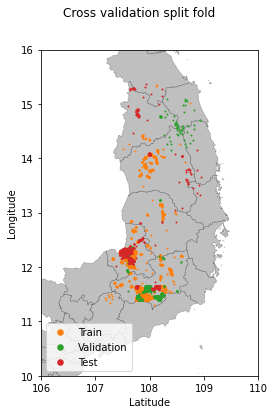

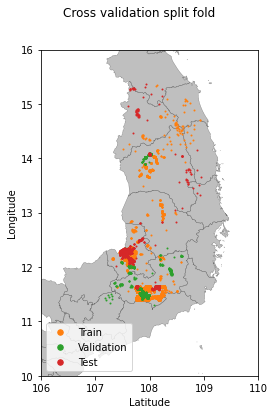

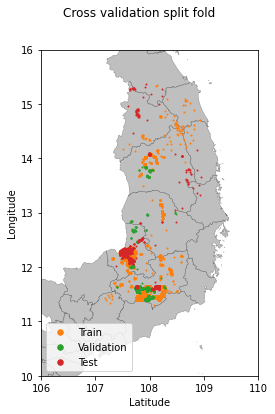

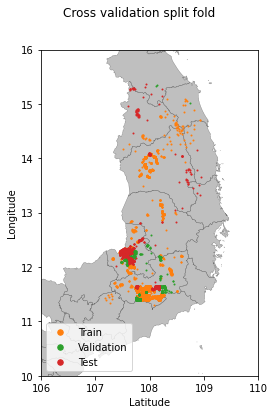

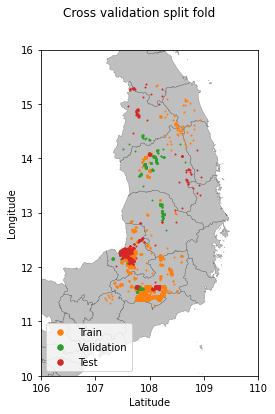

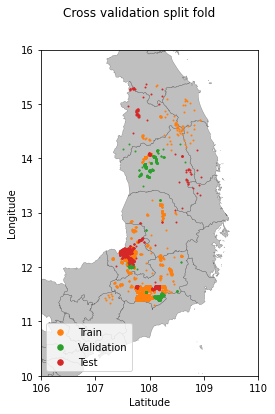

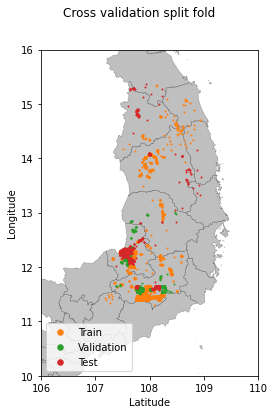

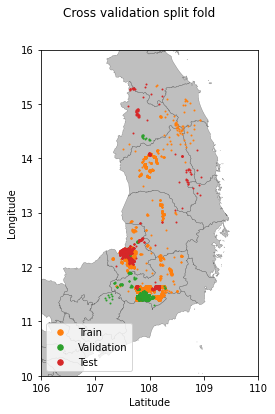

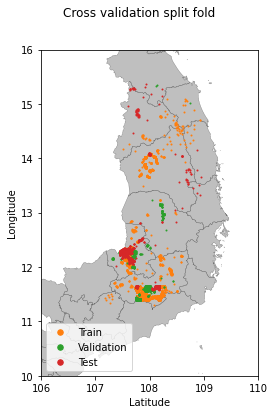

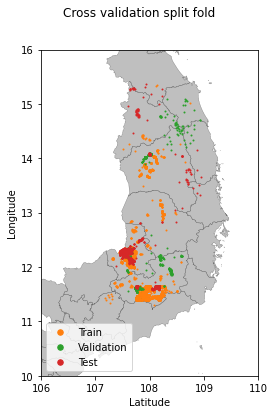

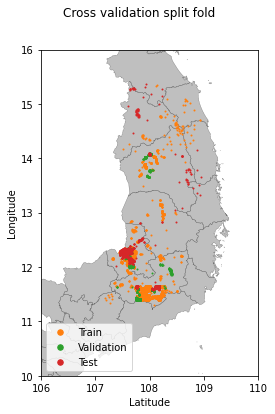

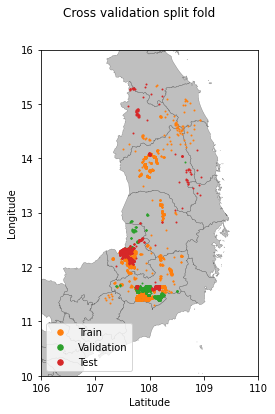

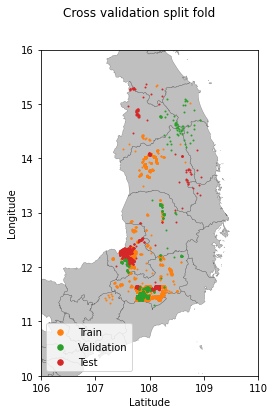

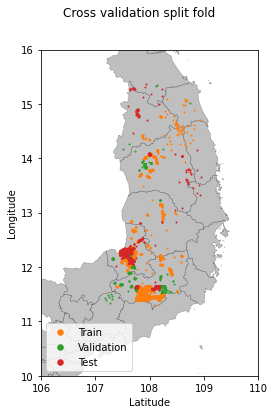

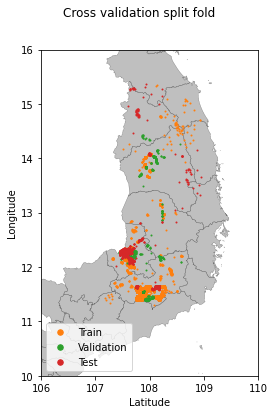

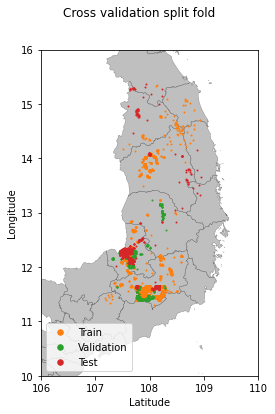

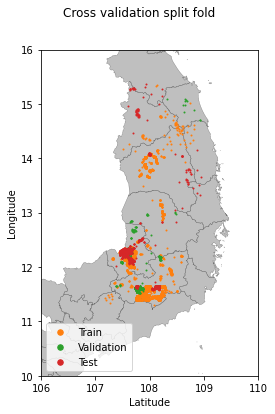

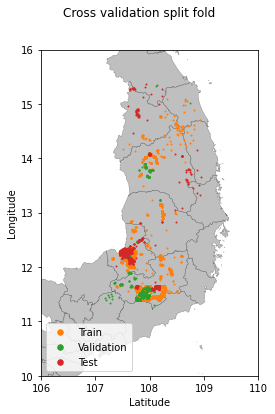

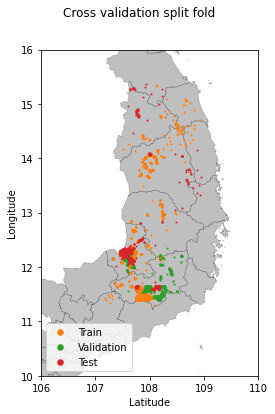

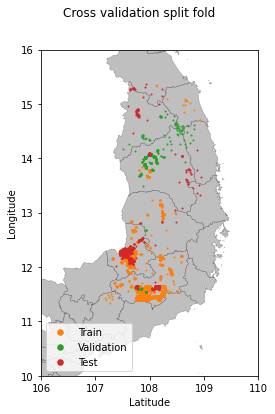

In [9]:
bands = [
    Band.COASTAL_AEROSOL.value, 
    Band.BLUE.value, 
    Band.GREEN.value, 
    Band.RED.value, 
    Band.NIR.value, 
    Band.SWIR1.value, 
    Band.SWIR2.value, 
]

# images have all the same shapes, take the shape of the first image
image_width = 9
image_height = 9
image_depth = len(BANDS)
nb_outputs = len(labels)

# Create model
model = Sequential([
    Rescaling(1./2**16, input_shape=(image_width, image_height, image_depth)),
    BatchNormalization(),
    Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu"),
    Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),
    Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu"),
    Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),
    SpatialDropout2D(0.25),
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.25),
    Dense(nb_outputs, activation='softmax'),
])

mean_loss, mean_accuracy, histories, conf_matrix = cross_validation_from_csv_files(model, other_csv_filename, test_csv_filename, BANDS, labels, EPOCHS, NB_TESTS, early_stopping=True)

In [10]:
print("mean loss: ", mean_loss)
print("mean accuracy: ", mean_accuracy)

mean loss:  4.50062789885996
mean accuracy:  1.9774440307513519


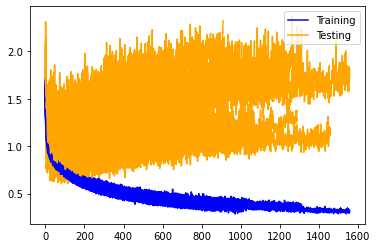

In [11]:
for i, history in enumerate(histories):
    pl.plot(history.history['loss'], label='Training', color="blue")
    pl.plot(history.history['val_loss'], label='Testing', color="orange")
    
    if i == 0:
        pl.legend()
        
    pl.grid()

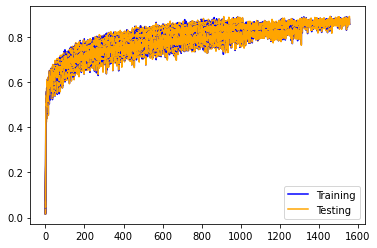

In [12]:
for i, history in enumerate(histories):
    pl.plot(history.history['f1_score_train'], label='Training', color="blue")
    pl.plot(history.history['f1_score_val'], label='Testing', color="orange")
    
    if i == 0:
        pl.legend()
        
    pl.grid()

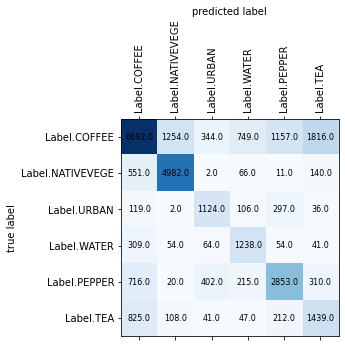

In [13]:
plot_confusion_matrix(conf_matrix, labels)

In [14]:
recall, precision, fscore = recall_precision_fscore_from_confusion_matrix(conf_matrix)

print("Precisions: ", precision)
print("Mean precision: ", np.mean(precision))
print("\nRecalls: ", recall)
print("Mean recall: ", np.mean(recall))
print("\nF-Score: ", fscore)
print("Mean f-score: ", np.mean(fscore))

Precisions:  [0.72644377 0.77601246 0.56853819 0.51135894 0.6223822  0.38048652]
Mean precision:  0.5975370126402746

Recalls:  [0.55710956 0.86613352 0.66745843 0.70340909 0.63175376 0.5385479 ]
Mean recall:  0.6607353779472748

F-Score:  [0.63060686 0.81860007 0.61403988 0.59220282 0.62703297 0.44592501]
Mean f-score:  0.6214012671281003
